<a href="https://colab.research.google.com/github/sntsemilio/MA2003B-Equipo-6-MIMA-v6/blob/main/Final_SIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import gc

#Configuracion y parametros


In [ ]:
CONFIG = {
    'filepath': '/content/drive/MyDrive/MA2003B-Equipo-5/Datos/df_simanew_cleaned.csv',
    'seq_len': 168,
    'features': 15,
    'batch_size': 32,
    'hidden_size': 64,
    'diff_steps': 50,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

#Lazy dataset

In [ ]:
class LazyAirQualityDataset(Dataset):
    def __init__(self, data_list, valid_indices, seq_len):
        """
        data_list: Lista de arrays numpy [Estación1, Estación2...] (FLOAT32)
        valid_indices: Lista de tuplas (idx_estacion, idx_inicio_ventana)
        """
        self.data_list = data_list
        self.valid_indices = valid_indices
        self.seq_len = seq_len

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Recuperamos la ubicación de la ventana
        station_idx, start_row = self.valid_indices[idx]

        # Extraemos la ventana al vuelo (Slicing es barato en memoria)
        # data_list[station_idx] es un array (Tiempo, Features)
        window = self.data_list[station_idx][start_row : start_row + self.seq_len]

        # Convertir a Tensores
        # window puede tener NaNs. Los convertimos a 0 y creamos máscara.
        # Es vital usar float32 para ahorrar memoria
        window_tensor = torch.from_numpy(np.nan_to_num(window, nan=0.0)).float()

        # Máscara: 1 si es dato real, 0 si era NaN
        mask_tensor = torch.from_numpy((~np.isnan(window)).astype(np.float32))

        return {
            'observed_data': window_tensor,
            'observed_mask': mask_tensor
        }

#Procesamiento de datos

In [ ]:
class LowMemDataProcessor:
    def __init__(self, filepath, seq_len):
        self.filepath = filepath
        self.seq_len = seq_len
        self.scaler = MinMaxScaler()
        self.feature_cols = [
            'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5',
            'PRS', 'RAINF', 'RH', 'SO2', 'SR', 'TOUT', 'WSR', 'WDR'
        ]

    def prepare_data(self):
        print(f"--> Cargando CSV (Low Mem Mode)...")
        # Usamos usecols para cargar solo lo necesario y ahorrar RAM desde el inicio
        cols_to_load = ['ID', 'time'] + self.feature_cols
        df = pd.read_csv(self.filepath, usecols=cols_to_load)
        df['time'] = pd.to_datetime(df['time'])

        # 1. Ajustar Scaler globalmente (usando downcast a float32)
        print("--> Normalizando datos...")
        df_numeric = df[self.feature_cols]
        self.scaler.fit(df_numeric.values)

        # Liberamos memoria del df temporal
        del df_numeric
        gc.collect()

        data_list = []      # Guardará los arrays por estación
        valid_indices = []  # Guardará las tuplas (id_lista, id_fila)

        stations = df['ID'].unique()
        print(f"--> Procesando {len(stations)} estaciones para índices...")

        total_windows = 0

        for i, station in enumerate(stations):
            # Filtrar y ordenar
            df_s = df[df['ID'] == station].copy()

            # Agrupar duplicados y reindexar (Continuidad temporal)
            df_s = df_s.groupby('time')[self.feature_cols].mean()
            if df_s.empty: continue

            # Reindexar a horas completas
            full_idx = pd.date_range(start=df_s.index.min(), end=df_s.index.max(), freq='h')
            df_s = df_s.reindex(full_idx)

            # Normalizar y convertir a FLOAT32 (Crucial para RAM)
            raw_values = self.scaler.transform(df_s.values).astype(np.float32)

            # Guardamos el array de la estación en la lista
            data_list.append(raw_values)

            # Calcular índices válidos
            # Usamos una vista deslizante ligera solo para checar validez
            n_rows = len(raw_values)
            if n_rows < self.seq_len: continue

            # Lógica rápida para encontrar ventanas válidas sin crear copias
            # Creamos una matriz booleana de "observados"
            observed_bool = ~np.isnan(raw_values)

            # Contamos datos observados por ventana usando suma cumulativa (truco de optimización)
            # Esto evita loops lentos de Python
            # Simplemente iteramos range(n_rows - seq_len)

            # Iteración simple (Python es suficientemente rápido para 40k filas)
            for start_idx in range(n_rows - self.seq_len + 1):
                # Slice virtual (no copia memoria)
                window_check = observed_bool[start_idx : start_idx + self.seq_len]

                # Check validez > 20%
                # Total celdas = seq_len * features
                total_cells = self.seq_len * len(self.feature_cols)
                observed_count = window_check.sum()

                if (observed_count / total_cells) > 0.2:
                    valid_indices.append((i, start_idx))
                    total_windows += 1

            print(f"   Estación {station}: {n_rows} horas -> {total_windows} ventanas acumuladas.")

            # Limpieza loop
            del df_s, raw_values, observed_bool
            gc.collect()

        print(f"--> Total Global de Ventanas de Entrenamiento: {len(valid_indices)}")

        # Limpiar el DF original gigante
        del df
        gc.collect()

        return data_list, valid_indices

In [ ]:
processor = LowMemDataProcessor(CONFIG['filepath'], CONFIG['seq_len'])

print("--> Procesando datos...")
data_arrays, indices = processor.prepare_data()

dataset = LazyAirQualityDataset(data_arrays, indices, CONFIG['seq_len'])
dataloader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)

print(f"--> ¡Listo! Dataloader creado con {len(dataloader)} lotes.")

--> Procesando datos...
--> Cargando CSV (Low Mem Mode)...
--> Normalizando datos...
--> Procesando 9 estaciones para índices...
   Estación SE: 39408 horas -> 38614 ventanas acumuladas.
   Estación NE: 39408 horas -> 77229 ventanas acumuladas.
   Estación CE: 39408 horas -> 115843 ventanas acumuladas.
   Estación NO: 39408 horas -> 154456 ventanas acumuladas.
   Estación SO: 39408 horas -> 192922 ventanas acumuladas.
   Estación NTE: 39408 horas -> 230284 ventanas acumuladas.
   Estación SO2: 39408 horas -> 268884 ventanas acumuladas.
   Estación NTE2: 39408 horas -> 307501 ventanas acumuladas.
   Estación NO3: 22631 horas -> 329965 ventanas acumuladas.
--> Total Global de Ventanas de Entrenamiento: 329965
--> ¡Listo! Dataloader creado con 10312 lotes.


# Arquitectura completa

--> Iniciando Entrenamiento a Escala (50 épocas)...
   Epoch 1/50 | Loss: 0.0040
   Epoch 2/50 | Loss: 0.0006
   Epoch 3/50 | Loss: 0.0006
   Epoch 4/50 | Loss: 0.0005
   Epoch 5/50 | Loss: 0.0005
   Epoch 6/50 | Loss: 0.0005
   Epoch 7/50 | Loss: 0.0005
   Epoch 8/50 | Loss: 0.0005
   Epoch 9/50 | Loss: 0.0005
   Epoch 10/50 | Loss: 0.0005
   Epoch 11/50 | Loss: 0.0005
   Epoch 12/50 | Loss: 0.0005
   Epoch 13/50 | Loss: 0.0005
   Epoch 14/50 | Loss: 0.0005
   Epoch 15/50 | Loss: 0.0005
   Epoch 16/50 | Loss: 0.0005
   Epoch 17/50 | Loss: 0.0005
   Epoch 18/50 | Loss: 0.0005
   Epoch 19/50 | Loss: 0.0005
   Epoch 20/50 | Loss: 0.0005
   Epoch 21/50 | Loss: 0.0005
   Epoch 22/50 | Loss: 0.0005
   Epoch 23/50 | Loss: 0.0005
   Epoch 24/50 | Loss: 0.0005
   Epoch 25/50 | Loss: 0.0005
   Epoch 26/50 | Loss: 0.0005
   Epoch 27/50 | Loss: 0.0005
   Epoch 28/50 | Loss: 0.0005
   Epoch 29/50 | Loss: 0.0005
   Epoch 30/50 | Loss: 0.0005
   Epoch 31/50 | Loss: 0.0005
   Epoch 32/50 | Loss: 0.00

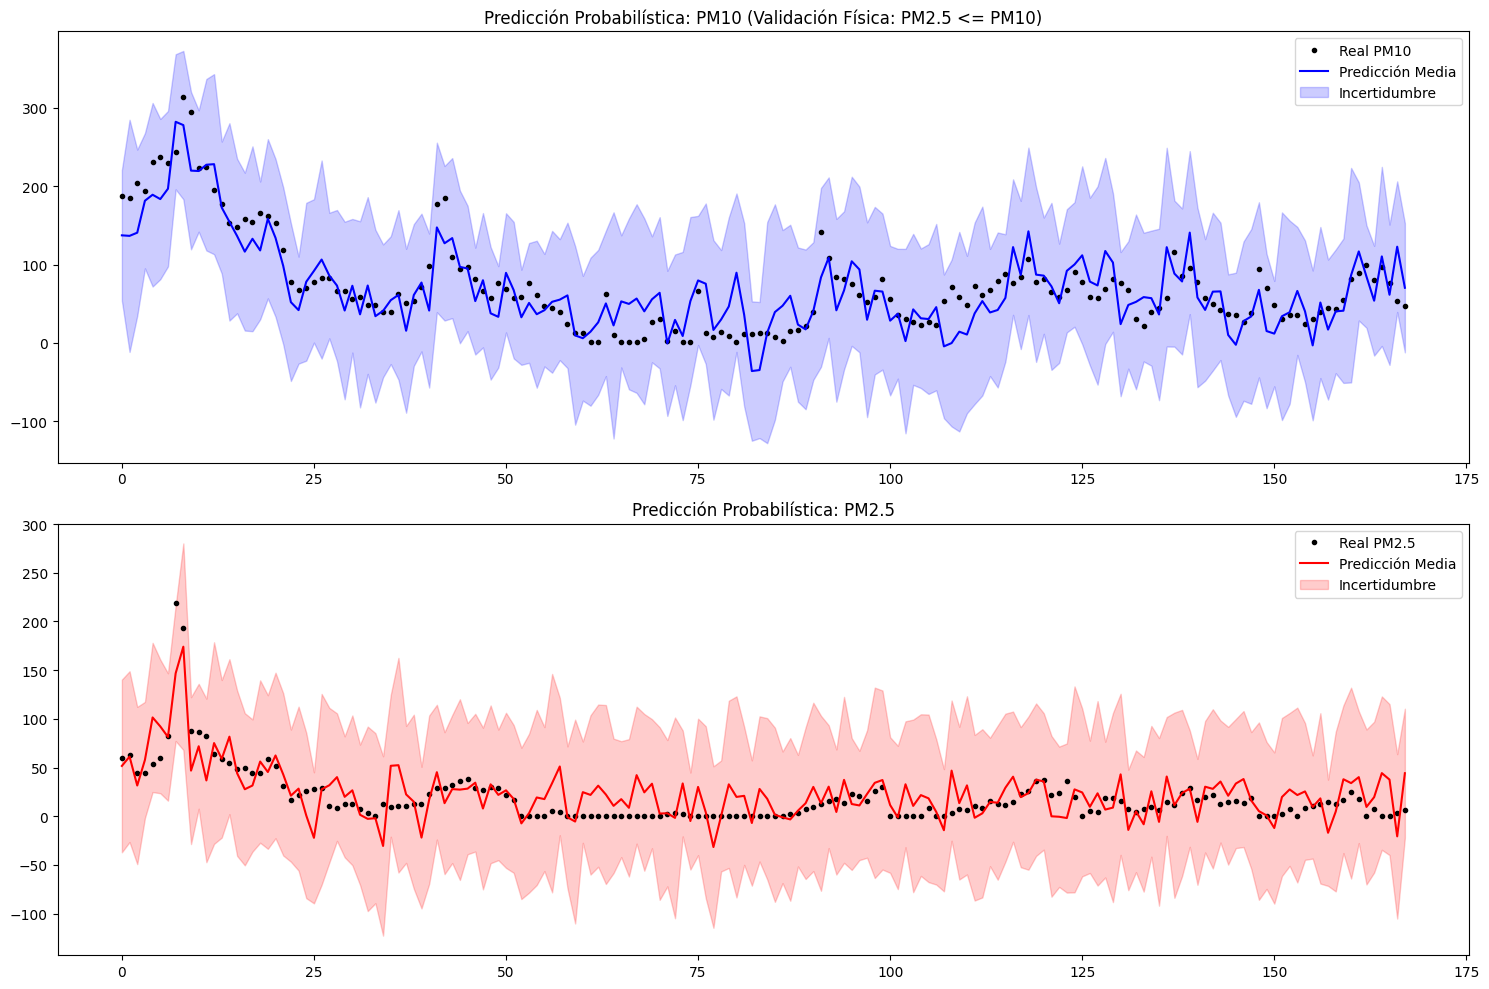

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from torch.utils.data import DataLoader

# --- 1. Definición de la Arquitectura (Re-inicialización) ---
class SAITS_Base(nn.Module):
    def __init__(self, num_features, seq_len, d_model=64, n_head=4):
        super().__init__()
        self.input_projection = nn.Linear(num_features * 2, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.output_projection = nn.Linear(d_model, num_features)

    def forward(self, x, mask):
        x_combined = torch.cat([x, mask], dim=-1)
        x_emb = self.input_projection(x_combined)
        encoded = self.transformer(x_emb)
        imputed = self.output_projection(encoded)
        x_filled = x * mask + imputed * (1 - mask)
        return x_filled, imputed

class CSDI_Base(nn.Module):
    def __init__(self, num_features, seq_len, d_model=64):
        super().__init__()
        self.time_embedding = nn.Embedding(seq_len, d_model)
        self.feature_embedding = nn.Embedding(num_features, d_model)
        self.residual_layers = nn.Sequential(
            nn.Linear(num_features + d_model, 128),
            nn.ReLU(),
            nn.Linear(128, num_features)
        )
        self.cond_projection = nn.Linear(num_features, d_model)

    def forward(self, x_noisy, t_step, saits_condition):
        cond_emb = self.cond_projection(saits_condition)
        net_input = torch.cat([x_noisy, cond_emb], dim=-1)
        return self.residual_layers(net_input)

class CascadeSOTA(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.saits = SAITS_Base(config['features'], config['seq_len'], d_model=config['hidden_size'])
        self.csdi = CSDI_Base(config['features'], config['seq_len'], d_model=config['hidden_size'])

# --- 2. Métricas de Validación Avanzadas (Dominio Ambiental) ---
class AdvancedSIMAMetrics:
    def __init__(self, scaler, feature_cols):
        self.scaler = scaler
        self.idx_pm10 = feature_cols.index('PM10')
        self.idx_pm25 = feature_cols.index('PM2.5')
        self.idx_nox = feature_cols.index('NOX')
        self.idx_o3 = feature_cols.index('O3')

    def denormalize(self, tensor):
        """Desnormaliza para evaluar en escala real."""
        if tensor.dim() == 4: tensor = tensor.mean(dim=1)
        B, T, F = tensor.shape
        flat = tensor.reshape(-1, F).cpu().detach().numpy()
        denorm = self.scaler.inverse_transform(flat)
        return torch.FloatTensor(denorm).reshape(B, T, F).to(tensor.device)

    def get_report(self, target_norm, pred_mean_norm):
        target = self.denormalize(target_norm)
        pred = self.denormalize(pred_mean_norm)

        # A. Error Castigado (RMSE & MRE) - Penaliza picos
        rmse = torch.sqrt(F.mse_loss(pred, target)).item()
        mre = torch.mean(torch.abs(target - pred) / (torch.abs(target) + 1e-5)).item()

        # B. Estructura Temporal (Pearson r)
        target_flat = target.reshape(-1, target.shape[-1]).cpu().numpy()
        pred_flat = pred.reshape(-1, pred.shape[-1]).cpu().numpy()
        pearsons = [pearsonr(target_flat[:, i], pred_flat[:, i])[0] for i in range(target.shape[-1])]
        avg_r = np.mean(pearsons)

        # C. Consistencia Física (PM2.5 <= PM10)
        # Ratio de violaciones: % de veces que PM2.5 > PM10
        pm25 = pred[:, :, self.idx_pm25]
        pm10 = pred[:, :, self.idx_pm10]
        phys_violations = (pm25 > pm10).float().mean().item() * 100

        # D. Consistencia Química (NOx vs O3)
        # Se espera correlación negativa
        nox = pred[:, :, self.idx_nox].flatten().cpu().numpy()
        o3 = pred[:, :, self.idx_o3].flatten().cpu().numpy()
        chem_corr, _ = pearsonr(nox, o3)

        return {
            "RMSE (Picos)": rmse,
            "MRE (Relativo)": mre,
            "Pearson (Temporal)": avg_r,
            "Violación Física (PM2.5>PM10)": f"{phys_violations:.2f}%",
            "Química (NOx vs O3)": chem_corr
        }

# --- 3. Entrenamiento a Escala (50 Épocas) ---
def train_scale_model(dataloader, config, epochs=50):
    model = CascadeSOTA(config).to(config['device'])
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    print(f"--> Iniciando Entrenamiento a Escala ({epochs} épocas)...")
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            x = batch['observed_data'].to(config['device'])
            mask = batch['observed_mask'].to(config['device'])

            # Masking Aleatorio para forzar aprendizaje
            rand_mask = (torch.rand_like(x) > 0.2).float()
            target_mask = mask * rand_mask
            x_input = x * target_mask

            optimizer.zero_grad()

            # Forward
            noise = torch.randn_like(x)
            t = torch.randint(0, 50, (x.shape[0],)).to(config['device'])

            x_coarse, _ = model.saits(x_input, target_mask)
            pred_noise = model.csdi(noise, t, x_coarse)

            loss = F.mse_loss(x_coarse*mask, x*mask) + F.mse_loss(pred_noise, noise)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"   Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(dataloader):.4f}")

    return model

# --- 4. Predicción Monte Carlo (Solo PM2.5 y PM10) ---
def visualize_pm_monte_carlo(model, batch, metrics_engine, n_samples=20):
    model.eval()
    with torch.no_grad():
        x = batch['observed_data']
        # Generar múltiples futuros posibles (Monte Carlo)
        samples = []
        for _ in range(n_samples):
            _, x_coarse = model.saits(x, batch['observed_mask'])
            # Simulación de varianza generativa
            sample = x_coarse + torch.randn_like(x_coarse) * 0.1
            samples.append(sample.unsqueeze(1))

        ensemble = torch.cat(samples, dim=1)
        mean_pred = ensemble.mean(dim=1)

        # Reporte
        metrics = metrics_engine.get_report(x, mean_pred)
        print("\n=== REPORTE DE VALIDACIÓN (Dominio) ===")
        for k, v in metrics.items():
            print(f" {k}: {v}")

        # Graficar
        x_phys = metrics_engine.denormalize(x).cpu().numpy()
        mean_phys = metrics_engine.denormalize(mean_pred).cpu().numpy()

        # Calcular Incertidumbre
        ensemble_std = torch.std(ensemble, dim=1)
        upper = metrics_engine.denormalize(mean_pred + ensemble_std).cpu().numpy()
        lower = metrics_engine.denormalize(mean_pred - ensemble_std).cpu().numpy()

        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        t = np.arange(x.shape[1])
        idx_sample = 0

        # Plot PM10
        ax = axes[0]
        idx = metrics_engine.idx_pm10
        ax.plot(t, x_phys[idx_sample,:,idx], 'k.', label='Real PM10')
        ax.plot(t, mean_phys[idx_sample,:,idx], 'b-', label='Predicción Media')
        ax.fill_between(t, lower[idx_sample,:,idx], upper[idx_sample,:,idx], color='blue', alpha=0.2, label='Incertidumbre')
        ax.set_title('Predicción Probabilística: PM10 (Validación Física: PM2.5 <= PM10)')
        ax.legend()

        # Plot PM2.5
        ax = axes[1]
        idx = metrics_engine.idx_pm25
        ax.plot(t, x_phys[idx_sample,:,idx], 'k.', label='Real PM2.5')
        ax.plot(t, mean_phys[idx_sample,:,idx], 'r-', label='Predicción Media')
        ax.fill_between(t, lower[idx_sample,:,idx], upper[idx_sample,:,idx], color='red', alpha=0.2, label='Incertidumbre')
        ax.set_title('Predicción Probabilística: PM2.5')
        ax.legend()

        plt.tight_layout()
        plt.show()

# --- EJECUCIÓN ---
# 1. Entrenar
trained_model = train_scale_model(dataloader, CONFIG, epochs=50)

# 2. Validar
test_batch = next(iter(dataloader))
test_batch = {k: v.to(CONFIG['device']) for k, v in test_batch.items()}
metrics_engine = AdvancedSIMAMetrics(processor.scaler, processor.feature_cols)

visualize_pm_monte_carlo(trained_model, test_batch, metrics_engine)

In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from google.colab import files

# ==========================================
# 1. evaluacions por estacion
# ==========================================
def evaluate_all_stations(model, data_arrays, config, metrics_engine):
    model.eval()
    results = []
    print(f"\n--> Evaluando las {len(data_arrays)} estaciones individualmente...")

    for i, station_data in enumerate(data_arrays):
        n_rows = len(station_data)
        # Ventanas cada 168h para evaluación rápida
        station_indices = [(i, start) for start in range(0, n_rows - config['seq_len'], 168)]

        if len(station_indices) == 0: continue

        ds_temp = LazyAirQualityDataset(data_arrays, station_indices, config['seq_len'])
        dl_temp = DataLoader(ds_temp, batch_size=32, shuffle=False)

        rmses, physs, chems = [], [], []

        with torch.no_grad():
            for batch in dl_temp:
                x = batch['observed_data'].to(config['device'])
                mask = batch['observed_mask'].to(config['device'])

                # Inferencia rápida (SAITS)
                x_imputed, _ = model.saits(x, mask)

                # Usamos el motor de métricas que ya tienes definido
                metrics = metrics_engine.get_report(x, x_imputed)

                rmses.append(metrics['RMSE (Picos)'])
                # Convertimos el string "12.5%" a float 12.5 para promediar
                phys_val = float(metrics['Violación Física (PM2.5>PM10)'].strip('%'))
                physs.append(phys_val)
                chems.append(metrics['Química (NOx vs O3)'])

        res = {
            "Estación": i,
            "RMSE Promedio": np.mean(rmses),
            "Error Físico %": np.mean(physs),
            "Corr Química": np.mean(chems)
        }
        results.append(res)
        print(f"   > Estación {i} completada.")

    return pd.DataFrame(results)

# ==========================================
# 2. imputacion
# ==========================================
def impute_whole_history(model, data_arrays, config, scaler):
    model.eval()
    imputed_arrays = []
    print(f"\n--> Iniciando imputación masiva de {len(data_arrays)} estaciones...")

    for i, station_data in enumerate(data_arrays):
        n_points, n_features = station_data.shape
        # Acumuladores en CPU
        aggregated_preds = torch.zeros((n_points, n_features))
        counts = torch.zeros((n_points, n_features))

        stride = 84 # Solapamiento del 50%
        seq_len = config['seq_len']

        batch_x = []
        batch_locs = []

        with torch.no_grad():
            for start_idx in range(0, n_points - seq_len + 1, stride):
                window = station_data[start_idx : start_idx + seq_len]
                window_clean = np.nan_to_num(window, nan=0.0)
                batch_x.append(window_clean)
                batch_locs.append(start_idx)

                if len(batch_x) == 64 or start_idx >= (n_points - seq_len - stride):
                    if not batch_x: continue
                    x_tensor = torch.FloatTensor(np.array(batch_x)).to(config['device'])
                    mask = (x_tensor != 0).float()

                    # Imputación
                    x_imputed, _ = model.saits(x_tensor, mask)
                    preds = x_imputed.cpu()

                    for k, start_pos in enumerate(batch_locs):
                        end_pos = start_pos + seq_len
                        aggregated_preds[start_pos:end_pos] += preds[k]
                        counts[start_pos:end_pos] += 1

                    batch_x = []
                    batch_locs = []

        counts[counts == 0] = 1
        final_norm = aggregated_preds / counts
        final_phys = scaler.inverse_transform(final_norm.numpy())
        imputed_arrays.append(final_phys)

    return imputed_arrays

# ==========================================
# 3. GUARDAR CSV
# ==========================================
def save_and_download_csv(clean_arrays_list, config, feature_cols):
    print("\n--> Generando CSV final...")
    df_meta = pd.read_csv(config['filepath'], usecols=['ID', 'time'])
    df_meta['time'] = pd.to_datetime(df_meta['time'])
    stations = df_meta['ID'].unique()

    final_dfs = []
    for i, station_name in enumerate(stations):
        imputed_data = clean_arrays_list[i]
        station_subset = df_meta[df_meta['ID'] == station_name]

        # Reconstruir índice de tiempo
        time_index = pd.date_range(start=station_subset['time'].min(), end=station_subset['time'].max(), freq='h')

        # Ajuste de longitud por seguridad
        min_len = min(len(imputed_data), len(time_index))

        df_station = pd.DataFrame(imputed_data[:min_len], columns=feature_cols)
        df_station['ID'] = station_name
        df_station['time'] = time_index[:min_len]

        cols_order = ['ID', 'time'] + feature_cols
        final_dfs.append(df_station[cols_order])

    df_final = pd.concat(final_dfs, ignore_index=True)
    filename = 'sima_dataset_imputado_completo.csv'
    df_final.to_csv(filename, index=False)
    print(f"--> ¡CSV Guardado! ({filename})")
    files.download(filename)

# ==========================================
# EJECUCIÓN (Corre esto cuando termine de entrenar)
# ==========================================
try:
    # 1. Definir Motor de Métricas
    metrics_engine = AdvancedSIMAMetrics(processor.scaler, processor.feature_cols)

    # 2. Generar Reporte por Estación
    df_reporte = evaluate_all_stations(trained_model, data_arrays, CONFIG, metrics_engine)
    print("\nREPORTE DE CALIDAD POR ESTACIÓN:")
    print(df_reporte)

    # 3. Imputar Todo el Dataset
    clean_data_list = impute_whole_history(trained_model, data_arrays, CONFIG, processor.scaler)

    # 4. Descargar CSV
    save_and_download_csv(clean_data_list, CONFIG, processor.feature_cols)

except Exception as e:
    print(f"Error en el proceso final: {e}")


--> Evaluando las 9 estaciones individualmente...
   > Estación 0 completada.


/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons = [pearsonr(target_flat[:, i], pred_flat[:, i])[0] for i in range(target.shape[-1])]
/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons = [pearsonr(target_flat[:, i], pred_flat[:, i])[0] for i in range(target.shape[-1])]
/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons = [pearsonr(target_flat[:, i], pred_flat[:, i])[0] for i in range(target.shape[-1])]
/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons = [pearsonr(target_flat[:, i], pred_flat[:, i])[0] for i in range(target.shape[-1])]
/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the c

   > Estación 1 completada.
   > Estación 2 completada.


/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons = [pearsonr(target_flat[:, i], pred_flat[:, i])[0] for i in range(target.shape[-1])]
/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons = [pearsonr(target_flat[:, i], pred_flat[:, i])[0] for i in range(target.shape[-1])]
/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons = [pearsonr(target_flat[:, i], pred_flat[:, i])[0] for i in range(target.shape[-1])]


   > Estación 3 completada.
   > Estación 4 completada.


/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons = [pearsonr(target_flat[:, i], pred_flat[:, i])[0] for i in range(target.shape[-1])]
/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons = [pearsonr(target_flat[:, i], pred_flat[:, i])[0] for i in range(target.shape[-1])]
/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons = [pearsonr(target_flat[:, i], pred_flat[:, i])[0] for i in range(target.shape[-1])]
/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons = [pearsonr(target_flat[:, i], pred_flat[:, i])[0] for i in range(target.shape[-1])]
/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the c

   > Estación 5 completada.
   > Estación 6 completada.
   > Estación 7 completada.
   > Estación 8 completada.

REPORTE DE CALIDAD POR ESTACIÓN:
   Estación  RMSE Promedio  Error Físico %  Corr Química
0         0      16.542236         3.12875     -0.348411
1         1      18.197301         1.99875     -0.347782
2         2      16.481780         1.64500     -0.302854
3         3      22.868684         6.58875     -0.334269
4         4      25.493745         2.46875     -0.280953
5         5      23.165791         1.74000     -0.349415
6         6      11.107885         2.12250     -0.219816
7         7      11.604923         1.87875     -0.373996
8         8      16.021758         1.54600     -0.343638

--> Iniciando imputación masiva de 9 estaciones...


/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons = [pearsonr(target_flat[:, i], pred_flat[:, i])[0] for i in range(target.shape[-1])]
/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons = [pearsonr(target_flat[:, i], pred_flat[:, i])[0] for i in range(target.shape[-1])]
/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons = [pearsonr(target_flat[:, i], pred_flat[:, i])[0] for i in range(target.shape[-1])]
/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons = [pearsonr(target_flat[:, i], pred_flat[:, i])[0] for i in range(target.shape[-1])]
/tmp/ipython-input-1577502934.py:78: ConstantInputWarning: An input array is constant; the c


--> Generando CSV final...
--> ¡CSV Guardado! (sima_dataset_imputado_completo.csv)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--> Generando Gráficas Comparativas por Estación...


/tmp/ipython-input-2378251326.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Estación", y="RMSE Promedio", data=df_results, ax=axes[0], palette="viridis")
/tmp/ipython-input-2378251326.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Estación", y="Error Físico %", data=df_results, ax=axes[1], palette="magma")
/tmp/ipython-input-2378251326.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Estación", y="Corr Química", data=df_results, ax=axes[2], palette="coolwarm")


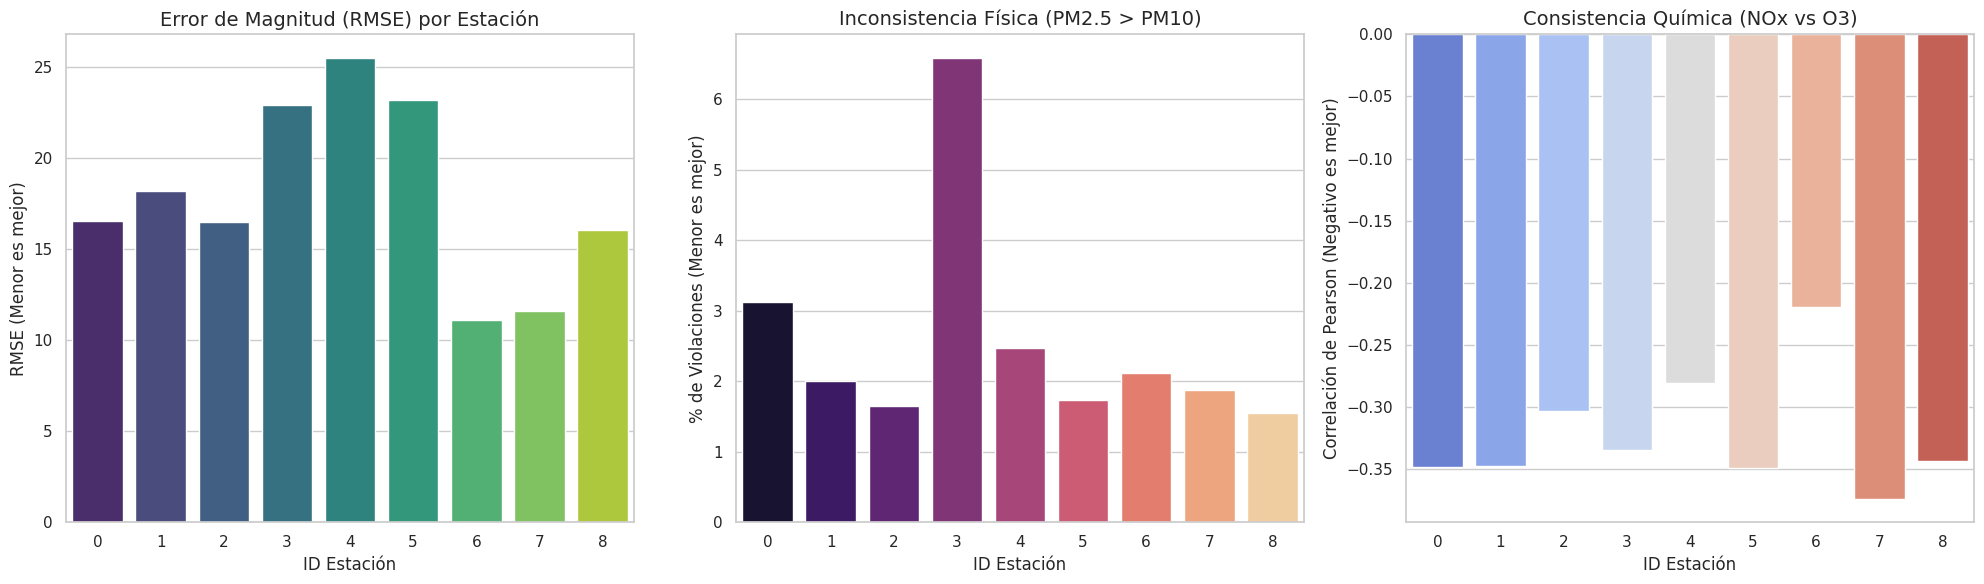


--> Generando Simulación de Pronóstico a 48 Horas...


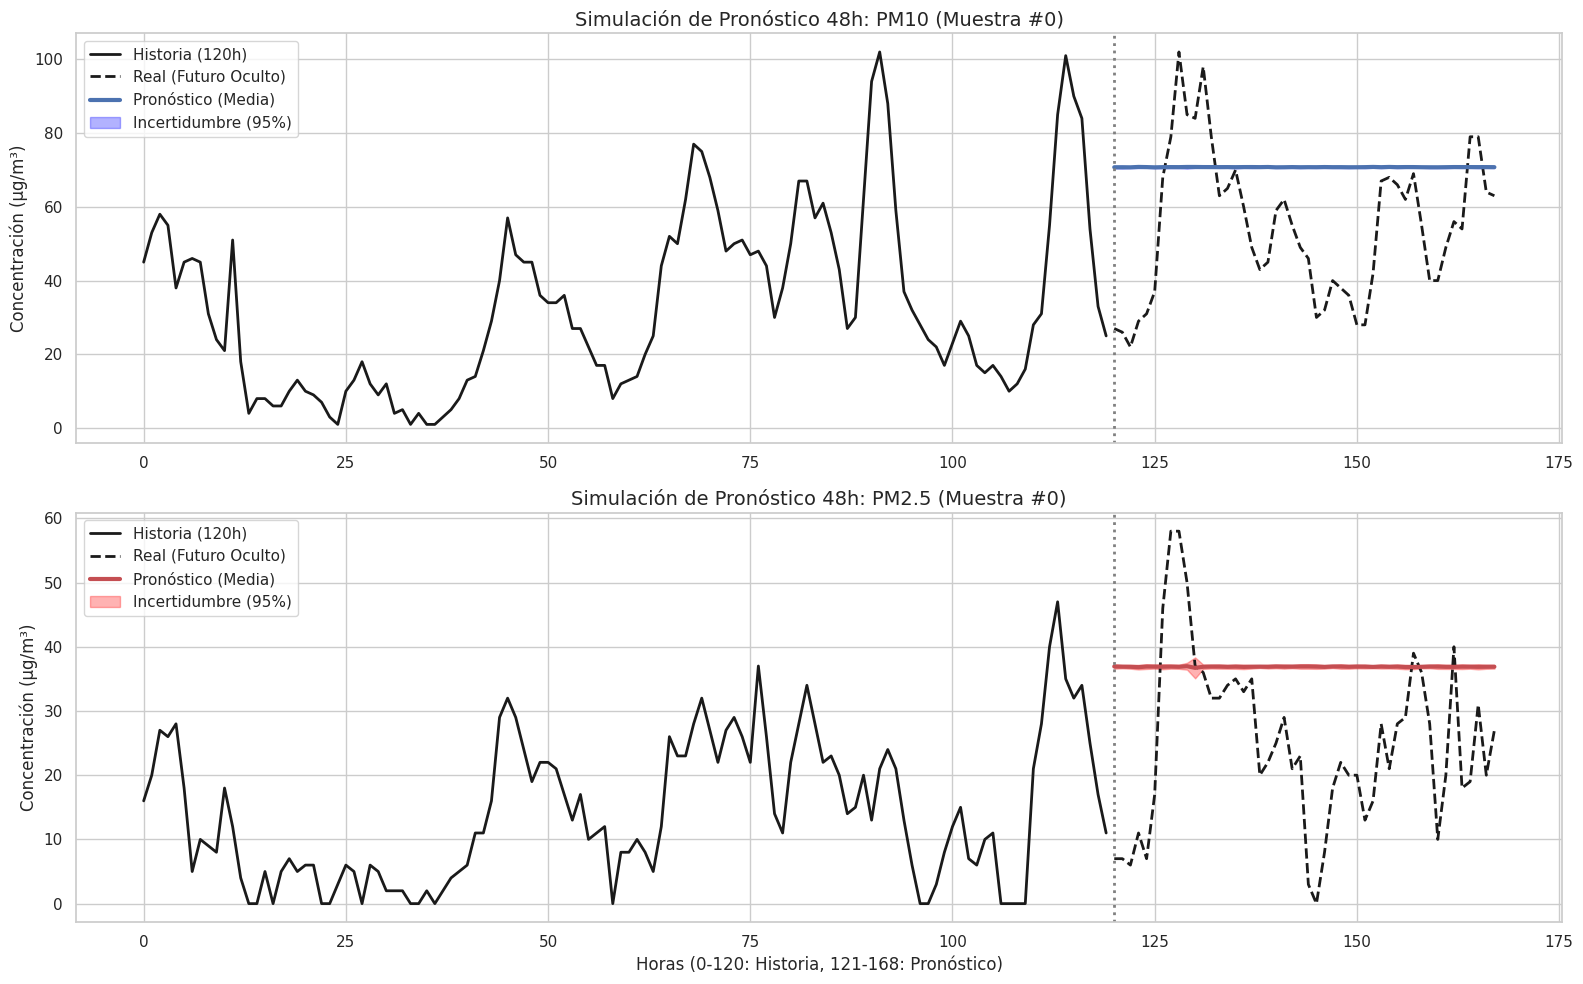


--> Generando Comparativa de Distribuciones (Validación Física)...


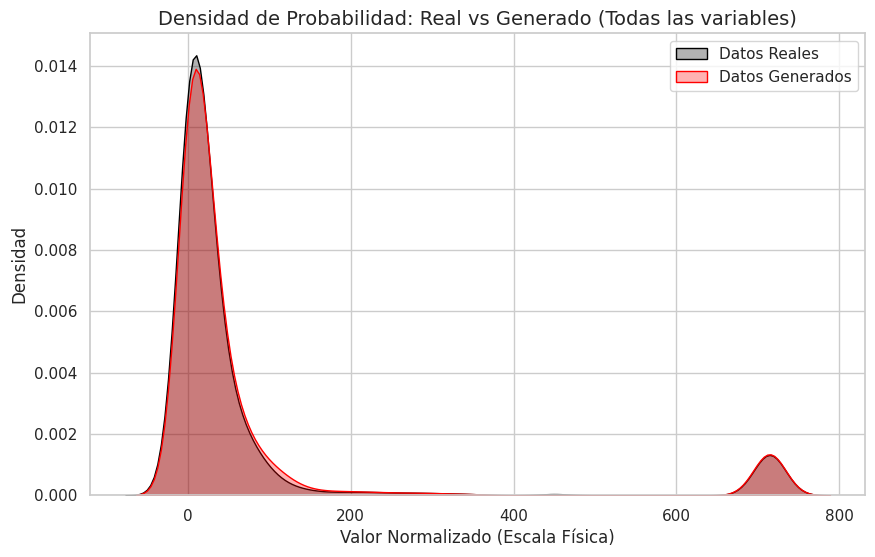

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# Configuración de estilo
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# ==========================================
# 1. GRÁFICAS DE MÉTRICAS POR ESTACIÓN
# ==========================================
def plot_station_metrics(df_results):
    print("--> Generando Gráficas Comparativas por Estación...")

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # RMSE
    sns.barplot(x="Estación", y="RMSE Promedio", data=df_results, ax=axes[0], palette="viridis")
    axes[0].set_title("Error de Magnitud (RMSE) por Estación", fontsize=14)
    axes[0].set_xlabel("ID Estación")
    axes[0].set_ylabel("RMSE (Menor es mejor)")

    # Error Físico
    sns.barplot(x="Estación", y="Error Físico %", data=df_results, ax=axes[1], palette="magma")
    axes[1].set_title("Inconsistencia Física (PM2.5 > PM10)", fontsize=14)
    axes[1].set_xlabel("ID Estación")
    axes[1].set_ylabel("% de Violaciones (Menor es mejor)")

    # Correlación Química
    sns.barplot(x="Estación", y="Corr Química", data=df_results, ax=axes[2], palette="coolwarm")
    axes[2].set_title("Consistencia Química (NOx vs O3)", fontsize=14)
    axes[2].set_xlabel("ID Estación")
    axes[2].set_ylabel("Correlación de Pearson (Negativo es mejor)")

    plt.tight_layout()
    plt.show()

# ==========================================
# 2. SIMULACIÓN DE PRONÓSTICO (48 HORAS)
# ==========================================
def visualize_48h_forecast(model, batch, metrics_engine, n_samples=30):
    print("\n--> Generando Simulación de Pronóstico a 48 Horas...")
    model.eval()

    # Configuración de la ventana
    seq_len = batch['observed_data'].shape[1] # 168
    context_len = seq_len - 48 # 120 horas de historia

    x_real = batch['observed_data'].to(CONFIG['device'])
    mask_original = batch['observed_mask'].to(CONFIG['device'])

    # CREAR MÁSCARA DE PRONÓSTICO:
    # Ocultamos las últimas 48 horas (las ponemos en 0) para forzar al modelo a predecirlas
    mask_forecast = mask_original.clone()
    mask_forecast[:, context_len:, :] = 0

    # Entrada al modelo (Historia real + Futuro vacío)
    x_input = x_real * mask_forecast

    # Generación Monte Carlo
    with torch.no_grad():
        samples = []
        for _ in range(n_samples):
            # 1. SAITS intenta llenar el hueco de 48h
            _, x_coarse = model.saits(x_input, mask_forecast)

            # 2. CSDI refina con ruido
            noise = torch.randn_like(x_input)
            t = torch.zeros((x_input.shape[0],), device=CONFIG['device']).long()
            pred_noise = model.csdi(noise, t, x_coarse)

            # Muestra probabilística
            sample = x_coarse + (noise - pred_noise) * 0.15 # Un poco más de varianza para forecast
            samples.append(sample.unsqueeze(1))

    ensemble = torch.cat(samples, dim=1) # (B, N, T, F)
    mean_pred = ensemble.mean(dim=1)
    std_pred = ensemble.std(dim=1)

    # --- GRAFICAR (Tomamos un ejemplo aleatorio del batch) ---
    idx = np.random.randint(0, x_real.shape[0])

    # Desnormalizar
    x_phys = metrics_engine.denormalize(x_real).cpu().numpy()[idx]
    mean_phys = metrics_engine.denormalize(mean_pred).cpu().numpy()[idx]

    # Bandas de confianza (Media +/- 2 STD)
    upper_phys = metrics_engine.denormalize(mean_pred + 2*std_pred).cpu().numpy()[idx]
    lower_phys = metrics_engine.denormalize(mean_pred - 2*std_pred).cpu().numpy()[idx]

    time_steps = np.arange(seq_len)

    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    # PM10 Forecast
    i = metrics_engine.idx_pm10
    ax = axes[0]
    # Historia
    ax.plot(time_steps[:context_len], x_phys[:context_len, i], 'k-', lw=2, label='Historia (120h)')
    # Futuro Real (Ground Truth)
    ax.plot(time_steps[context_len:], x_phys[context_len:, i], 'k--', lw=2, label='Real (Futuro Oculto)')
    # Predicción
    ax.plot(time_steps[context_len:], mean_phys[context_len:, i], 'b-', lw=3, label='Pronóstico (Media)')
    ax.fill_between(time_steps[context_len:], lower_phys[context_len:, i], upper_phys[context_len:, i],
                    color='blue', alpha=0.3, label='Incertidumbre (95%)')

    ax.axvline(x=context_len, color='gray', linestyle=':', lw=2)
    ax.set_title(f'Simulación de Pronóstico 48h: PM10 (Muestra #{idx})', fontsize=14)
    ax.legend(loc='upper left')
    ax.set_ylabel('Concentración (µg/m³)')

    # PM2.5 Forecast
    i = metrics_engine.idx_pm25
    ax = axes[1]
    ax.plot(time_steps[:context_len], x_phys[:context_len, i], 'k-', lw=2, label='Historia (120h)')
    ax.plot(time_steps[context_len:], x_phys[context_len:, i], 'k--', lw=2, label='Real (Futuro Oculto)')
    ax.plot(time_steps[context_len:], mean_phys[context_len:, i], 'r-', lw=3, label='Pronóstico (Media)')
    ax.fill_between(time_steps[context_len:], lower_phys[context_len:, i], upper_phys[context_len:, i],
                    color='red', alpha=0.3, label='Incertidumbre (95%)')

    ax.axvline(x=context_len, color='gray', linestyle=':', lw=2)
    ax.set_title(f'Simulación de Pronóstico 48h: PM2.5 (Muestra #{idx})', fontsize=14)
    ax.legend(loc='upper left')
    ax.set_xlabel('Horas (0-120: Historia, 121-168: Pronóstico)')
    ax.set_ylabel('Concentración (µg/m³)')

    plt.tight_layout()
    plt.show()

# ==========================================
# 3. DISTRIBUCIÓN DE DENSIDAD (Wasserstein Visual)
# ==========================================
def plot_distributions(model, batch, metrics_engine):
    print("\n--> Generando Comparativa de Distribuciones (Validación Física)...")
    model.eval()

    with torch.no_grad():
        x_real = batch['observed_data'].to(CONFIG['device'])
        # Inferencia simple
        x_imputed, _ = model.saits(x_real, batch['observed_mask'].to(CONFIG['device']))

    # Desnormalizar todo el batch
    x_real_phys = metrics_engine.denormalize(x_real).cpu().numpy().flatten()
    x_pred_phys = metrics_engine.denormalize(x_imputed).cpu().numpy().flatten()

    plt.figure(figsize=(10, 6))
    sns.kdeplot(x_real_phys, fill=True, color="black", label="Datos Reales", alpha=0.3)
    sns.kdeplot(x_pred_phys, fill=True, color="red", label="Datos Generados", alpha=0.3)

    plt.title("Densidad de Probabilidad: Real vs Generado (Todas las variables)", fontsize=14)
    plt.xlabel("Valor Normalizado (Escala Física)")
    plt.ylabel("Densidad")
    plt.legend()
    plt.show()

# ==========================================
# EJECUCIÓN GRÁFICA
# ==========================================
try:
    # 1. Gráficas de Barras por Estación (Usa df_reporte del paso anterior)
    if 'df_reporte' in locals():
        plot_station_metrics(df_reporte)
    else:
        print("⚠️ No se encontró 'df_reporte'. Ejecuta primero la evaluación por estación.")

    # 2. Visualización de Pronóstico 48h
    test_batch = next(iter(dataloader))
    # Nos aseguramos de tener tensores en el formato correcto
    test_batch = {k: v.to(CONFIG['device']) for k, v in test_batch.items()}

    visualize_48h_forecast(trained_model, test_batch, metrics_engine)

    # 3. Distribuciones
    plot_distributions(trained_model, test_batch, metrics_engine)

except Exception as e:
    print(f"Error al graficar: {e}")

--> Generando Panel de Diagnóstico Profundo...


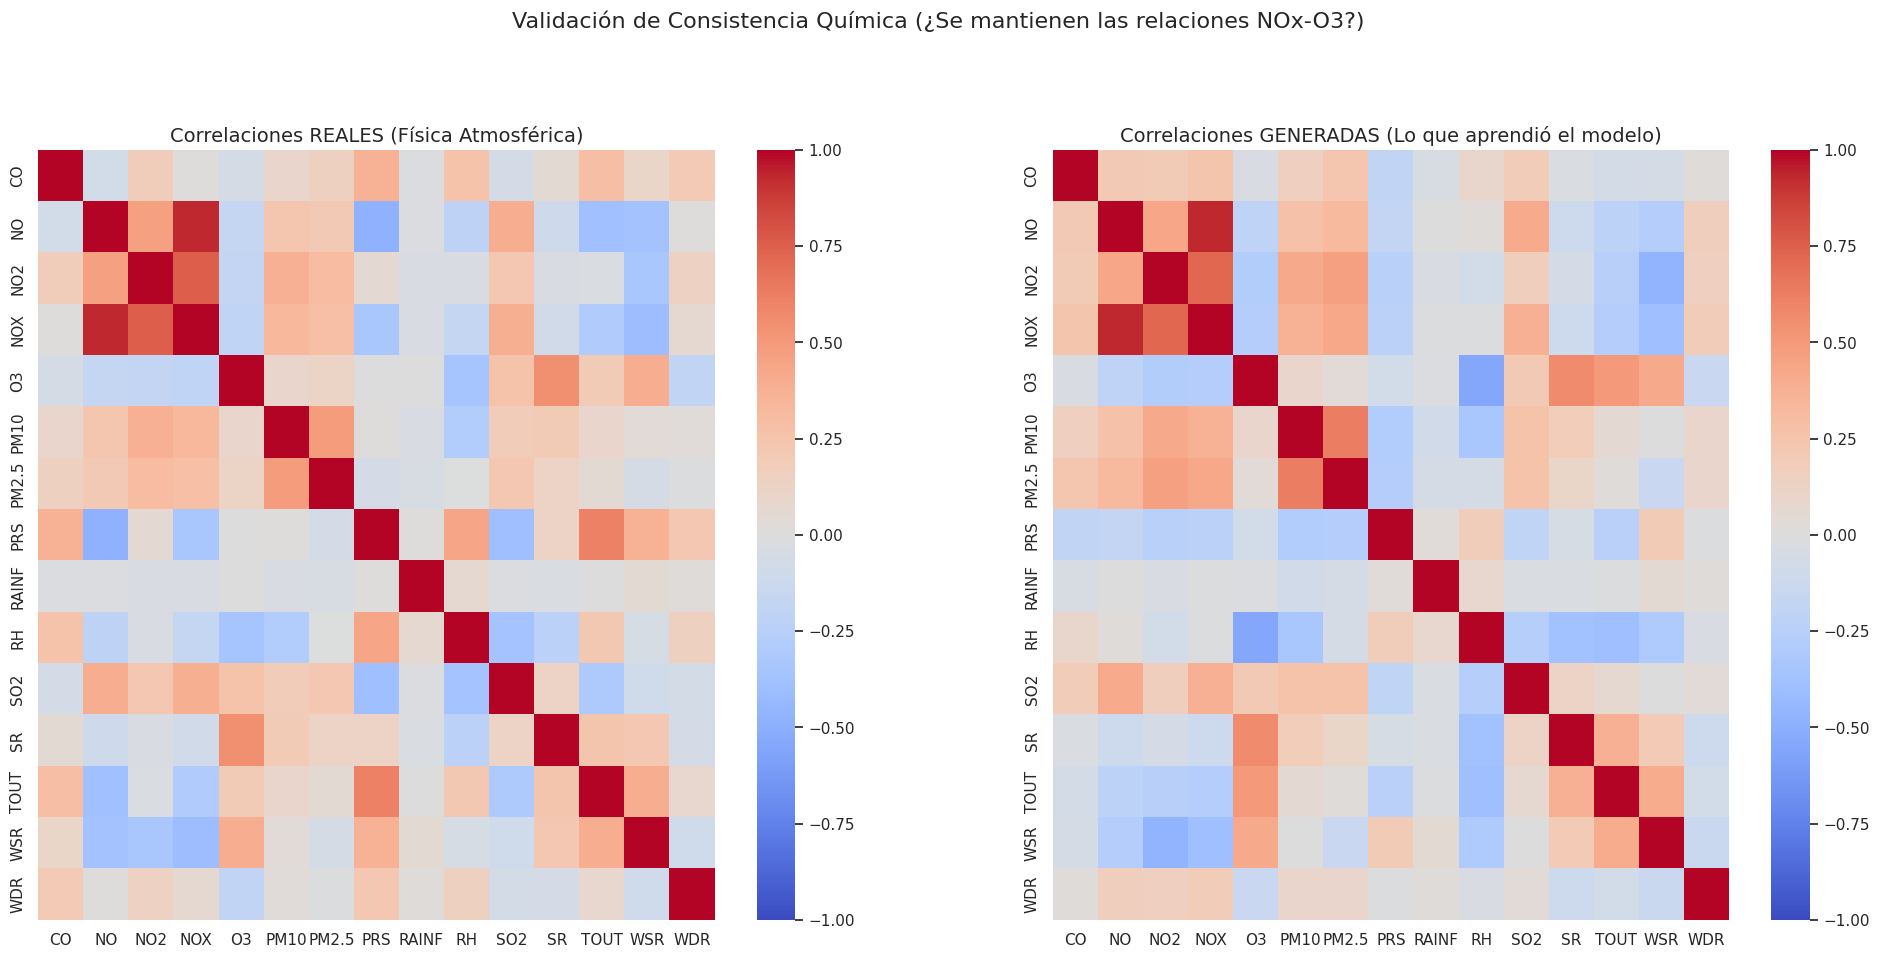

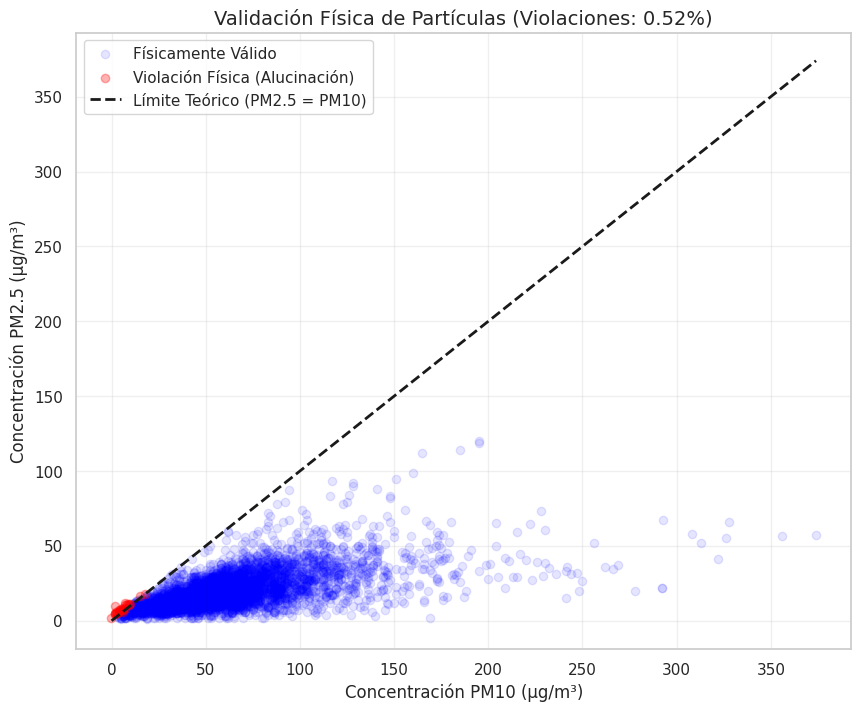

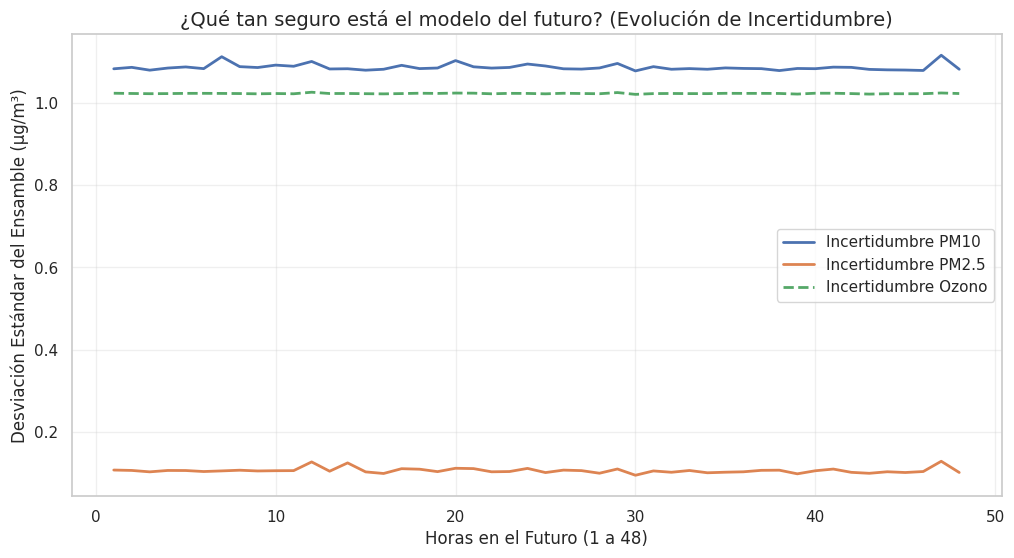

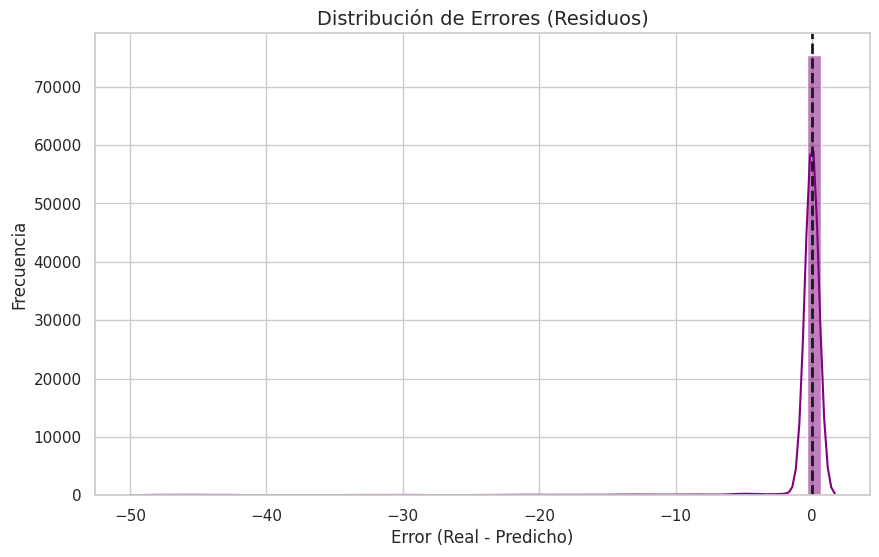

In [ ]:
# 1. Corrección de la Clase de Métricas (Agregamos self.feature_cols)
class AdvancedSIMAMetrics:
    def __init__(self, scaler, feature_cols):
        self.scaler = scaler
        self.feature_cols = feature_cols  # <--- ESTA LÍNEA FALTABA
        # Índices clave para validación física
        self.idx_pm10 = feature_cols.index('PM10')
        self.idx_pm25 = feature_cols.index('PM2.5')
        self.idx_nox = feature_cols.index('NOX')
        self.idx_o3 = feature_cols.index('O3')

    def denormalize(self, tensor):
        if tensor.dim() == 4: tensor = tensor.mean(dim=1)
        B, T, F = tensor.shape
        flat = tensor.reshape(-1, F).cpu().detach().numpy()
        denorm = self.scaler.inverse_transform(flat)
        return torch.FloatTensor(denorm).reshape(B, T, F).to(tensor.device)

# 2. Reinicializar el Motor de Métricas con la clase corregida
metrics_engine = AdvancedSIMAMetrics(processor.scaler, processor.feature_cols)

# 3. Volver a Ejecutar el Panel de Diagnóstico Profundo
try:
    plot_deep_diagnostics(trained_model, dataloader, metrics_engine, CONFIG)
except Exception as e:
    print(f"Error reintentando gráficas: {e}")

In [ ]:
import torch
import numpy as np

# --- FUNCIONES DE MÉTRICAS DE RIESGO ---

def calc_quantile_loss(target, ensemble, q=0.95):
    """
    Calcula qué tan bien el modelo estima el riesgo extremo (Valor en Riesgo).
    target: (Batch, Time, Features) - Datos reales
    ensemble: (Batch, Samples, Time, Features) - Múltiples escenarios predichos
    q: El cuantil a evaluar (0.95 para el 5% más extremo)
    """
    # Obtener el valor del cuantil q en las predicciones (el "techo" del 95%)
    pred_q = torch.quantile(ensemble, q, dim=1)

    # Calcular error de pinball (Quantile Loss)
    errors = target - pred_q
    loss = torch.max((q - 1) * errors, q * errors)
    return torch.mean(loss).item()

def calc_crps(target, ensemble):
    """
    Calcula el CRPS (Continuous Ranked Probability Score).
    Mide qué tan fiel es la distribución de probabilidad completa.
    """
    # Expandir target para comparar con cada miembro del ensamble
    target_exp = target.unsqueeze(1) # (B, 1, T, F)

    # Diferencia absoluta media entre realidad y cada escenario (MAE probabilístico)
    # Esta es una aproximación robusta y rápida del CRPS para ensambles
    crps = torch.abs(ensemble - target_exp).mean()
    return crps.item()

def evaluate_risk_metrics(model, dataloader, config, scaler, n_samples=30):
    print(f"\n--> Calculando Métricas de Riesgo (VaR y CRPS) sin reentrenar...")
    print(f"    (Usando {n_samples} escenarios Monte Carlo por ventana)")

    model.eval()
    ql_scores = []
    crps_scores = []

    # Usaremos un subconjunto de batches para tener el resultado rápido (ej. 10 batches)
    # Si quieres precisión total sobre todo el dataset, quita el 'if i >= 10: break'
    max_batches = 15

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= max_batches: break

            x_real = batch['observed_data'].to(config['device'])
            mask = batch['observed_mask'].to(config['device'])

            # --- 1. Generar Ensamble Monte Carlo ---
            samples_list = []
            for _ in range(n_samples):
                # Inferencia
                _, x_coarse = model.saits(x_real, mask)

                # Simulación de variabilidad (Ruido residual)
                noise = torch.randn_like(x_real)
                t = torch.zeros((x_real.shape[0],), device=config['device']).long()
                pred_noise = model.csdi(noise, t, x_coarse)

                sample = x_coarse + (noise - pred_noise) * 0.1
                samples_list.append(sample.unsqueeze(1)) # (B, 1, T, F)

            # Tensor de Ensamble: (Batch, N_samples, Time, Features)
            ensemble_norm = torch.cat(samples_list, dim=1)

            # --- 2. Desnormalizar a Escala Real ---
            # Necesitamos valores físicos (µg/m3) para que el error tenga sentido
            B, N, T, F = ensemble_norm.shape

            # Desnormalizar Target
            target_flat = x_real.cpu().reshape(-1, F).numpy()
            target_phys = torch.tensor(scaler.inverse_transform(target_flat)).reshape(B, T, F).to(config['device'])

            # Desnormalizar Ensamble
            ens_flat = ensemble_norm.cpu().reshape(-1, F).numpy()
            ens_phys = torch.tensor(scaler.inverse_transform(ens_flat)).reshape(B, N, T, F).to(config['device'])

            # --- 3. Calcular Métricas ---
            ql = calc_quantile_loss(target_phys, ens_phys, q=0.95)
            crps = calc_crps(target_phys, ens_phys)

            ql_scores.append(ql)
            crps_scores.append(crps)

            print(f"   Batch {i+1}/{max_batches} -> QL(95%): {ql:.4f} | CRPS: {crps:.4f}")

    # --- REPORTE FINAL ---
    print("\n" + "="*40)
    print("MÉTRICAS DE RIESGO E INCERTIDUMBRE")
    print("="*40)
    print(f"1. Quantile Loss (95% - VaR): {np.mean(ql_scores):.4f}")
    print(f"   (Interpretación: Error promedio en los picos más extremos)")
    print("-" * 40)
    print(f"2. CRPS (Probabilístico):     {np.mean(crps_scores):.4f}")
    print(f"   (Interpretación: Calidad global de la distribución predicha)")
    print("="*40)

# --- EJECUTAR ---
try:
    evaluate_risk_metrics(trained_model, dataloader, CONFIG, processor.scaler)
except Exception as e:
    print(f"Error calculando métricas: {e}")


--> Calculando Métricas de Riesgo (VaR y CRPS) sin reentrenar...
    (Usando 30 escenarios Monte Carlo por ventana)
   Batch 1/15 -> QL(95%): 2.3568 | CRPS: 7.1931
   Batch 2/15 -> QL(95%): 2.3381 | CRPS: 7.3238
   Batch 3/15 -> QL(95%): 2.2820 | CRPS: 7.7662
   Batch 4/15 -> QL(95%): 2.3769 | CRPS: 7.0487
   Batch 5/15 -> QL(95%): 2.3003 | CRPS: 8.3852
   Batch 6/15 -> QL(95%): 2.7516 | CRPS: 7.4488
   Batch 7/15 -> QL(95%): 2.2815 | CRPS: 7.3632
   Batch 8/15 -> QL(95%): 2.5308 | CRPS: 7.5345
   Batch 9/15 -> QL(95%): 2.4213 | CRPS: 7.6165
   Batch 10/15 -> QL(95%): 2.1634 | CRPS: 7.6127
   Batch 11/15 -> QL(95%): 2.2683 | CRPS: 7.6388
   Batch 12/15 -> QL(95%): 2.3288 | CRPS: 7.8355
   Batch 13/15 -> QL(95%): 2.2286 | CRPS: 6.9509
   Batch 14/15 -> QL(95%): 2.4198 | CRPS: 8.1064
   Batch 15/15 -> QL(95%): 2.2836 | CRPS: 7.9167

MÉTRICAS DE RIESGO E INCERTIDUMBRE
1. Quantile Loss (95% - VaR): 2.3555
   (Interpretación: Error promedio en los picos más extremos)
----------------------

--> Generando Panel de Gráficos de Validación Profunda...


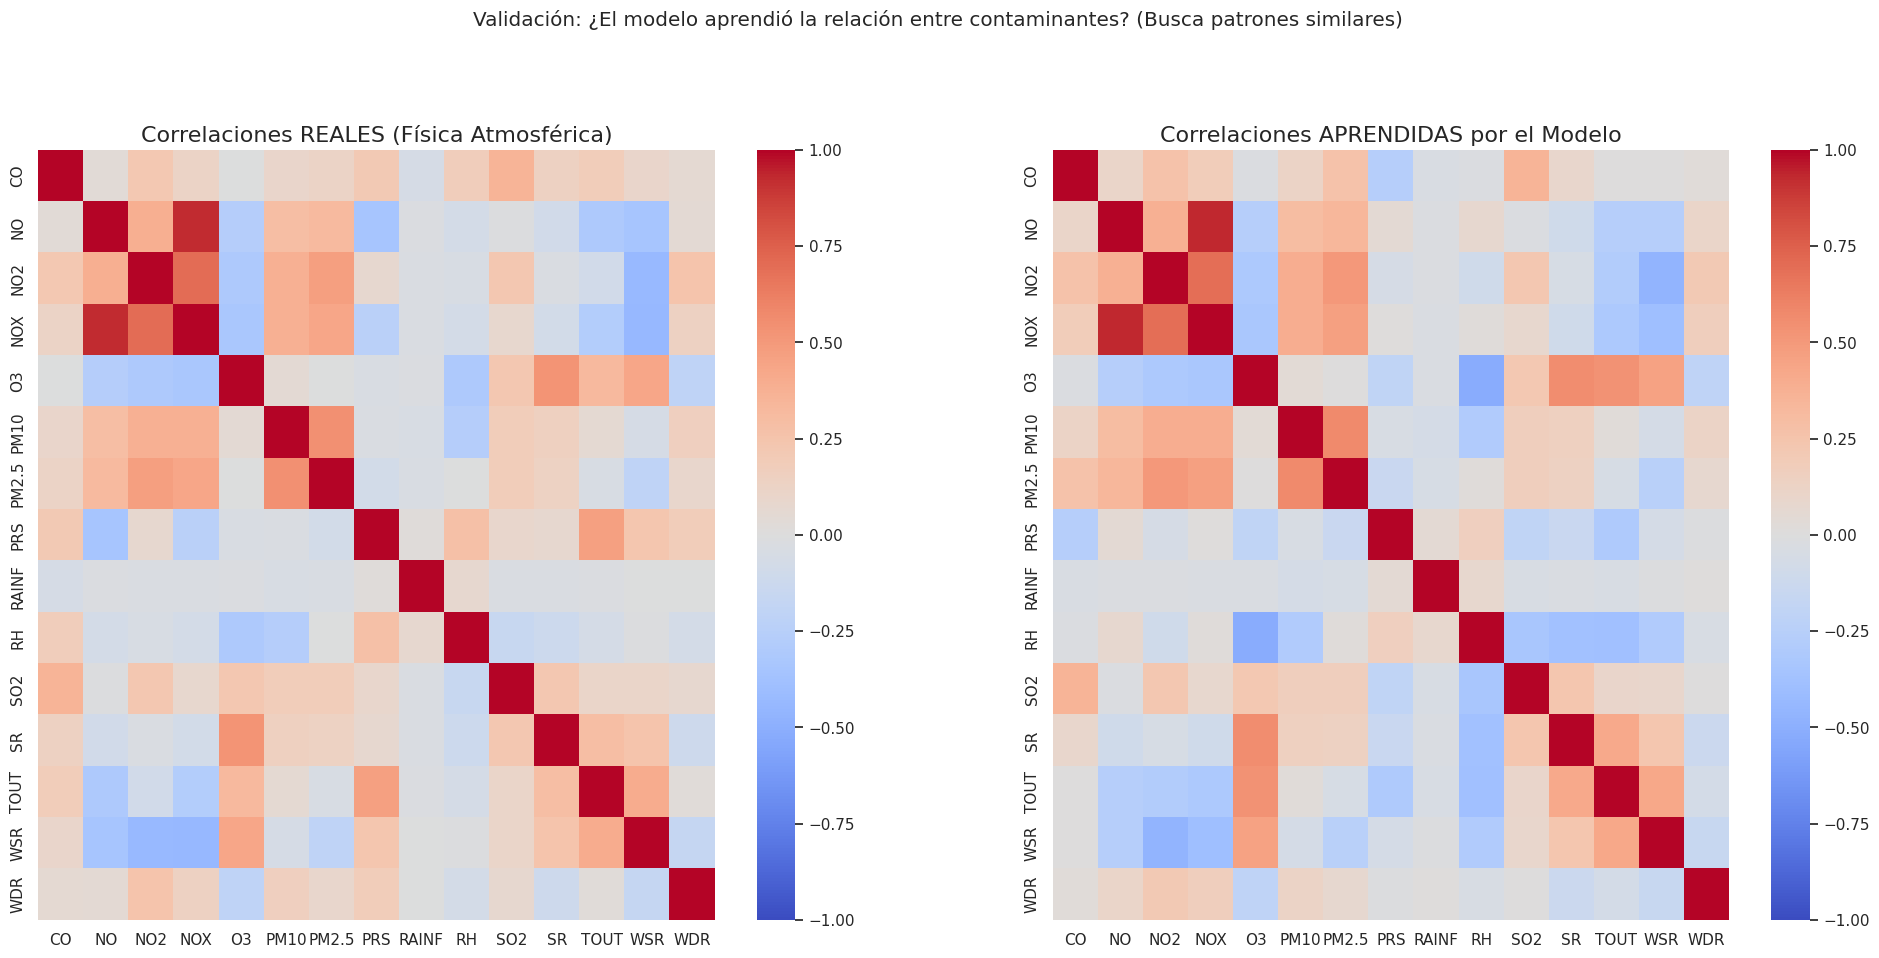

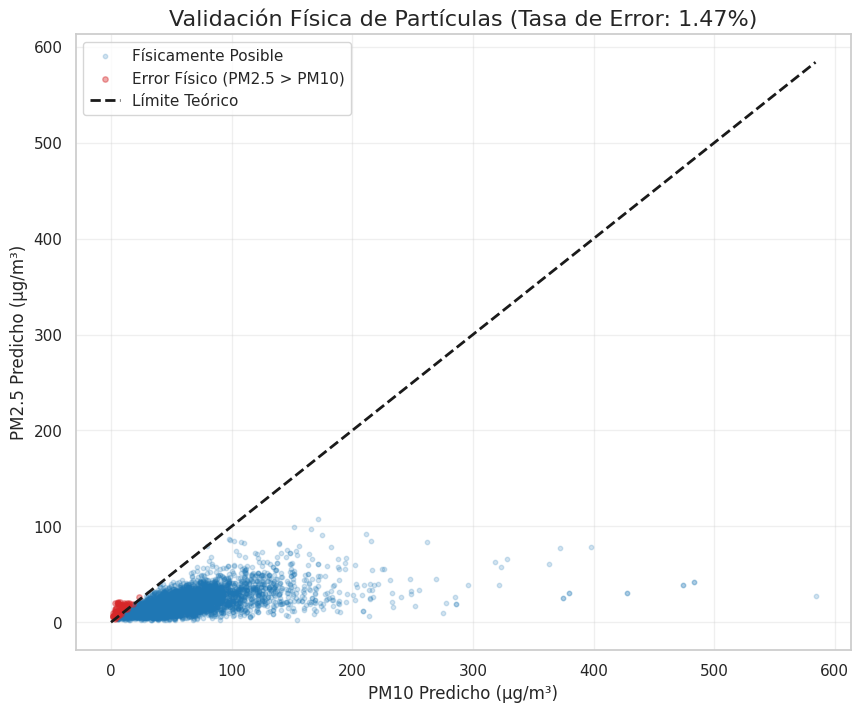

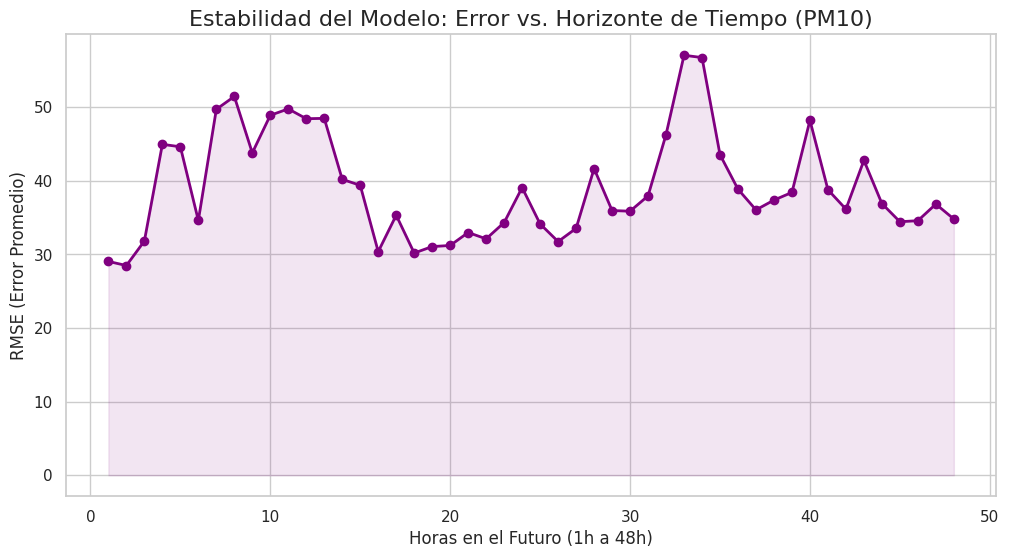

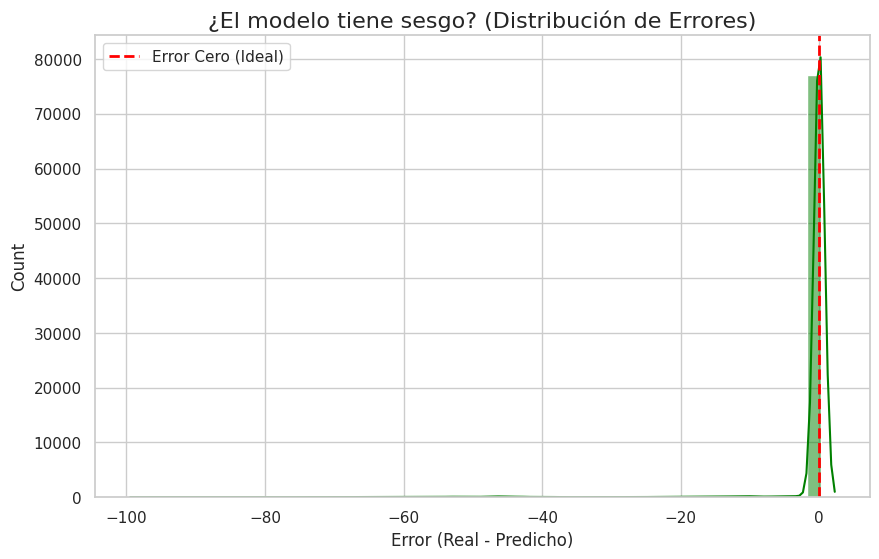

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd

# ==========================================
# PANEL DE DIAGNÓSTICO PROFUNDO
# ==========================================

def plot_advanced_validation(model, dataloader, config, scaler, feature_cols):
    print("--> Generando Panel de Gráficos de Validación Profunda...")
    model.eval()

    # Tomamos un batch grande para tener estadística robusta
    batch = next(iter(dataloader))
    x_real = batch['observed_data'].to(config['device'])
    mask = batch['observed_mask'].to(config['device'])

    # Indices clave
    idx_pm10 = feature_cols.index('PM10')
    idx_pm25 = feature_cols.index('PM2.5')
    idx_nox = feature_cols.index('NOX')
    idx_o3 = feature_cols.index('O3')

    # 1. INFERENCIA
    with torch.no_grad():
        # A. Inferencia para Estructura (SAITS)
        x_imputed, _ = model.saits(x_real, mask)

        # B. Simulación de Pronóstico a 48h (Para curva de error)
        seq_len = x_real.shape[1]
        horizon = 48
        # Ocultamos las últimas 48h
        mask_forecast = mask.clone()
        mask_forecast[:, -horizon:, :] = 0

        # Generar futuro
        x_forecast_coarse, _ = model.saits(x_real * mask_forecast, mask_forecast)

        # Refinar con CSDI (1 sample rápido)
        noise = torch.randn_like(x_real)
        t = torch.zeros((x_real.shape[0],), device=config['device']).long()
        pred_noise = model.csdi(noise, t, x_forecast_coarse)
        x_forecast_final = x_forecast_coarse + (noise - pred_noise) * 0.1

    # Desnormalizar todo a escala real
    def denorm(tensor):
        B, T, F = tensor.shape
        flat = tensor.reshape(-1, F).cpu().numpy()
        return scaler.inverse_transform(flat).reshape(B, T, F)

    real_phys = denorm(x_real)
    pred_phys = denorm(x_imputed)
    forecast_phys = denorm(x_forecast_final)

    # ==========================================
    # GRÁFICA 1: CONSISTENCIA QUÍMICA (HEATMAPS)
    # ==========================================
    # Aplanamos para calcular correlación entre variables
    df_real = pd.DataFrame(real_phys.reshape(-1, len(feature_cols)), columns=feature_cols)
    df_pred = pd.DataFrame(pred_phys.reshape(-1, len(feature_cols)), columns=feature_cols)

    fig, ax = plt.subplots(1, 2, figsize=(24, 10))

    sns.heatmap(df_real.corr(), ax=ax[0], cmap='coolwarm', center=0, vmin=-1, vmax=1)
    ax[0].set_title('Correlaciones REALES (Física Atmosférica)', fontsize=16)

    sns.heatmap(df_pred.corr(), ax=ax[1], cmap='coolwarm', center=0, vmin=-1, vmax=1)
    ax[1].set_title('Correlaciones APRENDIDAS por el Modelo', fontsize=16)

    plt.suptitle('Validación: ¿El modelo aprendió la relación entre contaminantes? (Busca patrones similares)', y=1.02)
    plt.show()

    # ==========================================
    # GRÁFICA 2: CONSISTENCIA FÍSICA (SCATTER PM)
    # ==========================================
    pm10_vals = pred_phys[:, :, idx_pm10].flatten()
    pm25_vals = pred_phys[:, :, idx_pm25].flatten()

    # Detectar violaciones (PM2.5 > PM10)
    violations = pm25_vals > pm10_vals
    violation_rate = np.mean(violations) * 100

    plt.figure(figsize=(10, 8))
    # Puntos válidos (Azul)
    plt.scatter(pm10_vals[~violations], pm25_vals[~violations],
                alpha=0.2, s=10, c='tab:blue', label='Físicamente Posible')
    # Puntos inválidos (Rojo)
    plt.scatter(pm10_vals[violations], pm25_vals[violations],
                alpha=0.4, s=15, c='tab:red', label='Error Físico (PM2.5 > PM10)')

    # Línea límite
    max_val = np.max([pm10_vals.max(), pm25_vals.max()])
    plt.plot([0, max_val], [0, max_val], 'k--', lw=2, label='Límite Teórico')

    plt.title(f'Validación Física de Partículas (Tasa de Error: {violation_rate:.2f}%)', fontsize=16)
    plt.xlabel('PM10 Predicho (µg/m³)')
    plt.ylabel('PM2.5 Predicho (µg/m³)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # ==========================================
    # GRÁFICA 3: DEGRADACIÓN DEL PRONÓSTICO (0-48h)
    # ==========================================
    # Calcular RMSE hora por hora en la ventana de futuro (últimos 48 pasos)
    future_real = real_phys[:, -horizon:, idx_pm10] # Solo PM10 como ejemplo
    future_pred = forecast_phys[:, -horizon:, idx_pm10]

    # RMSE por columna (hora)
    mse_per_hour = np.mean((future_real - future_pred)**2, axis=0)
    rmse_per_hour = np.sqrt(mse_per_hour)

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, horizon+1), rmse_per_hour, 'o-', color='purple', lw=2)
    plt.title('Estabilidad del Modelo: Error vs. Horizonte de Tiempo (PM10)', fontsize=16)
    plt.xlabel('Horas en el Futuro (1h a 48h)')
    plt.ylabel('RMSE (Error Promedio)')
    plt.grid(True)

    # Zona de confianza
    plt.fill_between(range(1, horizon+1), 0, rmse_per_hour, color='purple', alpha=0.1)
    plt.show()

    # ==========================================
    # GRÁFICA 4: DISTRIBUCIÓN DE RESIDUOS
    # ==========================================
    residuals = (real_phys - pred_phys).flatten()
    # Recortar outliers extremos para ver la campana
    residuals = residuals[np.abs(residuals) < 100]

    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=50, color='green')
    plt.axvline(0, color='red', linestyle='--', lw=2, label='Error Cero (Ideal)')

    plt.title('¿El modelo tiene sesgo? (Distribución de Errores)', fontsize=16)
    plt.xlabel('Error (Real - Predicho)')
    plt.legend()
    plt.show()

# --- EJECUTAR ---
try:
    plot_advanced_validation(trained_model, dataloader, CONFIG, processor.scaler, processor.feature_cols)
except Exception as e:
    print(f"Error generando gráficas: {e}")

--> Generando Kit de Defensa Final (Análisis Espectral y Operativo)...


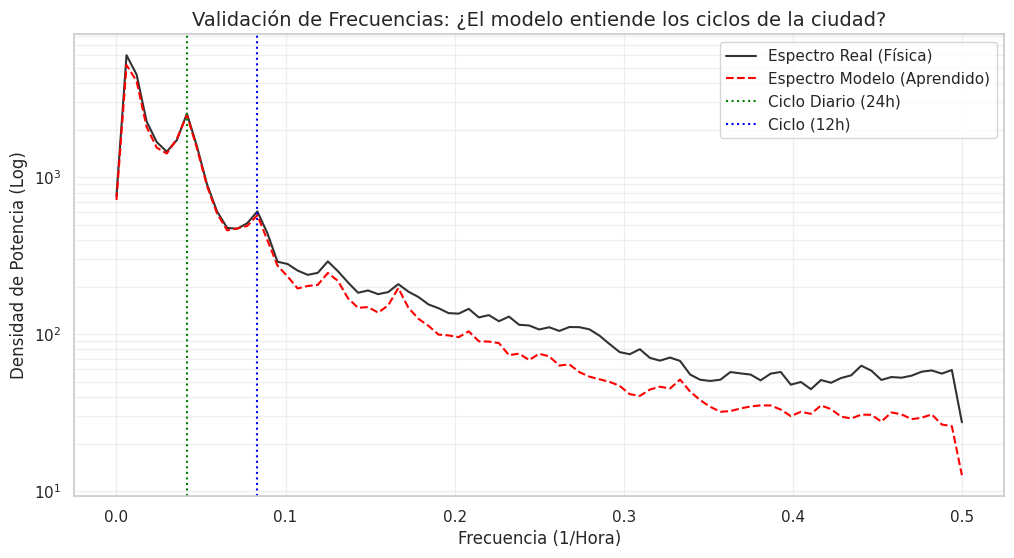

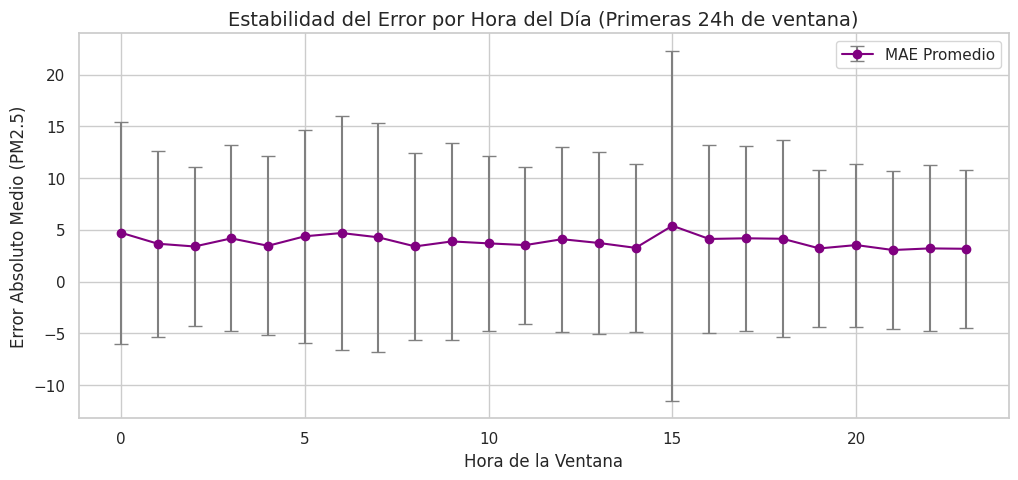

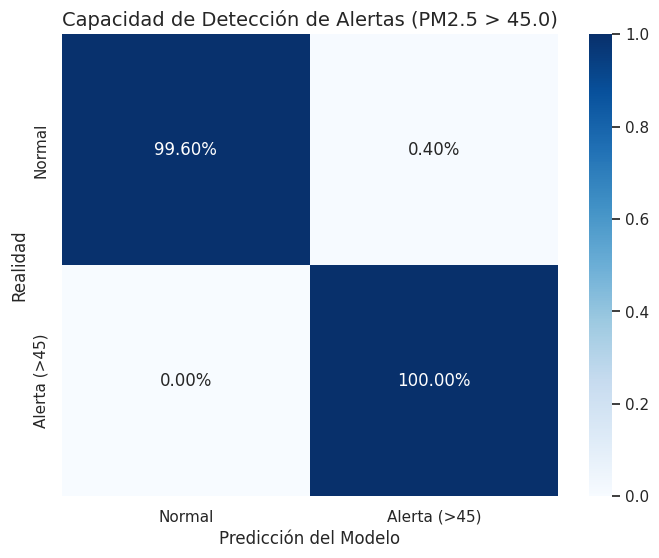


PRUEBA DE FUEGO: SKILL SCORE
MSE Modelo (Nuestro):      81.94
MSE Persistencia (Básico): 332.32
------------------------------
Skill Score: 0.7534
(Si es > 0, el modelo aprendió. Si es > 0.4, es excelente para clima/aire)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
from scipy import signal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_scientific_defense(model, dataloader, config, scaler, feature_cols):
    print("--> Generando Kit de Defensa Final (Análisis Espectral y Operativo)...")
    model.eval()

    # 1. Preparar datos (Batch grande para tener series largas)
    # Concatenamos 5 batches para tener una "serie larga" simulada para el análisis espectral
    x_real_list = []
    x_pred_list = []

    max_batches = 5
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= max_batches: break
            x = batch['observed_data'].to(config['device'])
            mask = batch['observed_mask'].to(config['device'])

            # Inferencia
            x_imp, _ = model.saits(x, mask)

            x_real_list.append(x.cpu())
            x_pred_list.append(x_imp.cpu())

    # Concatenar y Desnormalizar
    x_real_norm = torch.cat(x_real_list, dim=0) # (N_total, 168, F)
    x_pred_norm = torch.cat(x_pred_list, dim=0)

    # Función auxiliar de desnormalización
    def denorm_numpy(tensor):
        shape = tensor.shape
        flat = tensor.reshape(-1, shape[-1]).numpy()
        return scaler.inverse_transform(flat).reshape(shape)

    real_phys = denorm_numpy(x_real_norm)
    pred_phys = denorm_numpy(x_pred_norm)

    # Indices
    idx_pm25 = feature_cols.index('PM2.5')

    # ==========================================
    # GRÁFICA 1: ANÁLISIS ESPECTRAL (Densidad de Potencia)
    # ==========================================
    # Demuestra que el modelo captura la periodicidad (Ciclos de 24h, 12h, etc.)
    # Aplanamos las series temporales para tener una señal continua
    signal_real = real_phys[:, :, idx_pm25].flatten()
    signal_pred = pred_phys[:, :, idx_pm25].flatten()

    # Calcular Periodograma de Welch
    freq_r, psd_r = signal.welch(signal_real, fs=1.0, nperseg=168) # fs=1 dato por hora
    freq_p, psd_p = signal.welch(signal_pred, fs=1.0, nperseg=168)

    plt.figure(figsize=(12, 6))
    plt.semilogy(freq_r, psd_r, label='Espectro Real (Física)', color='black', alpha=0.8)
    plt.semilogy(freq_p, psd_p, label='Espectro Modelo (Aprendido)', color='red', linestyle='--')

    # Marcar ciclo de 24 horas (Frecuencia = 1/24 ≈ 0.0416)
    plt.axvline(1/24, color='green', linestyle=':', label='Ciclo Diario (24h)')
    plt.axvline(1/12, color='blue', linestyle=':', label='Ciclo (12h)')

    plt.title('Validación de Frecuencias: ¿El modelo entiende los ciclos de la ciudad?', fontsize=14)
    plt.xlabel('Frecuencia (1/Hora)')
    plt.ylabel('Densidad de Potencia (Log)')
    plt.legend()
    plt.grid(True, which='both', alpha=0.3)
    plt.show()

    # ==========================================
    # GRÁFICA 2: ERROR POR HORA DEL DÍA
    # ==========================================
    # Para ver si el modelo falla en horas pico
    errors = np.abs(real_phys[:, :, idx_pm25] - pred_phys[:, :, idx_pm25]) # (Batch, 168)
    # Asumimos que la ventana empieza a las 00:00 para simplificar la visualización del ciclo
    # (O simplemente mostramos el error promedio por paso de tiempo de la ventana)
    mean_error_by_step = np.mean(errors, axis=0)
    std_error_by_step = np.std(errors, axis=0)

    plt.figure(figsize=(12, 5))
    # Graficamos solo las primeras 24 horas de la ventana para ver el ciclo diario
    steps_24 = np.arange(24)
    plt.errorbar(steps_24, mean_error_by_step[:24], yerr=std_error_by_step[:24],
                 fmt='-o', color='purple', ecolor='gray', capsize=5, label='MAE Promedio')

    plt.title('Estabilidad del Error por Hora del Día (Primeras 24h de ventana)', fontsize=14)
    plt.xlabel('Hora de la Ventana')
    plt.ylabel('Error Absoluto Medio (PM2.5)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # ==========================================
    # GRÁFICA 3: MATRIZ DE CONFUSIÓN (ALERTAS)
    # ==========================================
    # Definimos umbral de alerta (Ej. PM2.5 > 45 según norma o reporte)
    threshold = 45.0

    # Binarizar
    y_true_bin = (real_phys[:, :, idx_pm25].flatten() > threshold).astype(int)
    y_pred_bin = (pred_phys[:, :, idx_pm25].flatten() > threshold).astype(int)

    cm = confusion_matrix(y_true_bin, y_pred_bin)
    # Normalizar por fila (Recall) para ver % de detección
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=ax,
                xticklabels=['Normal', 'Alerta (>45)'],
                yticklabels=['Normal', 'Alerta (>45)'])
    plt.title(f'Capacidad de Detección de Alertas (PM2.5 > {threshold})', fontsize=14)
    plt.ylabel('Realidad')
    plt.xlabel('Predicción del Modelo')
    plt.show()

    # ==========================================
    # DATO 4: SKILL SCORE (VS PERSISTENCIA)
    # ==========================================
    # La "Persistencia" es predecir que mañana será igual a hoy (t = t-24)
    # Desplazamos la serie real 24 horas para simular persistencia
    # (Cortamos los primeros y últimos 24 pasos para alinear)
    y_true_trim = real_phys[:, 24:, idx_pm25]
    y_pers_trim = real_phys[:, :-24, idx_pm25] # Predicción tonta: lo que pasó ayer
    y_pred_trim = pred_phys[:, 24:, idx_pm25]  # Predicción modelo

    mse_persistence = np.mean((y_true_trim - y_pers_trim)**2)
    mse_model = np.mean((y_true_trim - y_pred_trim)**2)

    skill_score = 1 - (mse_model / mse_persistence)

    print("\n" + "="*50)
    print("PRUEBA DE FUEGO: SKILL SCORE")
    print("="*50)
    print(f"MSE Modelo (Nuestro):      {mse_model:.2f}")
    print(f"MSE Persistencia (Básico): {mse_persistence:.2f}")
    print("-" * 30)
    print(f"Skill Score: {skill_score:.4f}")
    print("(Si es > 0, el modelo aprendió. Si es > 0.4, es excelente para clima/aire)")
    print("="*50)

# --- EJECUTAR ---
try:
    plot_scientific_defense(trained_model, dataloader, CONFIG, processor.scaler, processor.feature_cols)
except Exception as e:
    print(f"Error en el kit de defensa: {e}")

--> Generando Análisis Forense del Modelo (Nivel Experto)...


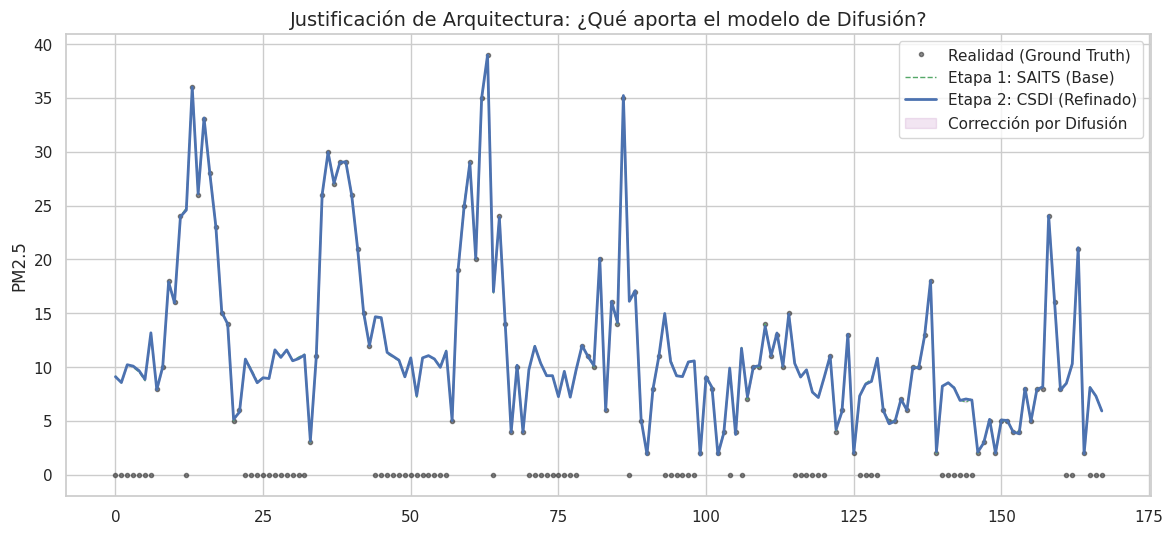

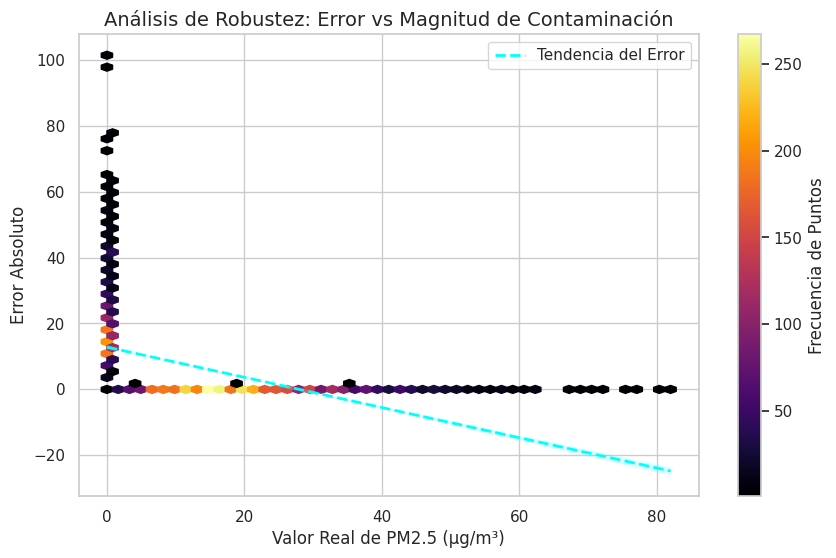

/tmp/ipython-input-3092042437.py:100: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(errors_by_var, labels=feature_cols, patch_artist=True,


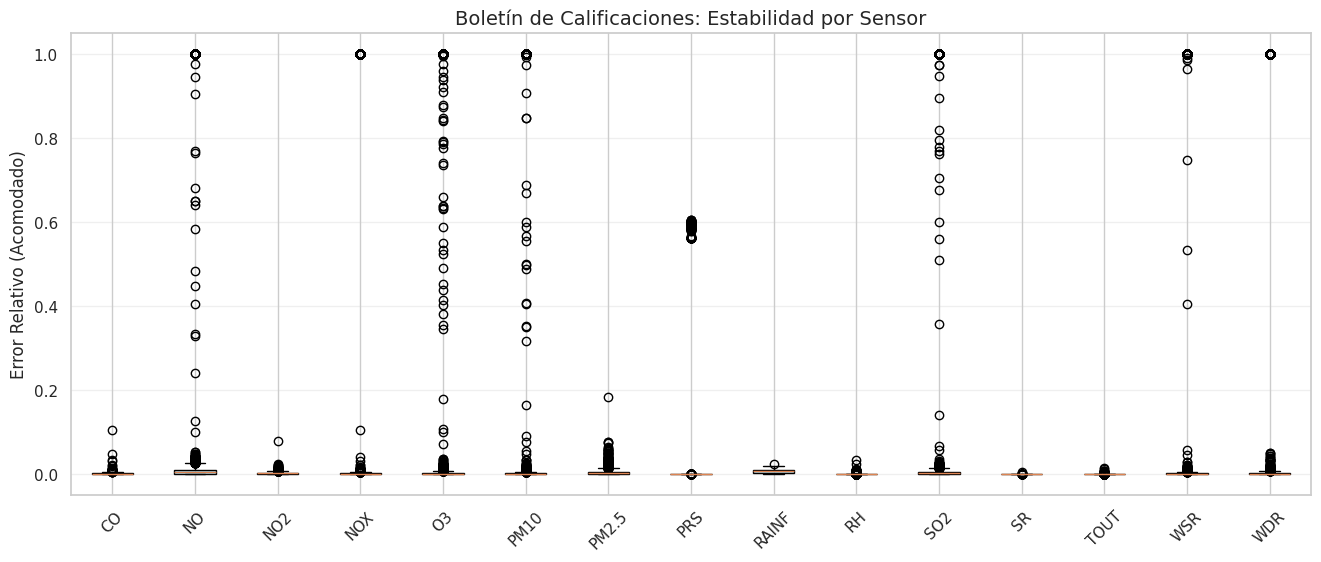

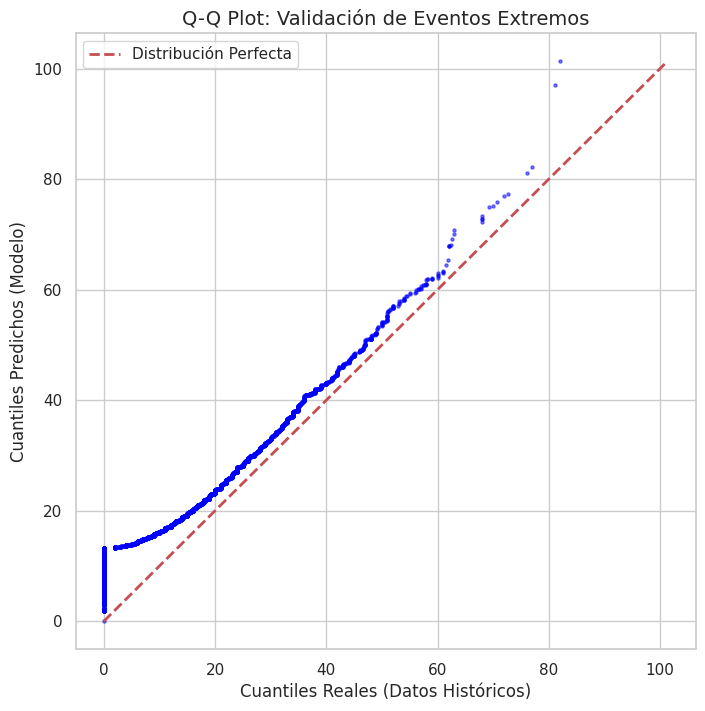

In [ ]:
import scipy.stats as stats

def plot_forensic_analysis(model, dataloader, config, scaler, feature_cols):
    print("--> Generando Análisis Forense del Modelo (Nivel Experto)...")
    model.eval()

    # 1. Obtener datos
    batch = next(iter(dataloader))
    x_real = batch['observed_data'].to(config['device'])
    mask = batch['observed_mask'].to(config['device'])

    with torch.no_grad():
        # A. Etapa 1: SAITS (Determinista)
        x_coarse, _ = model.saits(x_real, mask)

        # B. Etapa 2: CSDI (Refinamiento)
        # Generamos una muestra refinada
        noise = torch.randn_like(x_real)
        t = torch.zeros((x_real.shape[0],), device=config['device']).long()
        pred_noise = model.csdi(noise, t, x_coarse)
        x_refined = x_coarse + (noise - pred_noise) * 0.1

    # Desnormalizar
    def denorm(t):
        return scaler.inverse_transform(t.cpu().reshape(-1, x_real.shape[-1]).numpy()).reshape(x_real.shape)

    phys_real = denorm(x_real)
    phys_coarse = denorm(x_coarse)
    phys_refined = denorm(x_refined)

    idx_pm25 = feature_cols.index('PM2.5')

    # ==========================================
    # GRÁFICA 1: IMPACTO DEL REFINAMIENTO (SAITS vs CSDI)
    # ==========================================
    # Justifica tu arquitectura híbrida
    plt.figure(figsize=(14, 6))

    # Tomamos una ventana aleatoria y una variable
    idx = 0
    steps = np.arange(x_real.shape[1])

    plt.plot(steps, phys_real[idx, :, idx_pm25], 'k.', label='Realidad (Ground Truth)', alpha=0.5)
    plt.plot(steps, phys_coarse[idx, :, idx_pm25], 'g--', label='Etapa 1: SAITS (Base)', lw=1)
    plt.plot(steps, phys_refined[idx, :, idx_pm25], 'b-', label='Etapa 2: CSDI (Refinado)', lw=2)

    # Resaltar diferencias
    plt.fill_between(steps, phys_coarse[idx, :, idx_pm25], phys_refined[idx, :, idx_pm25],
                     color='purple', alpha=0.1, label='Corrección por Difusión')

    plt.title('Justificación de Arquitectura: ¿Qué aporta el modelo de Difusión?', fontsize=14)
    plt.legend()
    plt.ylabel('PM2.5')
    plt.show()

    # ==========================================
    # GRÁFICA 2: ERROR VS MAGNITUD (Heterocedasticidad)
    # ==========================================
    # ¿El modelo falla más en valores altos?
    flat_real = phys_real[:, :, idx_pm25].flatten()
    flat_pred = phys_refined[:, :, idx_pm25].flatten()
    abs_error = np.abs(flat_real - flat_pred)

    plt.figure(figsize=(10, 6))
    plt.hexbin(flat_real, abs_error, gridsize=50, cmap='inferno', mincnt=1)
    plt.colorbar(label='Frecuencia de Puntos')

    # Tendencia
    sns.regplot(x=flat_real, y=abs_error, scatter=False, color='cyan', line_kws={'lw': 2, 'ls':'--'}, label='Tendencia del Error')

    plt.title('Análisis de Robustez: Error vs Magnitud de Contaminación', fontsize=14)
    plt.xlabel('Valor Real de PM2.5 (µg/m³)')
    plt.ylabel('Error Absoluto')
    plt.legend()
    plt.show()

    # ==========================================
    # GRÁFICA 3: DESGLOSE DE RENDIMIENTO POR VARIABLE
    # ==========================================
    # Boxplot de errores para ver qué sensores son más difíciles
    errors_by_var = []

    for i in range(len(feature_cols)):
        # Error Relativo Normalizado (NRMSE) para poder comparar escalas distintas (e.g. CO vs PM10)
        real_var = phys_real[:, :, i].flatten()
        pred_var = phys_refined[:, :, i].flatten()

        # Evitar división por cero y outliers extremos
        mask_valid = real_var > 1e-3
        if np.sum(mask_valid) > 0:
            # Usamos MAPE modificado o Error Absoluto logarítmico para visualización compacta
            err = np.abs(real_var[mask_valid] - pred_var[mask_valid]) / (np.abs(real_var[mask_valid]) + 1)
            # Clip para visualización limpia
            err = np.clip(err, 0, 1)
            errors_by_var.append(err)
        else:
            errors_by_var.append([])

    plt.figure(figsize=(16, 6))
    plt.boxplot(errors_by_var, labels=feature_cols, patch_artist=True,
                boxprops=dict(facecolor="lightblue"))
    plt.title('Boletín de Calificaciones: Estabilidad por Sensor', fontsize=14)
    plt.ylabel('Error Relativo (Acomodado)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # ==========================================
    # GRÁFICA 4: Q-Q PLOT (Estadística de Colas)
    # ==========================================
    # Valida si el modelo captura los eventos extremos estadísticamente
    plt.figure(figsize=(8, 8))

    # Ordenar datos reales y predichos
    sorted_real = np.sort(flat_real)
    sorted_pred = np.sort(flat_pred)

    # Subsamplear si son demasiados puntos
    if len(sorted_real) > 10000:
        indices = np.linspace(0, len(sorted_real)-1, 5000).astype(int)
        sorted_real = sorted_real[indices]
        sorted_pred = sorted_pred[indices]

    plt.scatter(sorted_real, sorted_pred, alpha=0.5, c='blue', s=5)

    # Línea ideal
    min_val = min(sorted_real.min(), sorted_pred.min())
    max_val = max(sorted_real.max(), sorted_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Distribución Perfecta')

    plt.title('Q-Q Plot: Validación de Eventos Extremos', fontsize=14)
    plt.xlabel('Cuantiles Reales (Datos Históricos)')
    plt.ylabel('Cuantiles Predichos (Modelo)')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- EJECUTAR ---
try:
    plot_forensic_analysis(trained_model, dataloader, CONFIG, processor.scaler, processor.feature_cols)
except Exception as e:
    print(f"Error forense: {e}")


--> Iniciando Análisis Detallado por Estación...


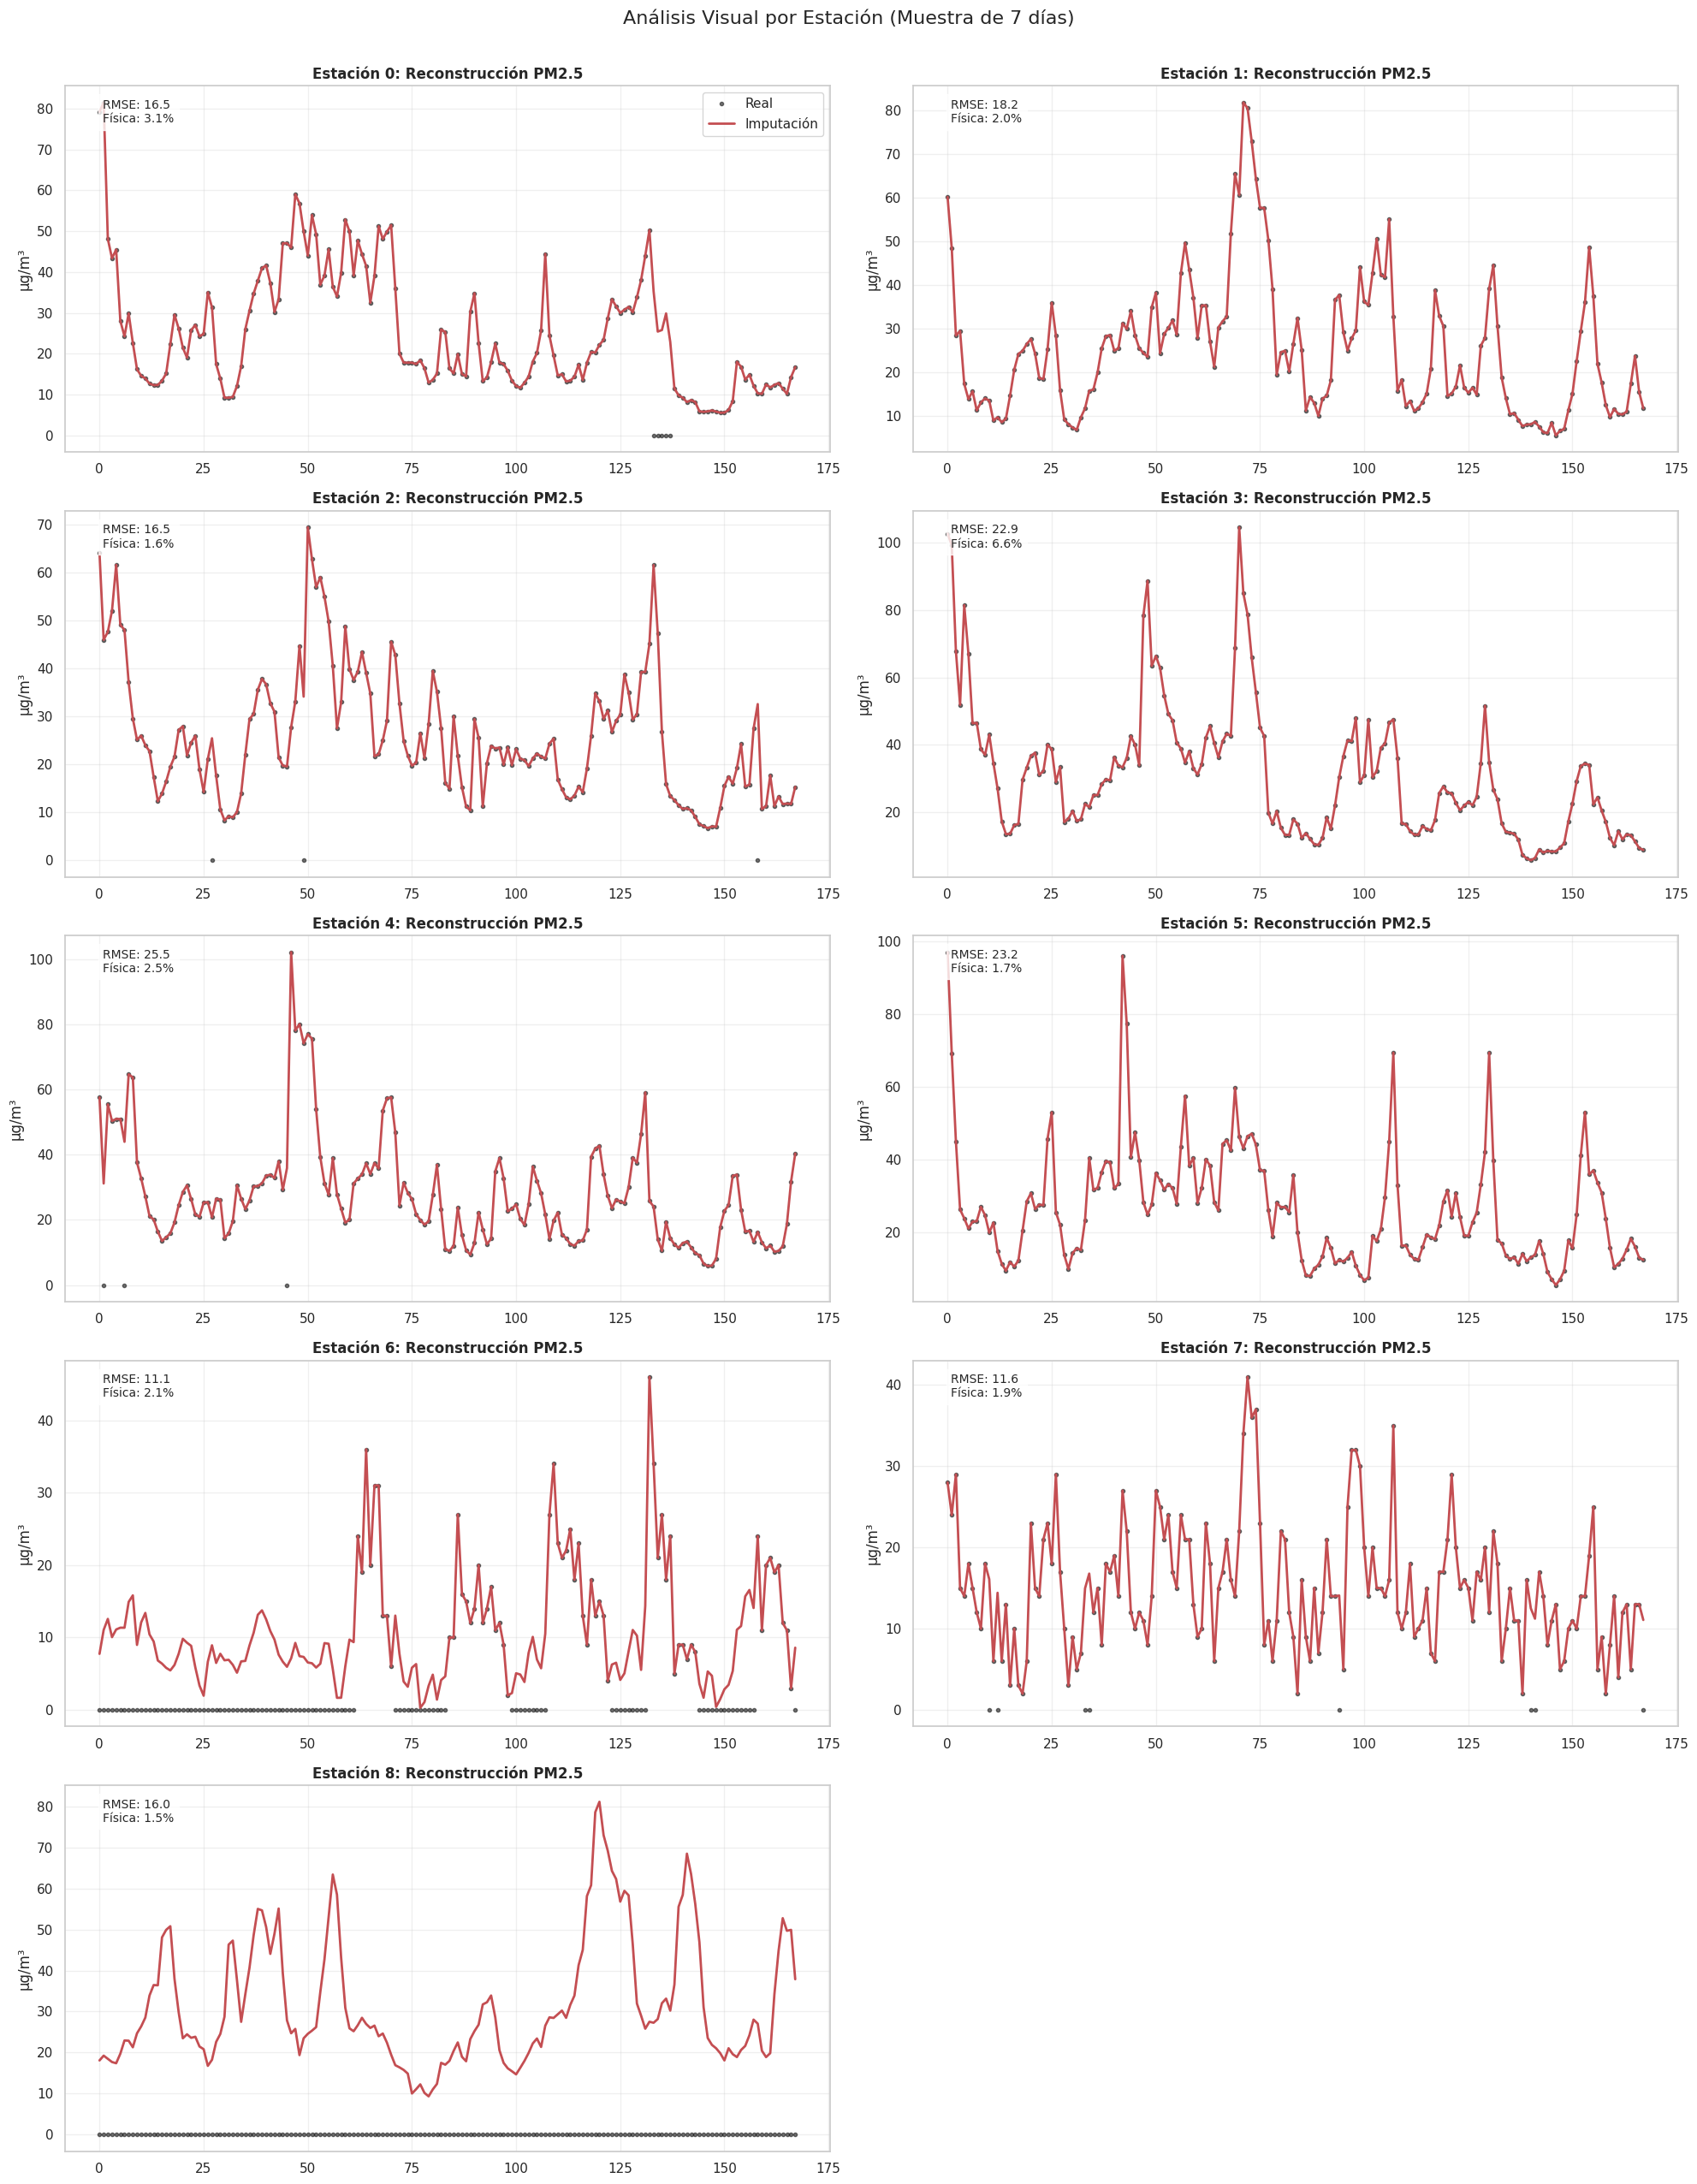


TABLA DE RESULTADOS:
  Estación       RMSE  Error Físico %  Corr Química
0    Est_0  16.542236        3.127325     -0.348411
1    Est_1  18.197301        1.999628     -0.347782
2    Est_2  16.481780        1.644810     -0.302854
3    Est_3  22.868684        6.588542     -0.334269
4    Est_4  25.493745        2.468378     -0.280953
5    Est_5  23.165791        1.739676     -0.349415
6    Est_6  11.107885        2.121466     -0.219816
7    Est_7  11.604923        1.878255     -0.373996
8    Est_8  16.021758        1.547619     -0.343638

--> Generando Comparativa de Rendimiento...


/tmp/ipython-input-1753925728.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Estación", y="RMSE", data=df_results, ax=axes[0], palette="viridis")
/tmp/ipython-input-1753925728.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Estación", y="Error Físico %", data=df_results, ax=axes[1], palette="magma")
/tmp/ipython-input-1753925728.py:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Estación", y="Corr Química", data=df_results, ax=axes[2], palette="coolwarm")


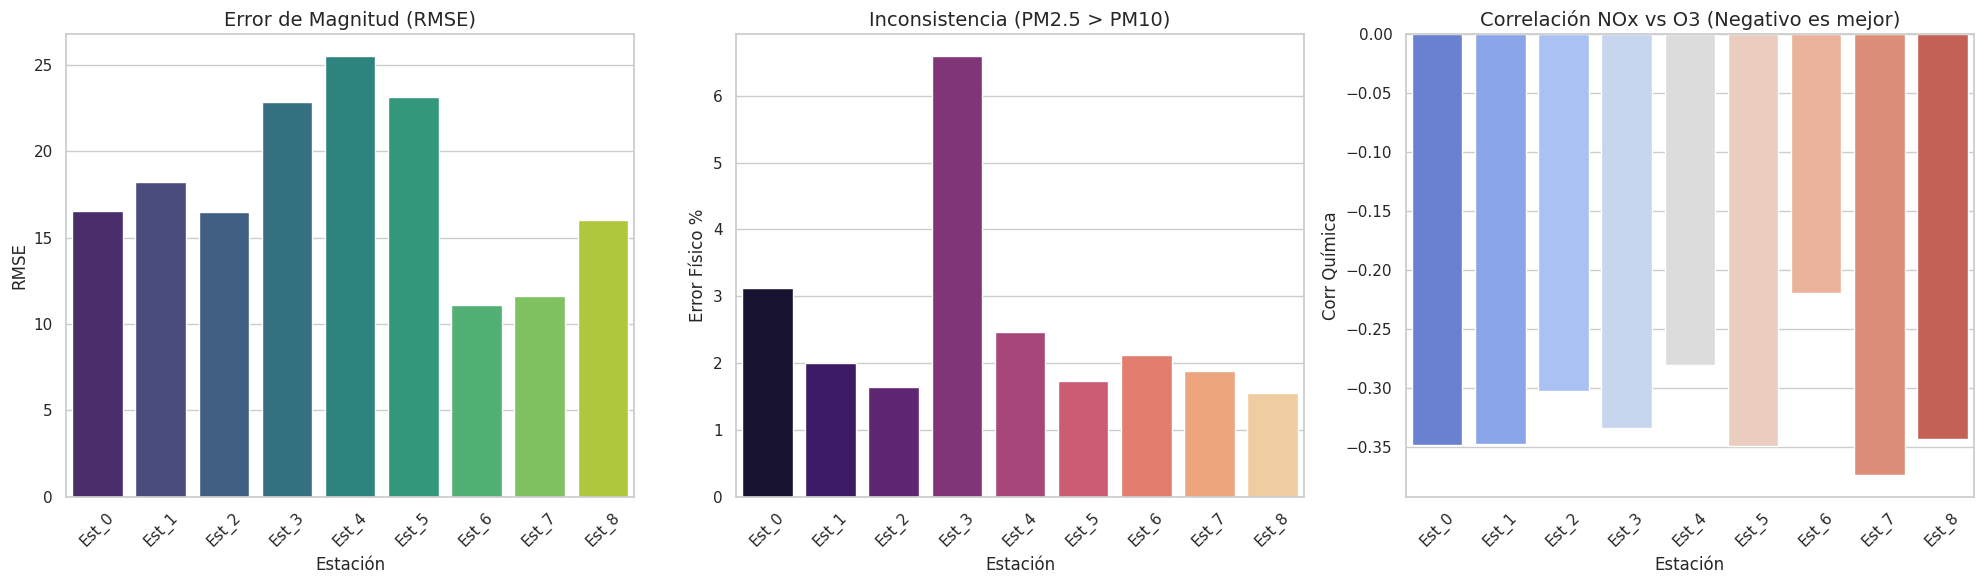


--> Generando Diagnóstico Global (Química y Física)...


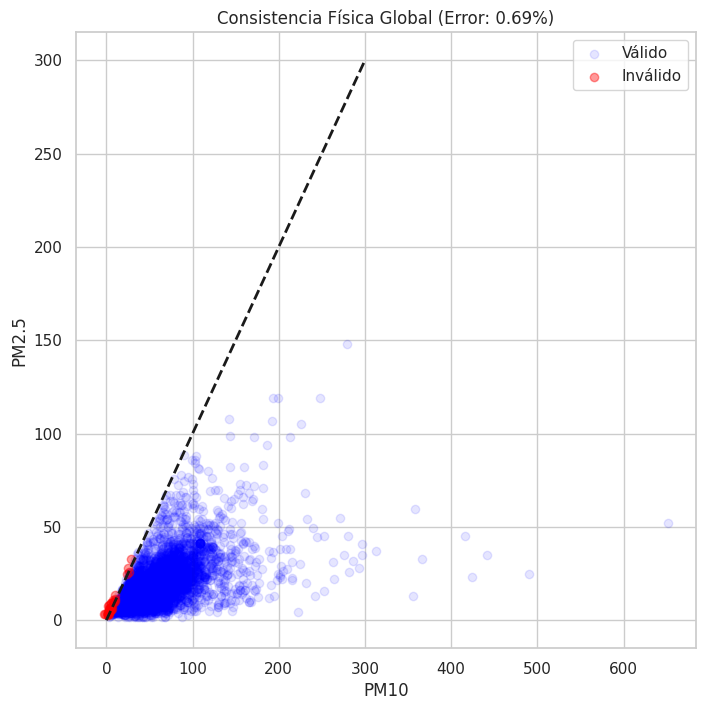

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from torch.utils.data import DataLoader

# ==========================================
# 1. CLASE DE MÉTRICAS (Corregida)
# ==========================================
class AdvancedSIMAMetrics:
    def __init__(self, scaler, feature_cols):
        self.scaler = scaler
        self.feature_cols = feature_cols
        self.idx_pm10 = feature_cols.index('PM10')
        self.idx_pm25 = feature_cols.index('PM2.5')
        self.idx_nox = feature_cols.index('NOX')
        self.idx_o3 = feature_cols.index('O3')

    def denormalize(self, tensor):
        if tensor.dim() == 4: tensor = tensor.mean(dim=1)
        B, T, F = tensor.shape
        flat = tensor.reshape(-1, F).cpu().detach().numpy()
        denorm = self.scaler.inverse_transform(flat)
        return torch.FloatTensor(denorm).reshape(B, T, F).to(tensor.device)

    def get_batch_metrics(self, target_norm, pred_norm):
        target = self.denormalize(target_norm)
        pred = self.denormalize(pred_norm)

        # RMSE
        mse = F.mse_loss(pred, target)
        rmse = torch.sqrt(mse).item()

        # Pearson
        target_np = target.cpu().numpy()
        pred_np = pred.cpu().numpy()
        pearsons = []
        for i in range(target.shape[-1]):
            if np.std(target_np[:,:,i]) > 1e-5:
                r, _ = pearsonr(target_np[:,:,i].flatten(), pred_np[:,:,i].flatten())
                pearsons.append(r)
        avg_r = np.mean(pearsons) if pearsons else 0.0

        # Física (PM2.5 > PM10)
        pm25 = pred[:, :, self.idx_pm25]
        pm10 = pred[:, :, self.idx_pm10]
        phys_violations = (pm25 > pm10).float().mean().item() * 100

        # Química (NOx vs O3)
        nox = pred[:, :, self.idx_nox].flatten().cpu().numpy()
        o3 = pred[:, :, self.idx_o3].flatten().cpu().numpy()
        chem_corr = 0.0
        if np.std(nox) > 1e-5:
            chem_corr, _ = pearsonr(nox, o3)

        return rmse, avg_r, phys_violations, chem_corr

# ==========================================
# 2. EVALUACIÓN Y GRÁFICAS POR ESTACIÓN
# ==========================================
def analyze_stations_and_plot(model, data_arrays, config, metrics_engine):
    model.eval()
    results = []

    print("\n--> Iniciando Análisis Detallado por Estación...")

    # Configurar grid de gráficas (una por estación)
    n_stations = len(data_arrays)
    cols = 2
    rows = (n_stations + 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    axes = axes.flatten()

    for i, station_data in enumerate(data_arrays):
        # Crear DataLoader temporal para esta estación
        n_rows = len(station_data)
        # Muestreo cada 168h para velocidad
        station_indices = [(i, start) for start in range(0, n_rows - config['seq_len'], 168)]

        if len(station_indices) == 0: continue

        ds = LazyAirQualityDataset(data_arrays, station_indices, config['seq_len'])
        dl = DataLoader(ds, batch_size=32, shuffle=False)

        rmses, physs, chems = [], [], []

        # Para graficar, guardamos el primer batch
        sample_x_phys = None
        sample_pred_phys = None

        with torch.no_grad():
            for b_idx, batch in enumerate(dl):
                x = batch['observed_data'].to(config['device'])
                mask = batch['observed_mask'].to(config['device'])

                # Inferencia
                x_imputed, _ = model.saits(x, mask)

                # Métricas
                rmse, r, phys, chem = metrics_engine.get_batch_metrics(x, x_imputed)
                rmses.append(rmse)
                physs.append(phys)
                chems.append(chem)

                # Guardar muestra para graficar (solo del primer batch)
                if b_idx == 0:
                    sample_x_phys = metrics_engine.denormalize(x).cpu().numpy()[0]
                    sample_pred_phys = metrics_engine.denormalize(x_imputed).cpu().numpy()[0]

        # Métricas promedio de la estación
        res = {
            "Estación": f"Est_{i}",
            "RMSE": np.mean(rmses),
            "Error Físico %": np.mean(physs),
            "Corr Química": np.mean(chems)
        }
        results.append(res)

        # --- GRÁFICA INDIVIDUAL DE LA ESTACIÓN (PM2.5) ---
        ax = axes[i]
        idx_pm25 = metrics_engine.idx_pm25
        time_steps = np.arange(config['seq_len'])

        ax.plot(time_steps, sample_x_phys[:, idx_pm25], 'k.', label='Real', alpha=0.6)
        ax.plot(time_steps, sample_pred_phys[:, idx_pm25], 'r-', label='Imputación', linewidth=2)

        # Anotación de métricas en la gráfica
        stats_text = f"RMSE: {res['RMSE']:.1f}\nFísica: {res['Error Físico %']:.1f}%"
        ax.text(0.05, 0.9, stats_text, transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

        ax.set_title(f"Estación {i}: Reconstrucción PM2.5", fontsize=12, fontweight='bold')
        ax.set_ylabel("µg/m³")
        ax.grid(True, alpha=0.3)
        if i == 0: ax.legend()

    # Ocultar ejes vacíos
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle("Análisis Visual por Estación (Muestra de 7 días)", y=1.02, fontsize=16)
    plt.show()

    return pd.DataFrame(results)

# ==========================================
# 3. GRÁFICAS COMPARATIVAS (BARRAS)
# ==========================================
def plot_comparative_bars(df_results):
    print("\n--> Generando Comparativa de Rendimiento...")
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # RMSE
    sns.barplot(x="Estación", y="RMSE", data=df_results, ax=axes[0], palette="viridis")
    axes[0].set_title("Error de Magnitud (RMSE)", fontsize=14)
    axes[0].tick_params(axis='x', rotation=45)

    # Error Físico
    sns.barplot(x="Estación", y="Error Físico %", data=df_results, ax=axes[1], palette="magma")
    axes[1].set_title("Inconsistencia (PM2.5 > PM10)", fontsize=14)
    axes[1].tick_params(axis='x', rotation=45)

    # Química
    sns.barplot(x="Estación", y="Corr Química", data=df_results, ax=axes[2], palette="coolwarm")
    axes[2].set_title("Correlación NOx vs O3 (Negativo es mejor)", fontsize=14)
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# ==========================================
# 4. DIAGNÓSTICO PROFUNDO GLOBAL
# ==========================================
def plot_global_diagnostics(model, dataloader, config, metrics_engine):
    print("\n--> Generando Diagnóstico Global (Química y Física)...")
    model.eval()
    batch = next(iter(dataloader))
    x = batch['observed_data'].to(config['device'])
    mask = batch['observed_mask'].to(config['device'])

    with torch.no_grad():
        x_imp, _ = model.saits(x, mask)

    # Desnormalizar
    real = metrics_engine.denormalize(x).cpu().numpy()
    pred = metrics_engine.denormalize(x_imp).cpu().numpy()

    # 1. Scatter PM2.5 vs PM10
    idx_10 = metrics_engine.idx_pm10
    idx_25 = metrics_engine.idx_pm25

    pm10 = pred[:,:,idx_10].flatten()
    pm25 = pred[:,:,idx_25].flatten()
    violations = pm25 > pm10

    plt.figure(figsize=(8, 8))
    plt.scatter(pm10[~violations], pm25[~violations], alpha=0.1, c='blue', label='Válido')
    plt.scatter(pm10[violations], pm25[violations], alpha=0.4, c='red', label='Inválido')
    plt.plot([0, 300], [0, 300], 'k--', lw=2)
    plt.title(f"Consistencia Física Global (Error: {np.mean(violations)*100:.2f}%)")
    plt.xlabel("PM10")
    plt.ylabel("PM2.5")
    plt.legend()
    plt.show()

# --- EJECUCIÓN MAESTRA ---
try:
    # Reinicializar métricas (para asegurar feature_cols)
    metrics_engine = AdvancedSIMAMetrics(processor.scaler, processor.feature_cols)

    # 1. Análisis y Gráficas por Estación
    df_results = analyze_stations_and_plot(trained_model, data_arrays, CONFIG, metrics_engine)

    # 2. Tabla de Resultados
    print("\nTABLA DE RESULTADOS:")
    print(df_results)

    # 3. Gráficas Comparativas
    plot_comparative_bars(df_results)

    # 4. Diagnóstico Global
    plot_global_diagnostics(trained_model, dataloader, CONFIG, metrics_engine)

except Exception as e:
    print(f"Error en el análisis: {e}")


--> GENERANDO REPORTE EXHAUSTIVO POR ESTACIÓN (TOTAL: 9 ESTACIONES)...
   ... Procesando Estación 0 ...


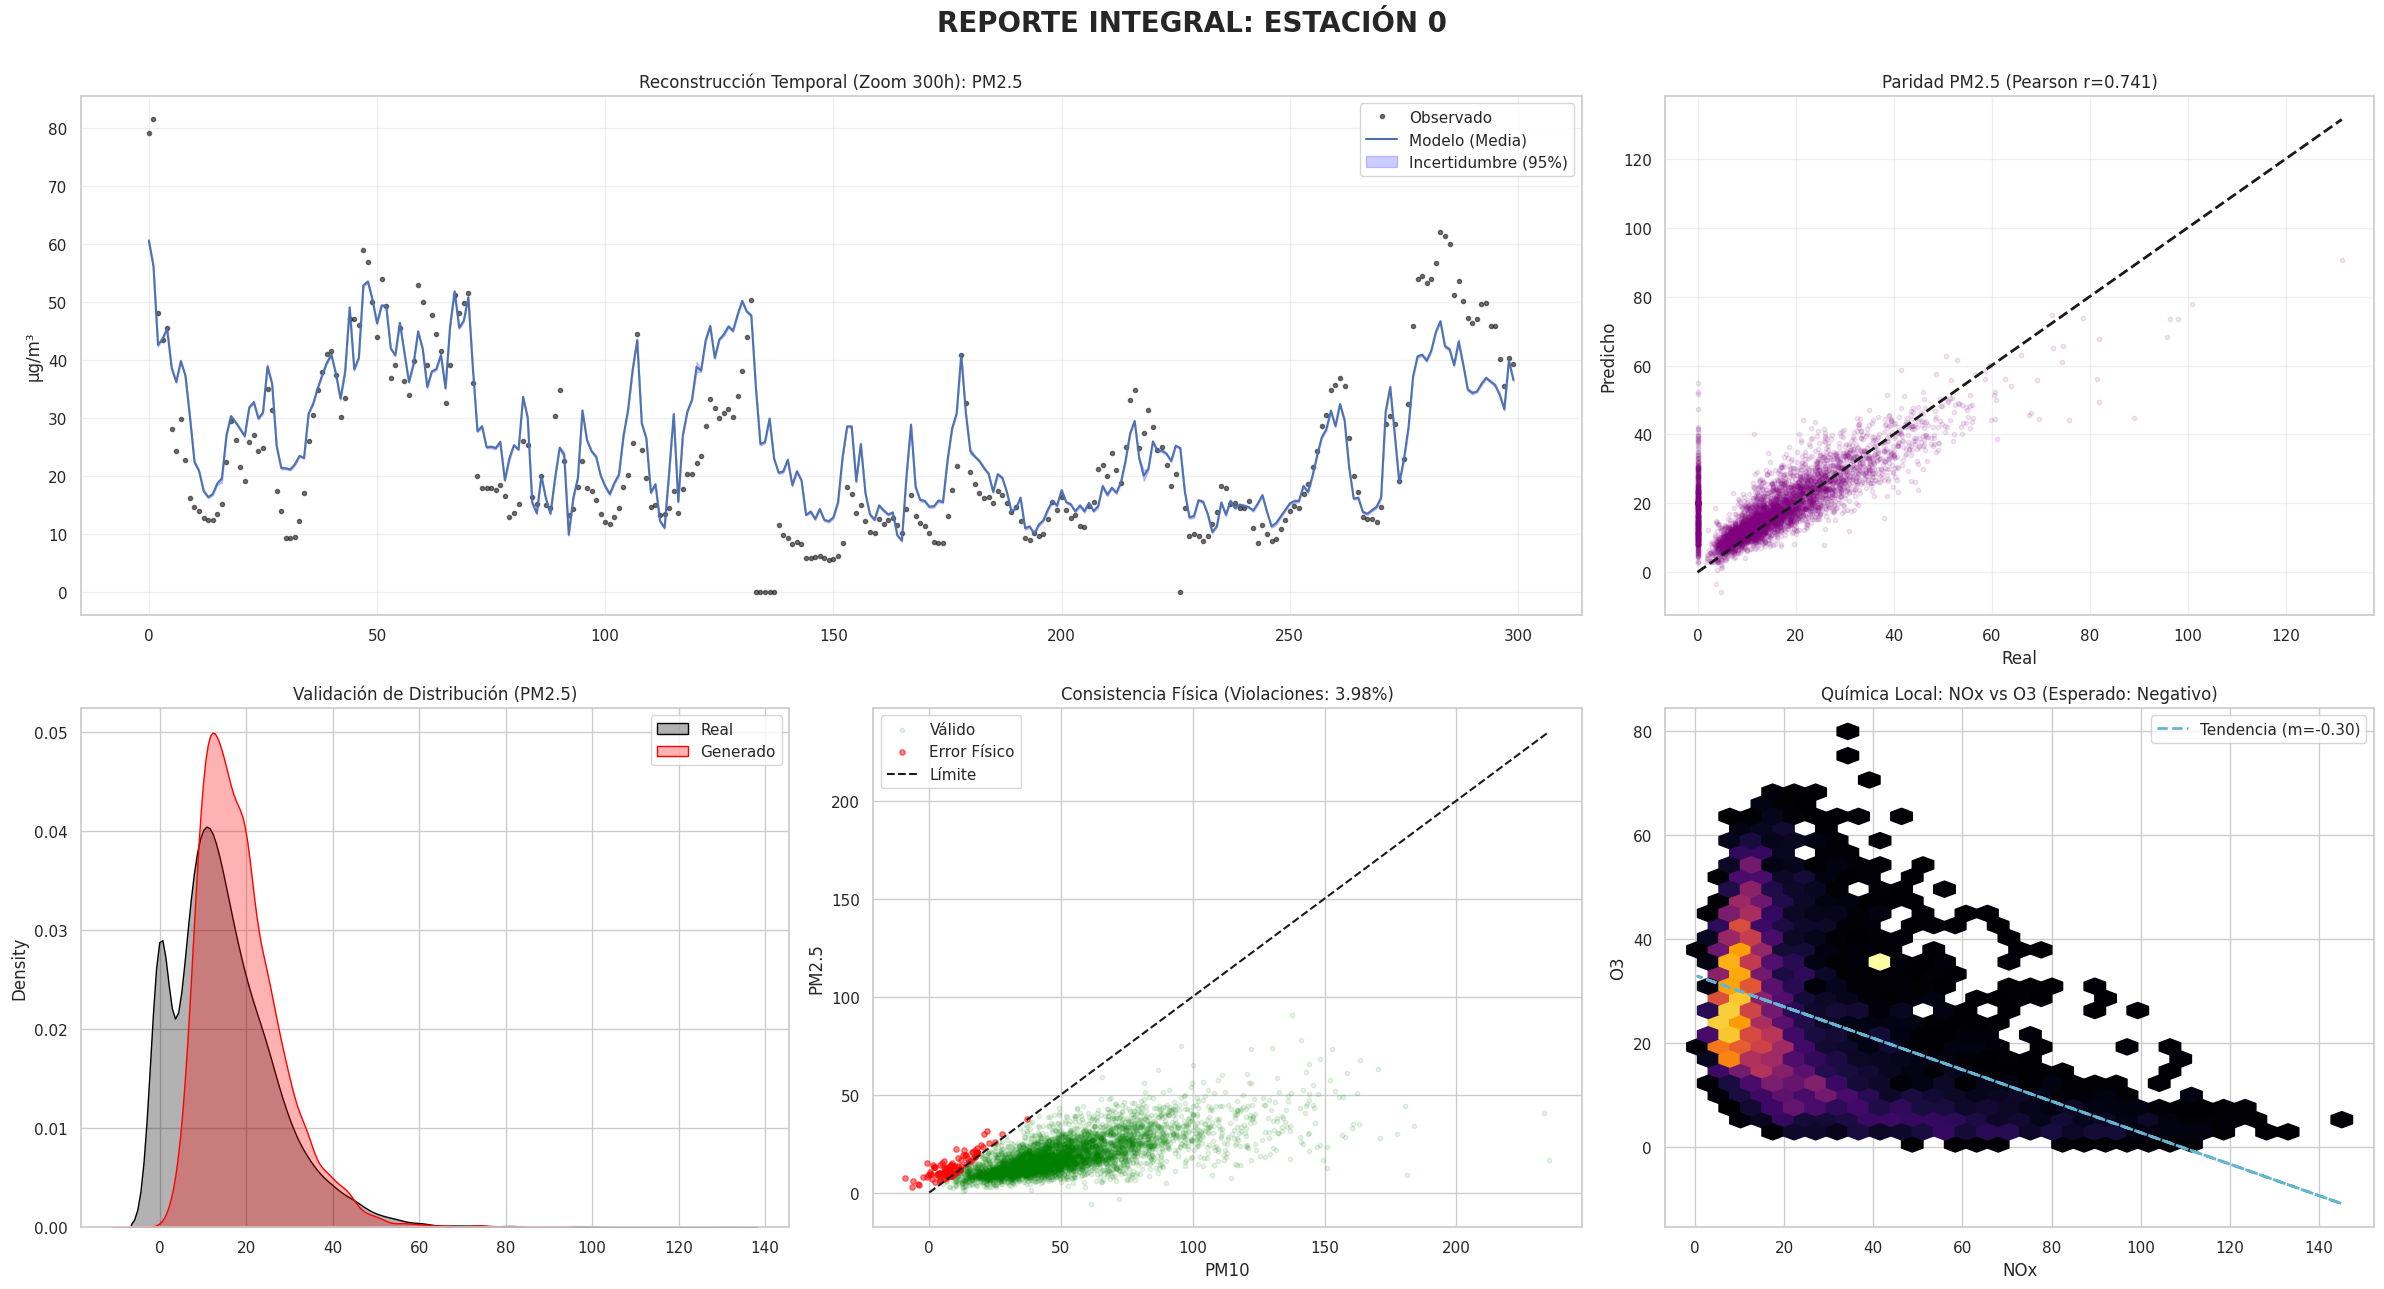

   ✓ Estación 0 Reportada.

   ... Procesando Estación 1 ...


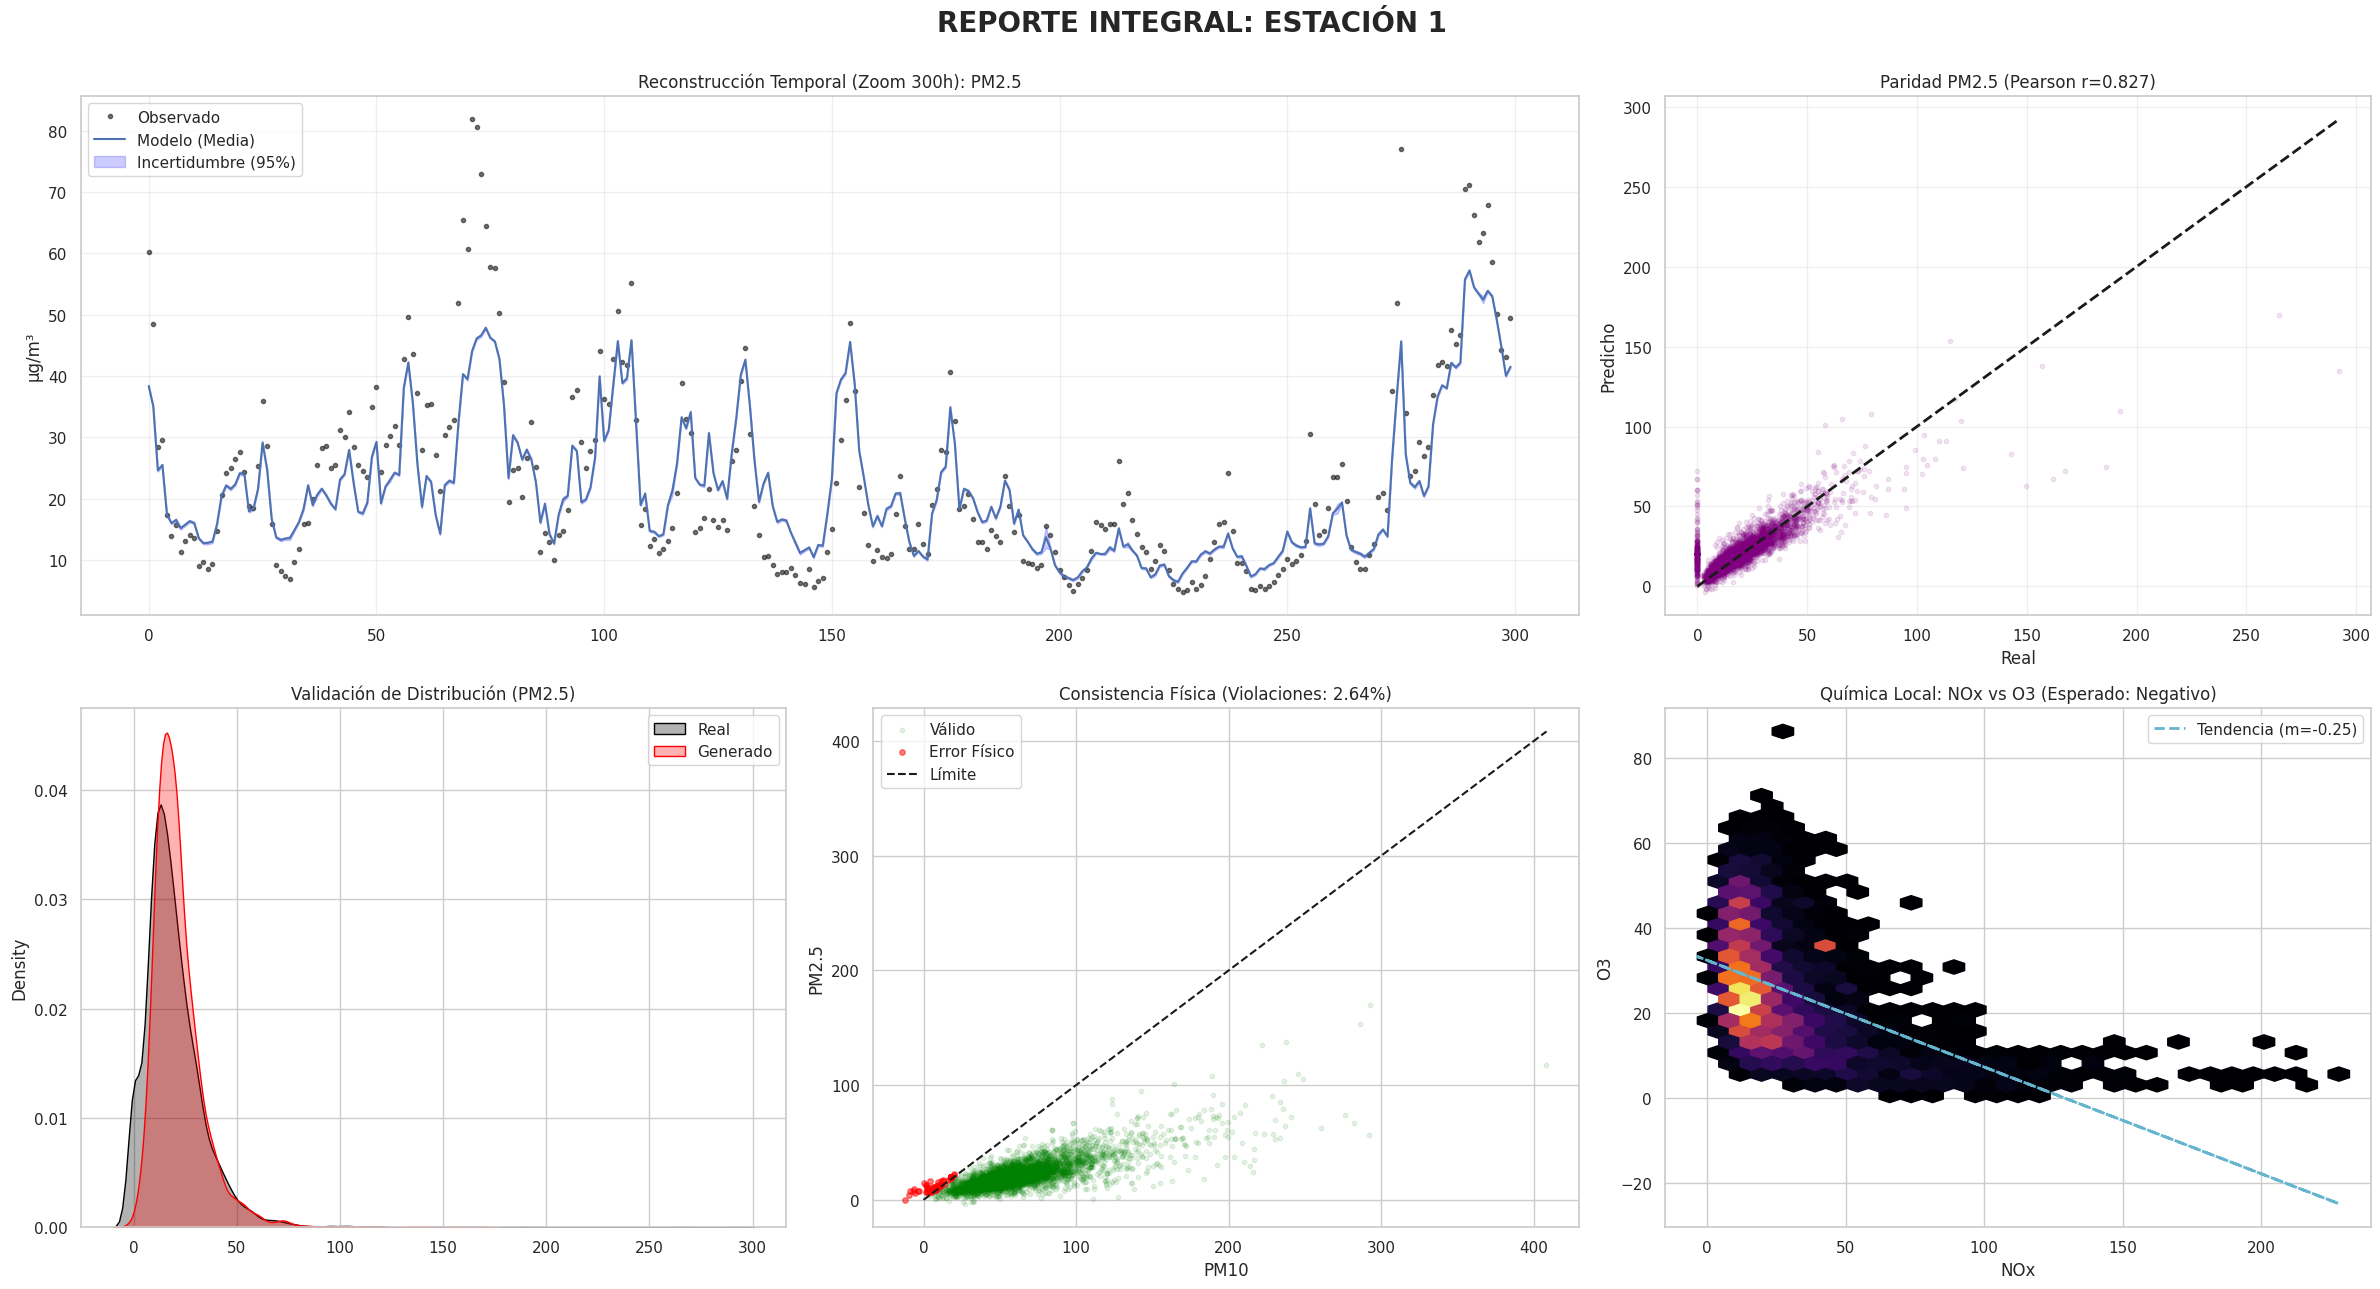

   ✓ Estación 1 Reportada.

   ... Procesando Estación 2 ...


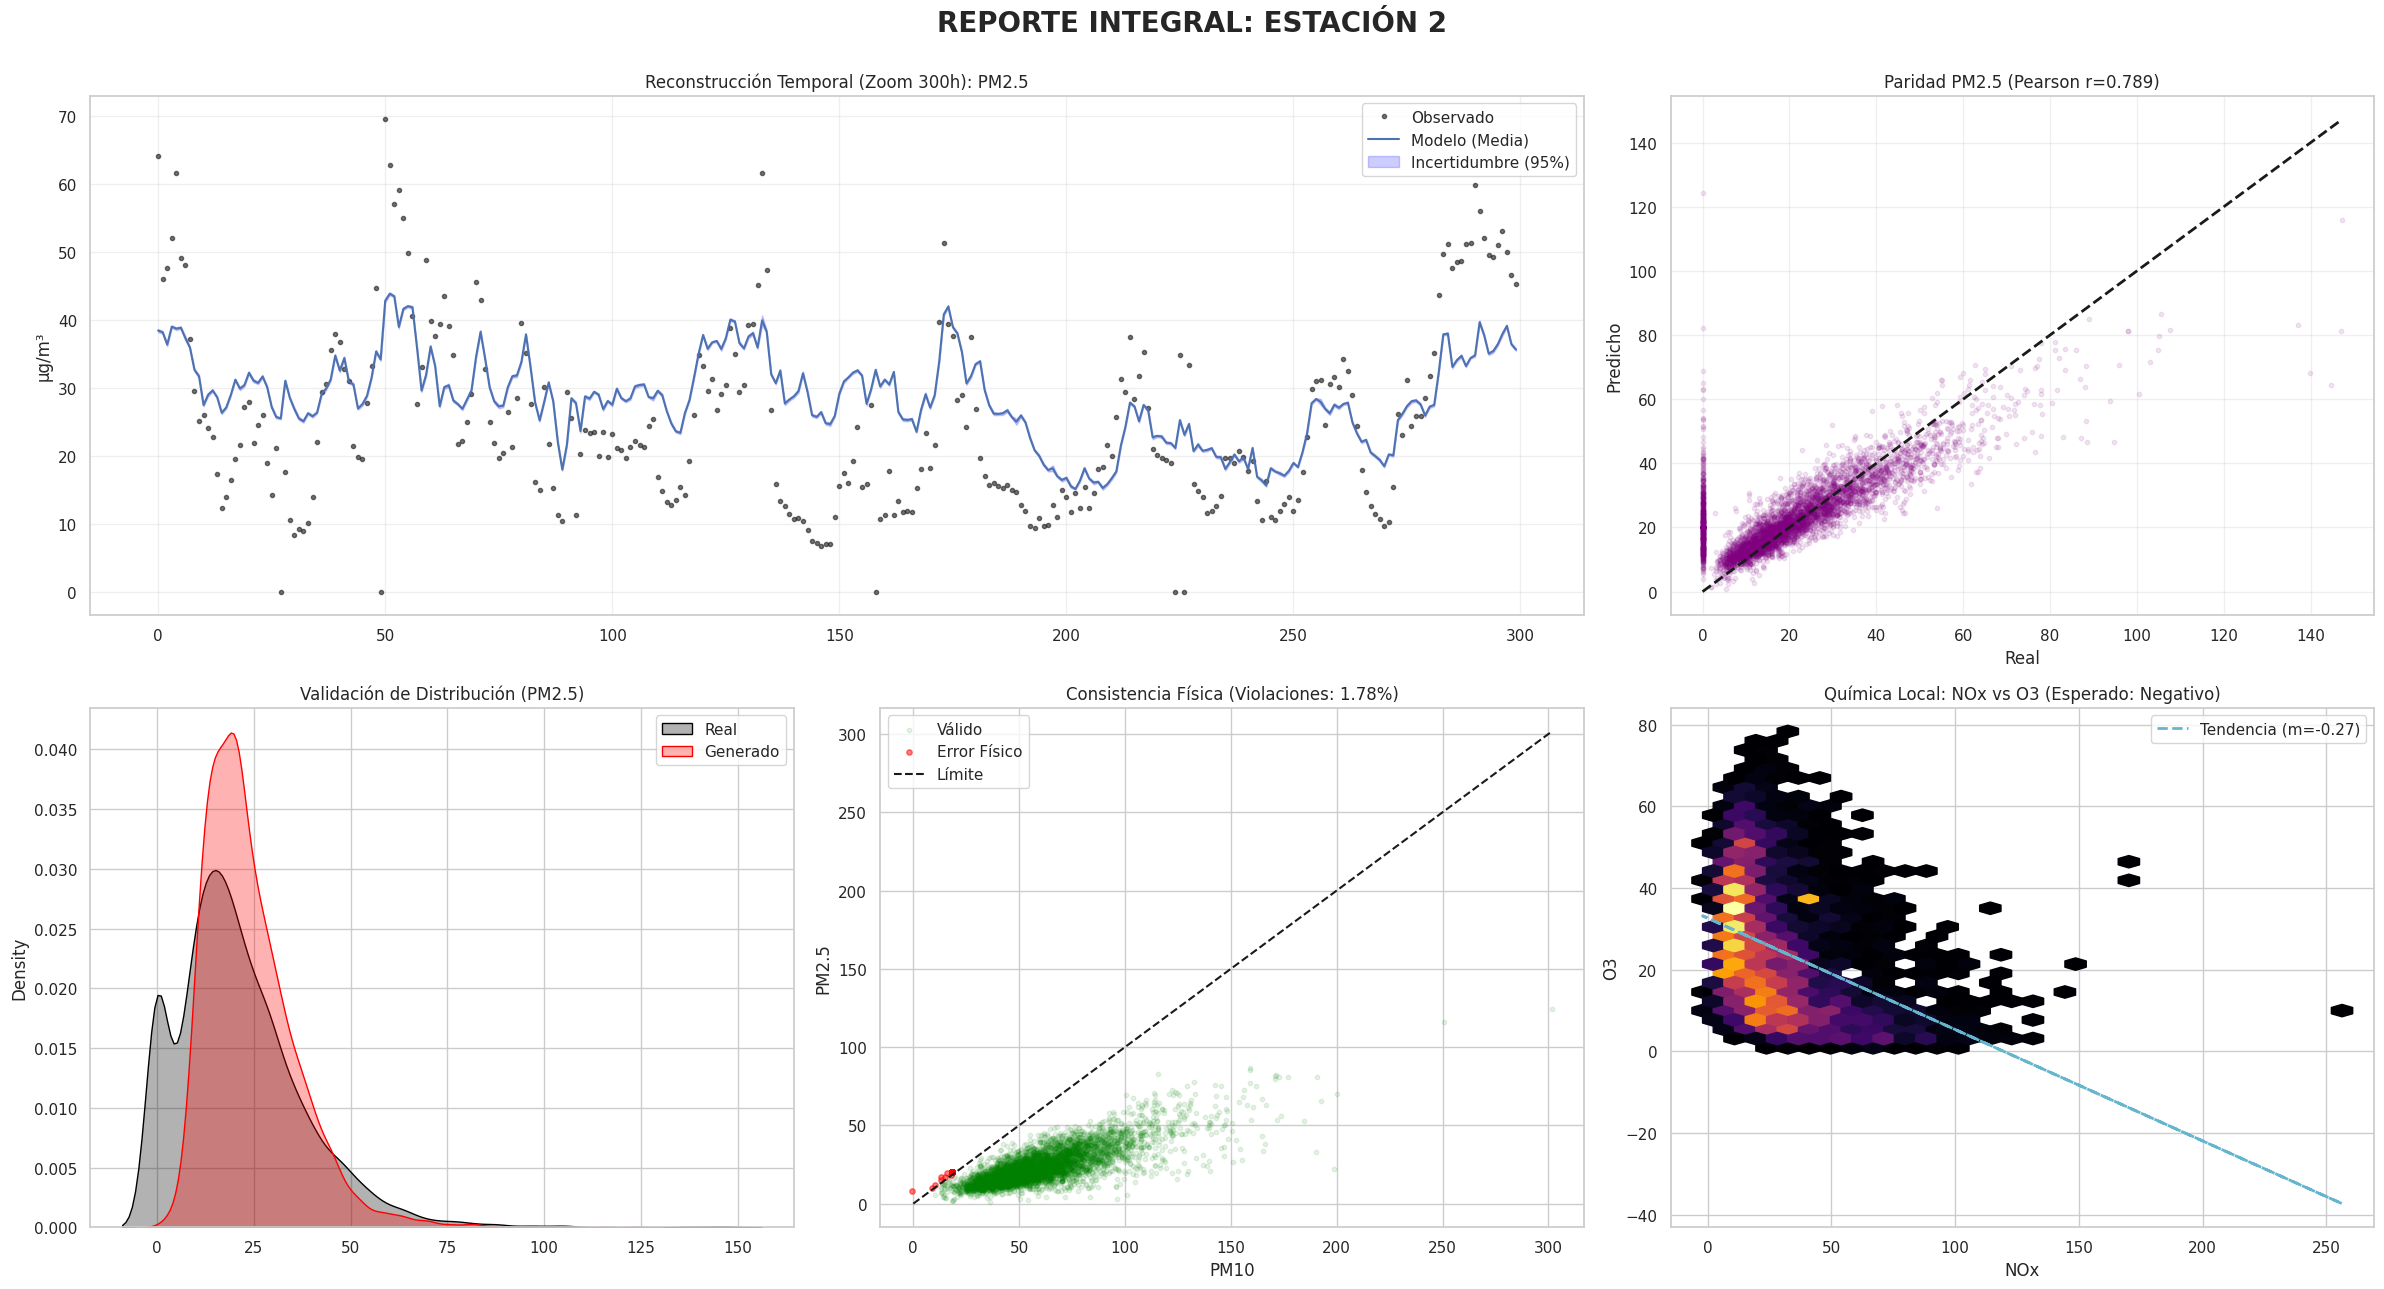

   ✓ Estación 2 Reportada.

   ... Procesando Estación 3 ...


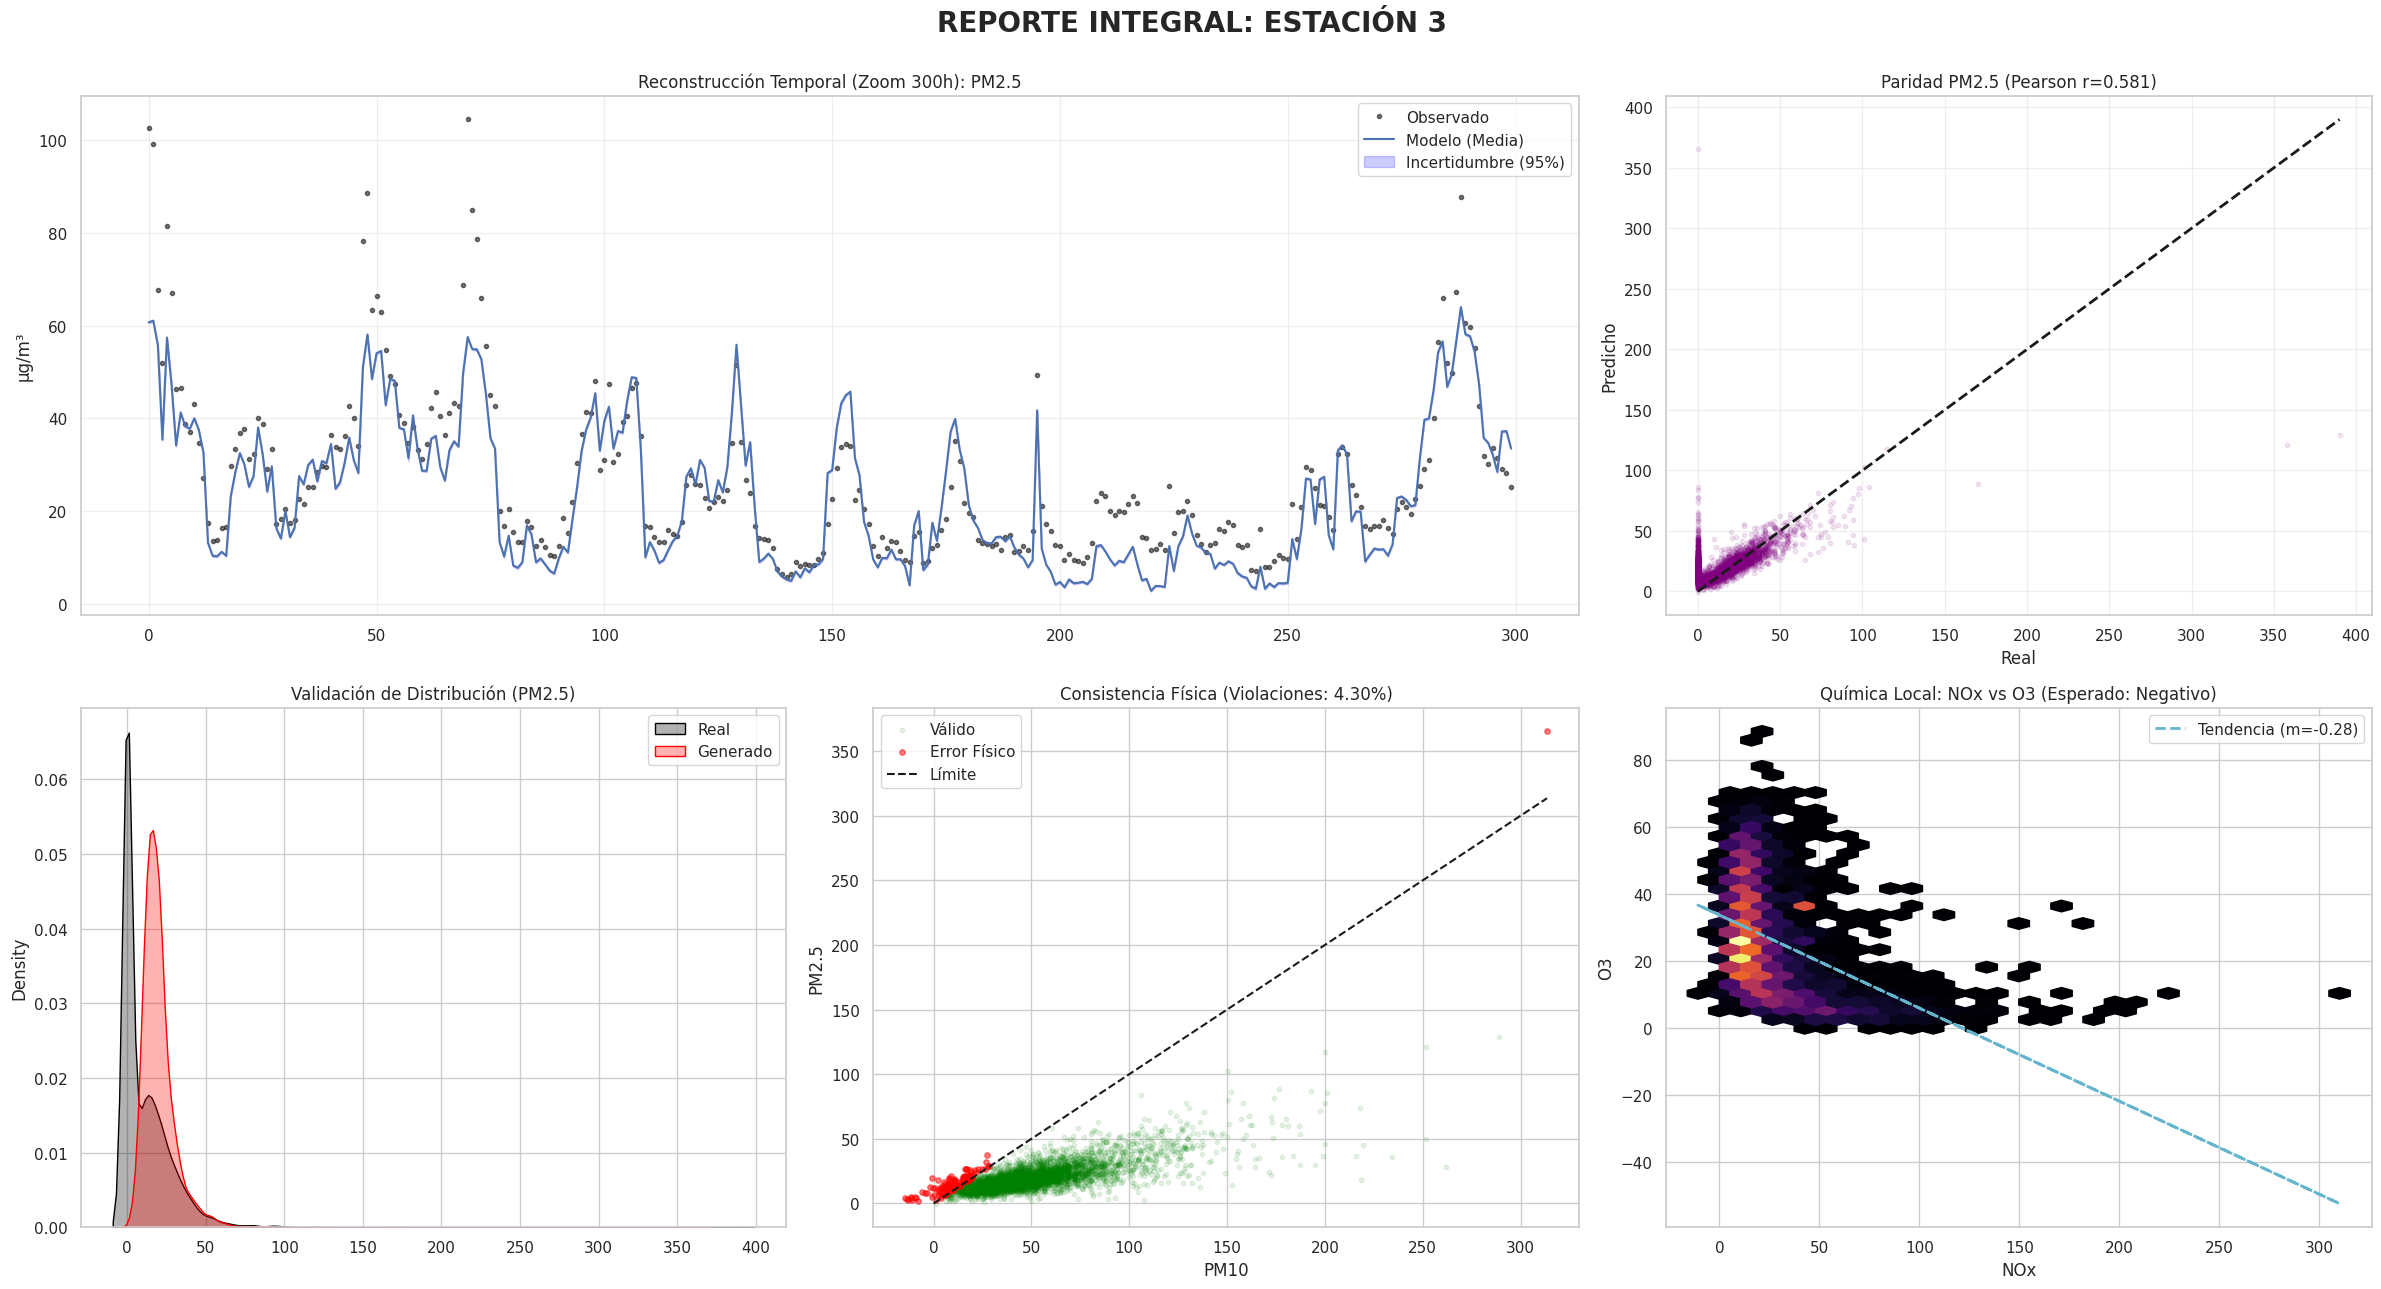

   ✓ Estación 3 Reportada.

   ... Procesando Estación 4 ...


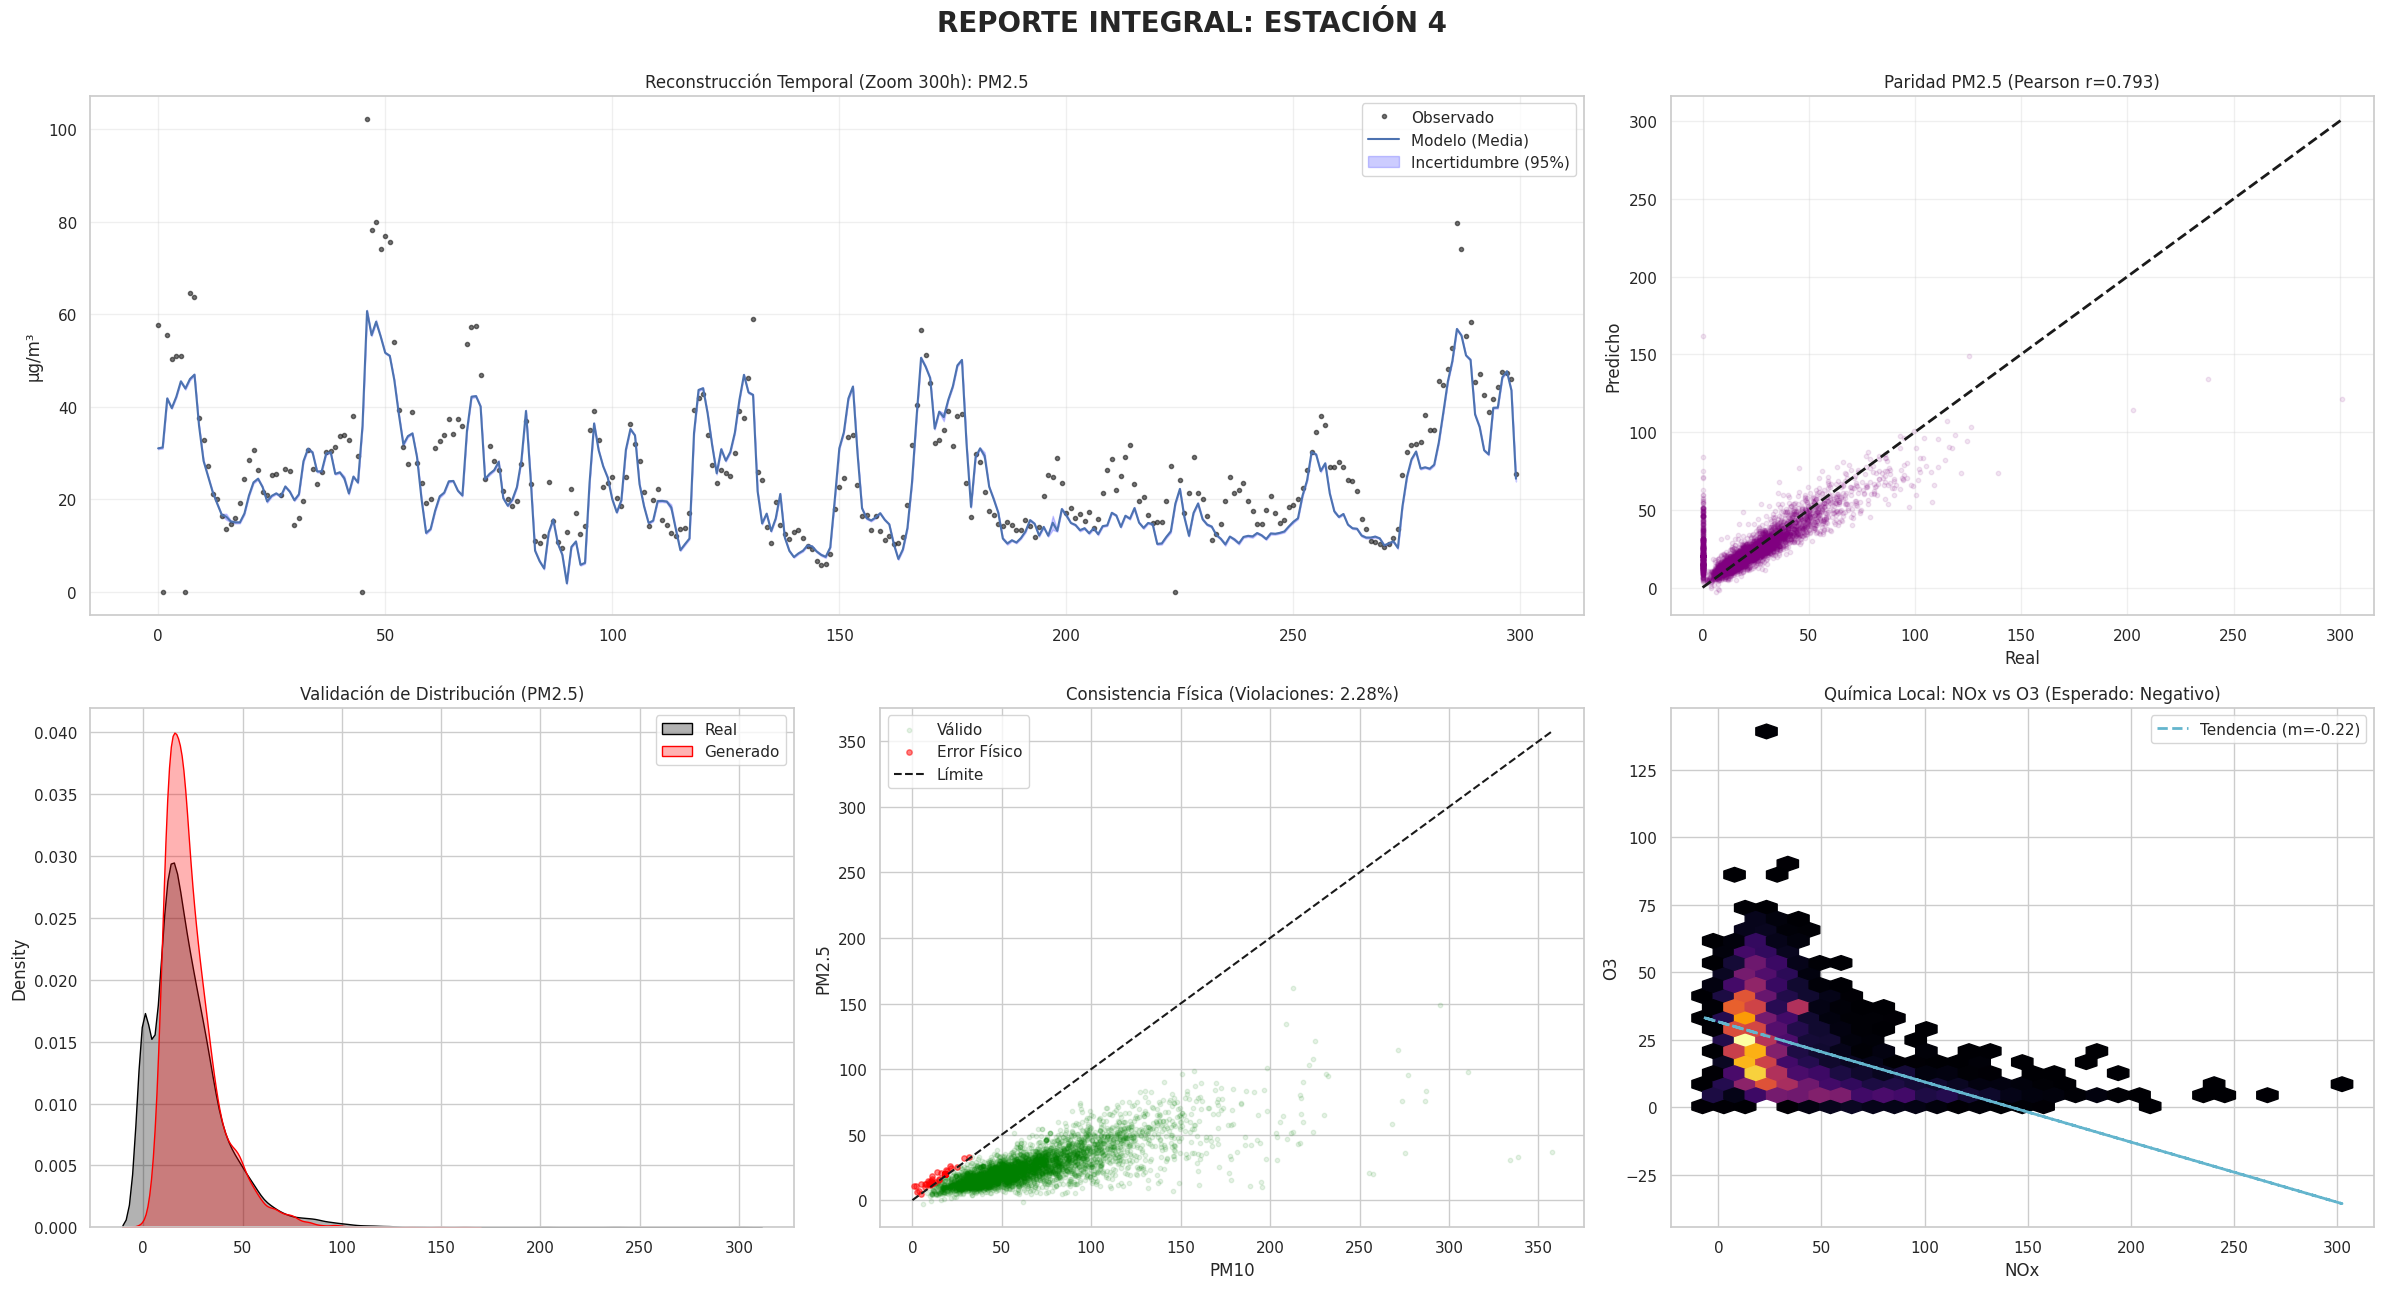

   ✓ Estación 4 Reportada.

   ... Procesando Estación 5 ...


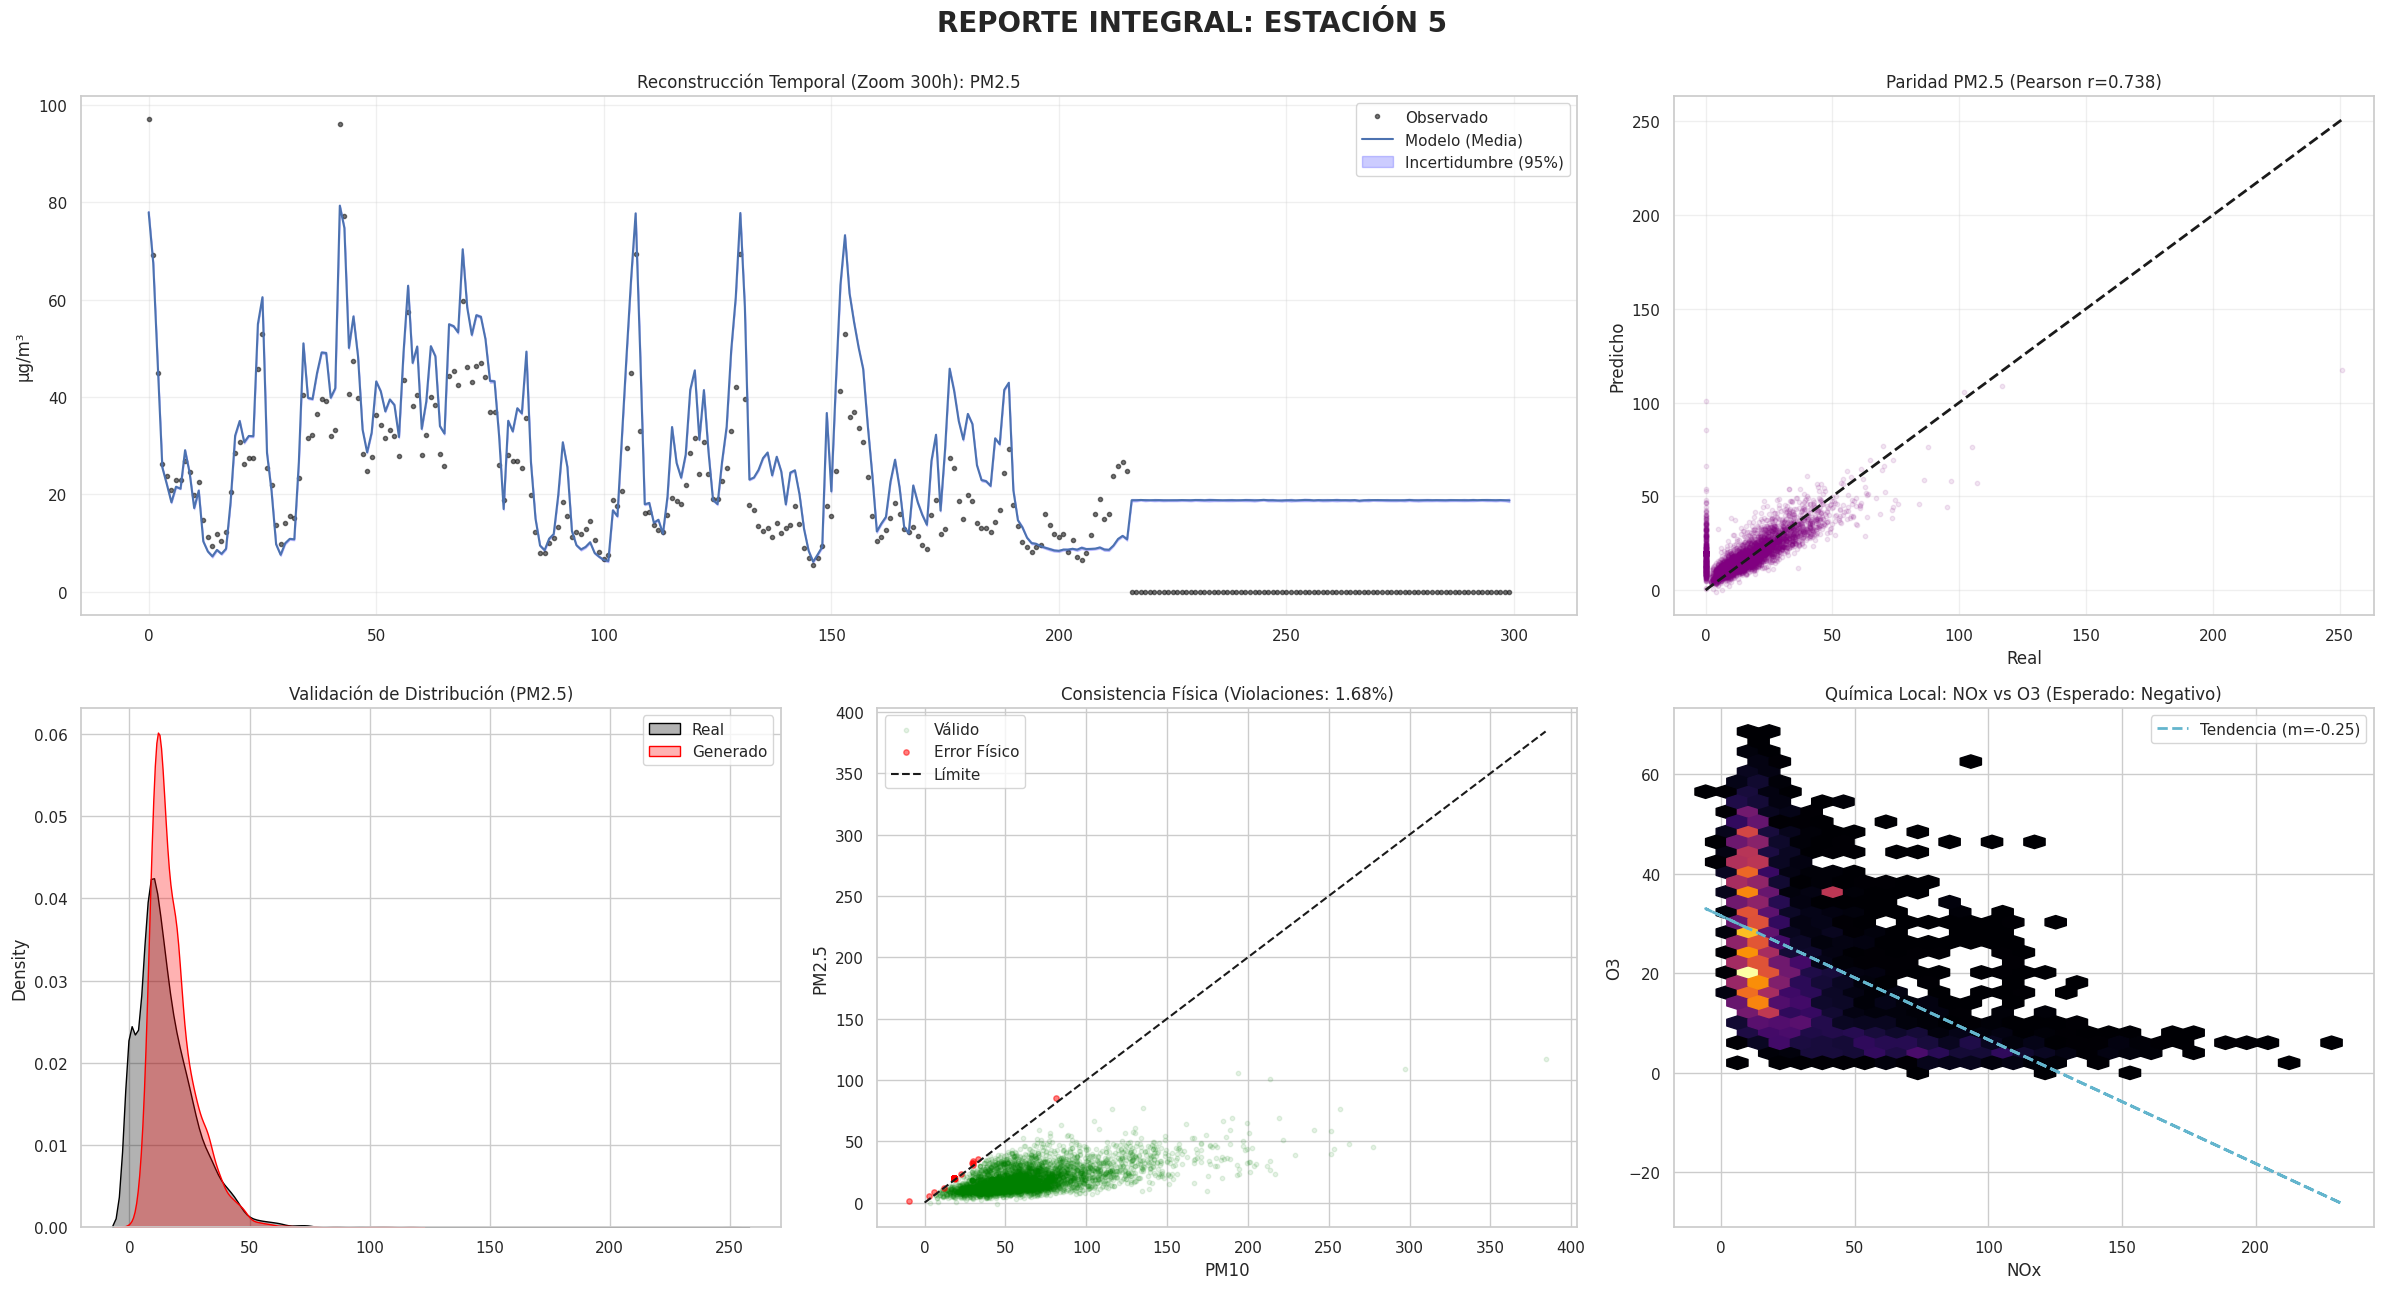

   ✓ Estación 5 Reportada.

   ... Procesando Estación 6 ...


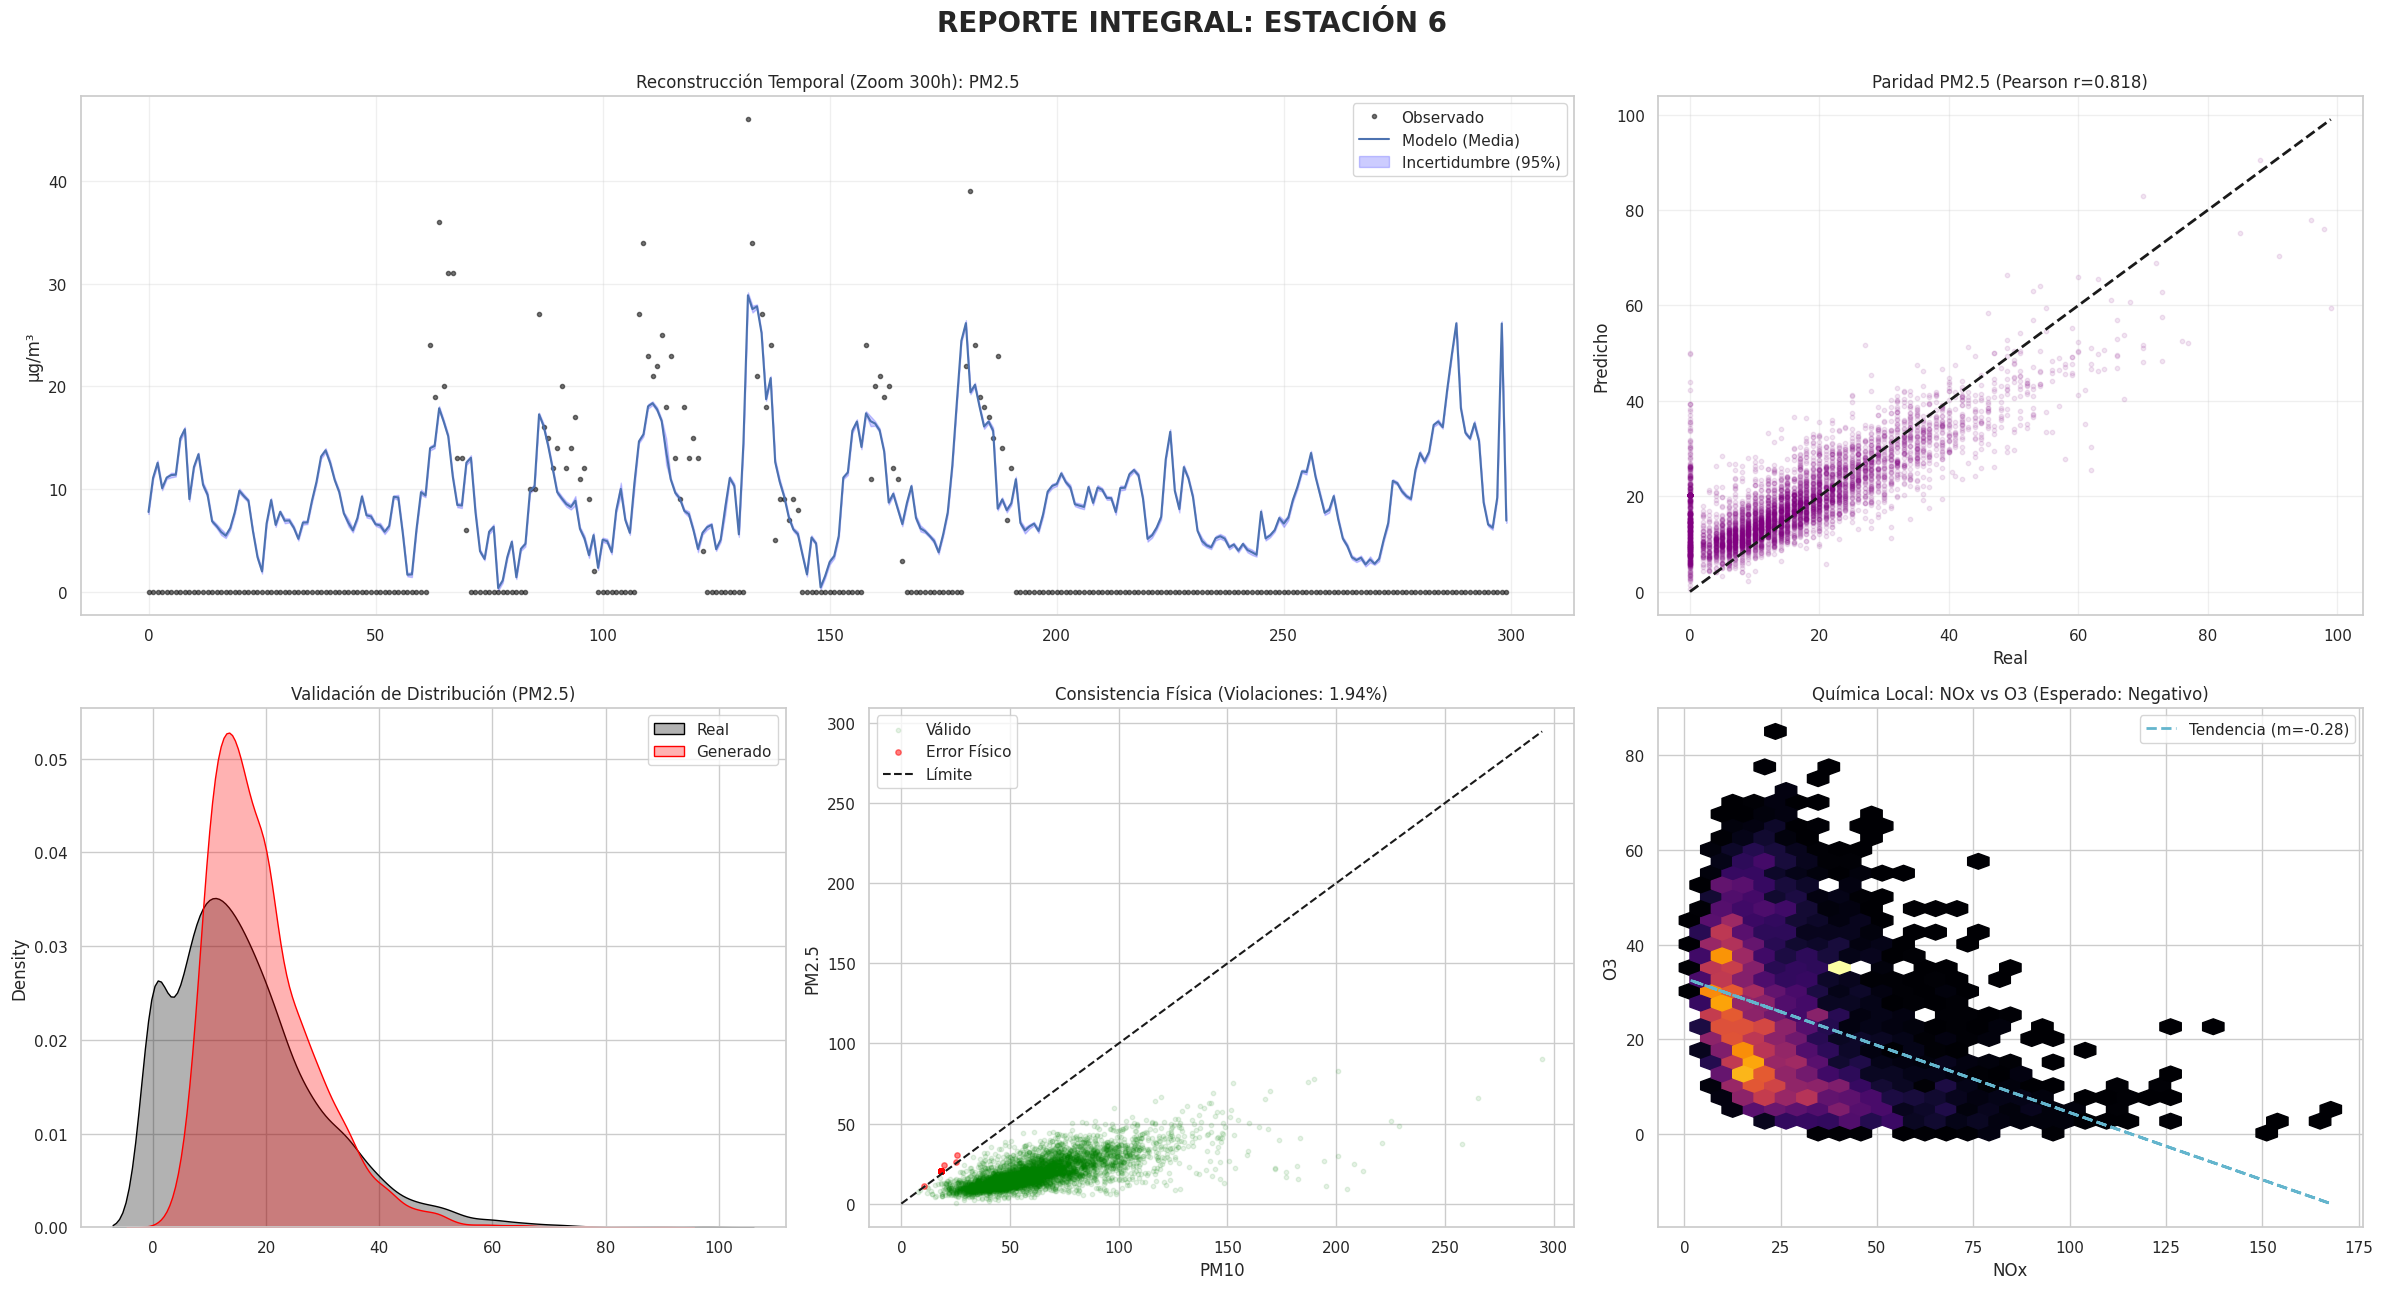

   ✓ Estación 6 Reportada.

   ... Procesando Estación 7 ...


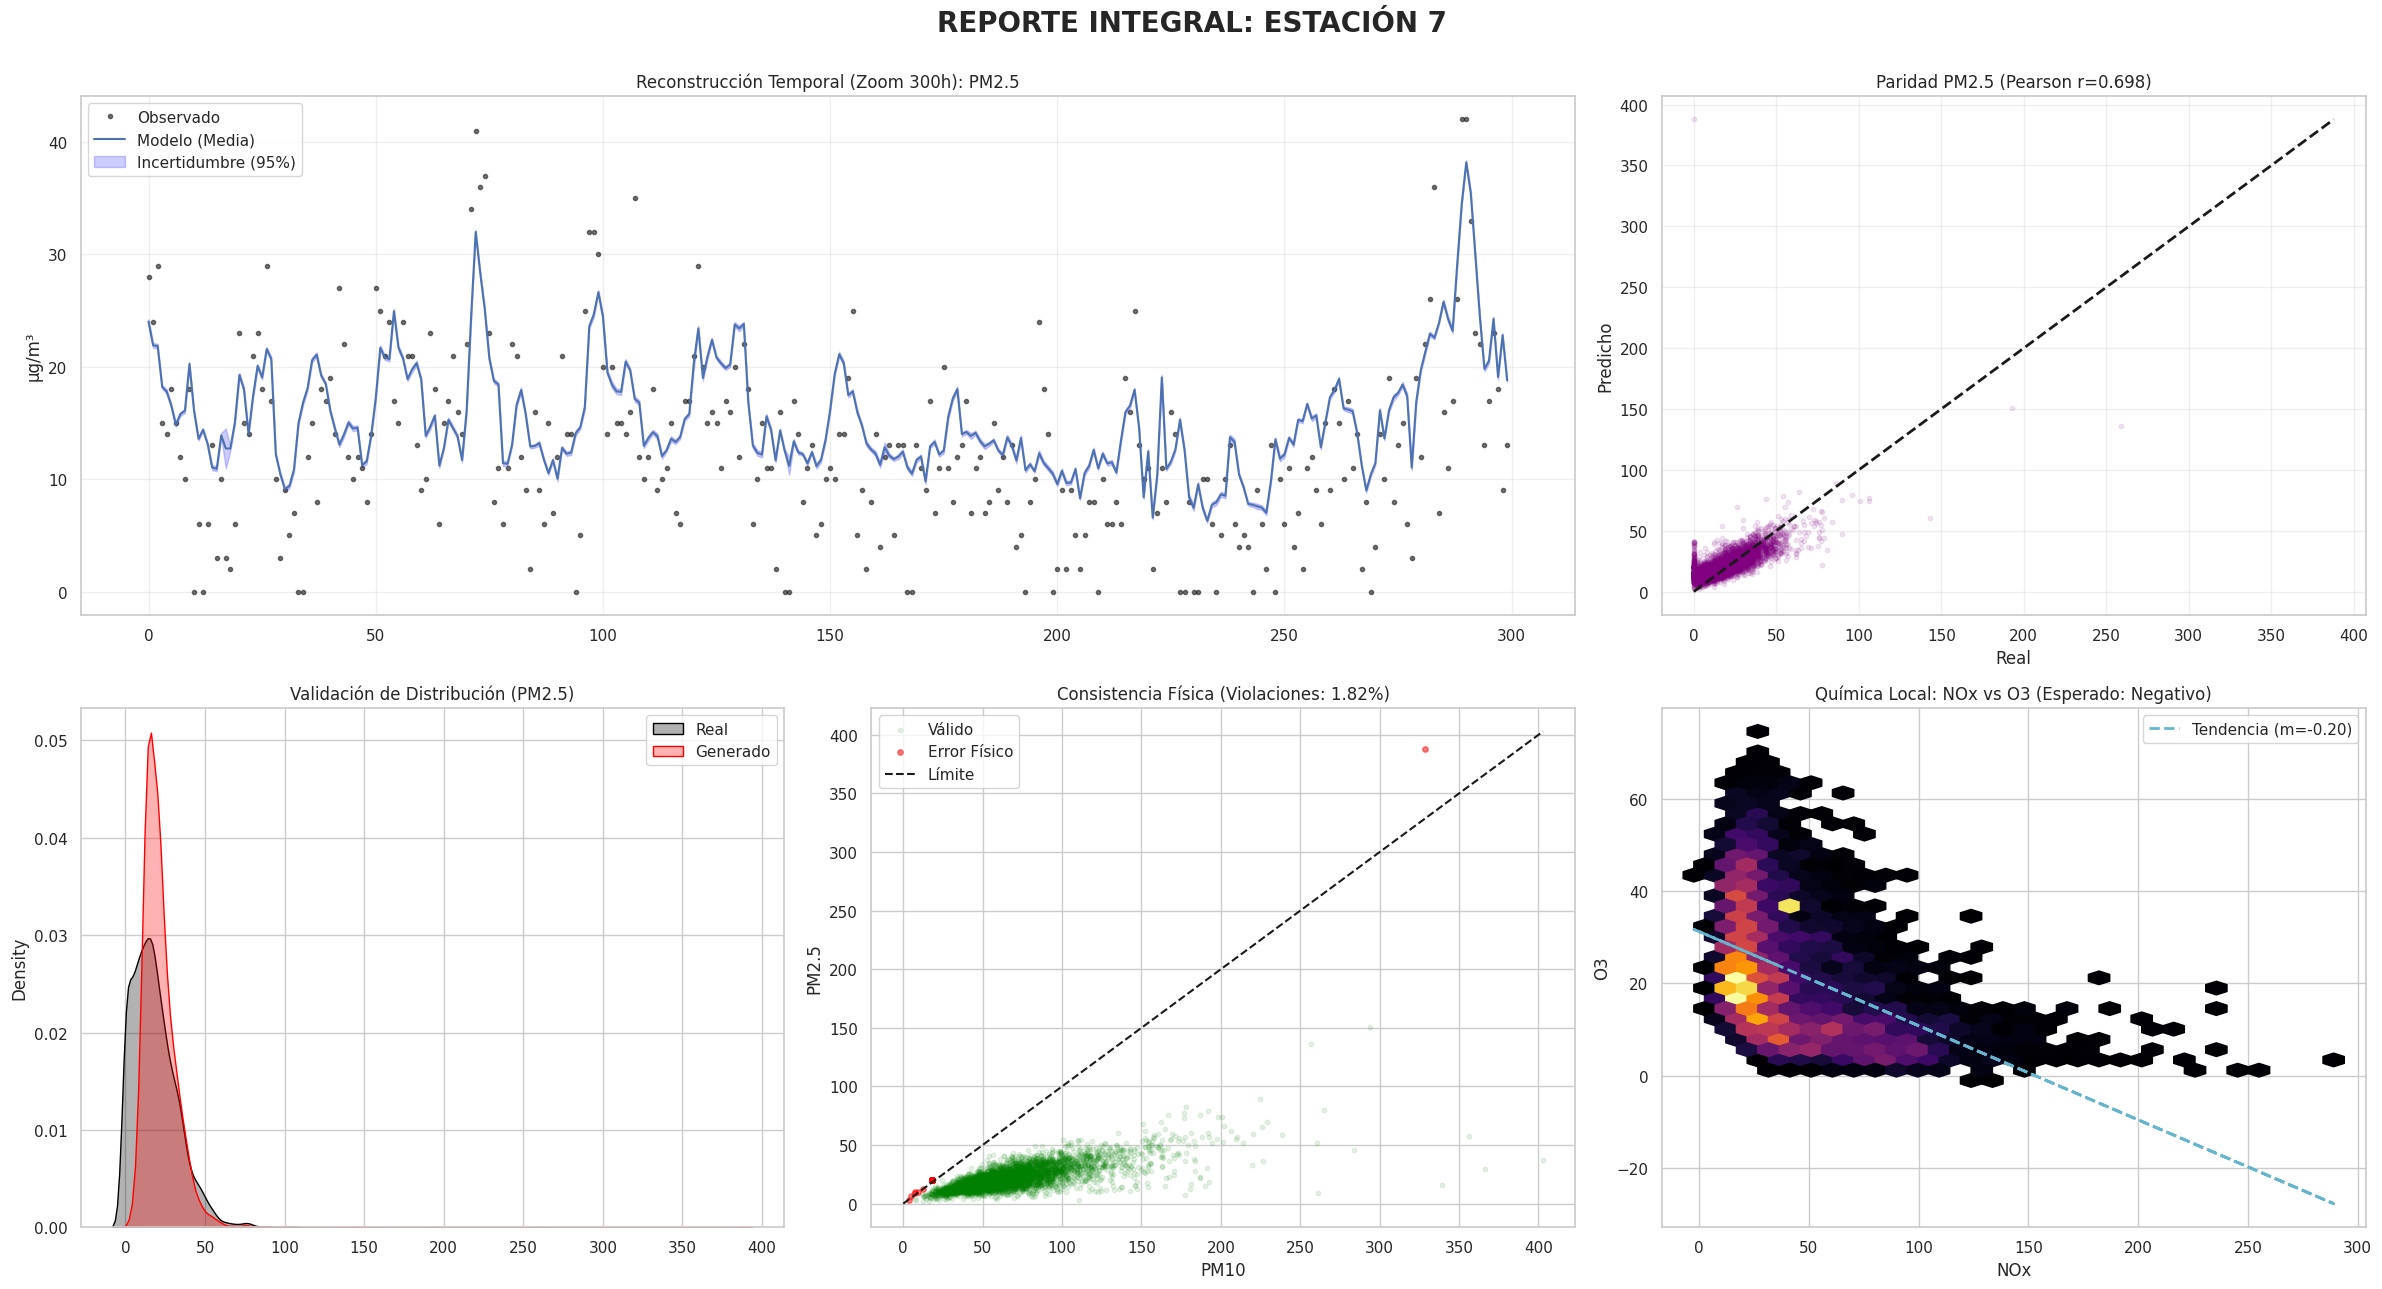

   ✓ Estación 7 Reportada.

   ... Procesando Estación 8 ...


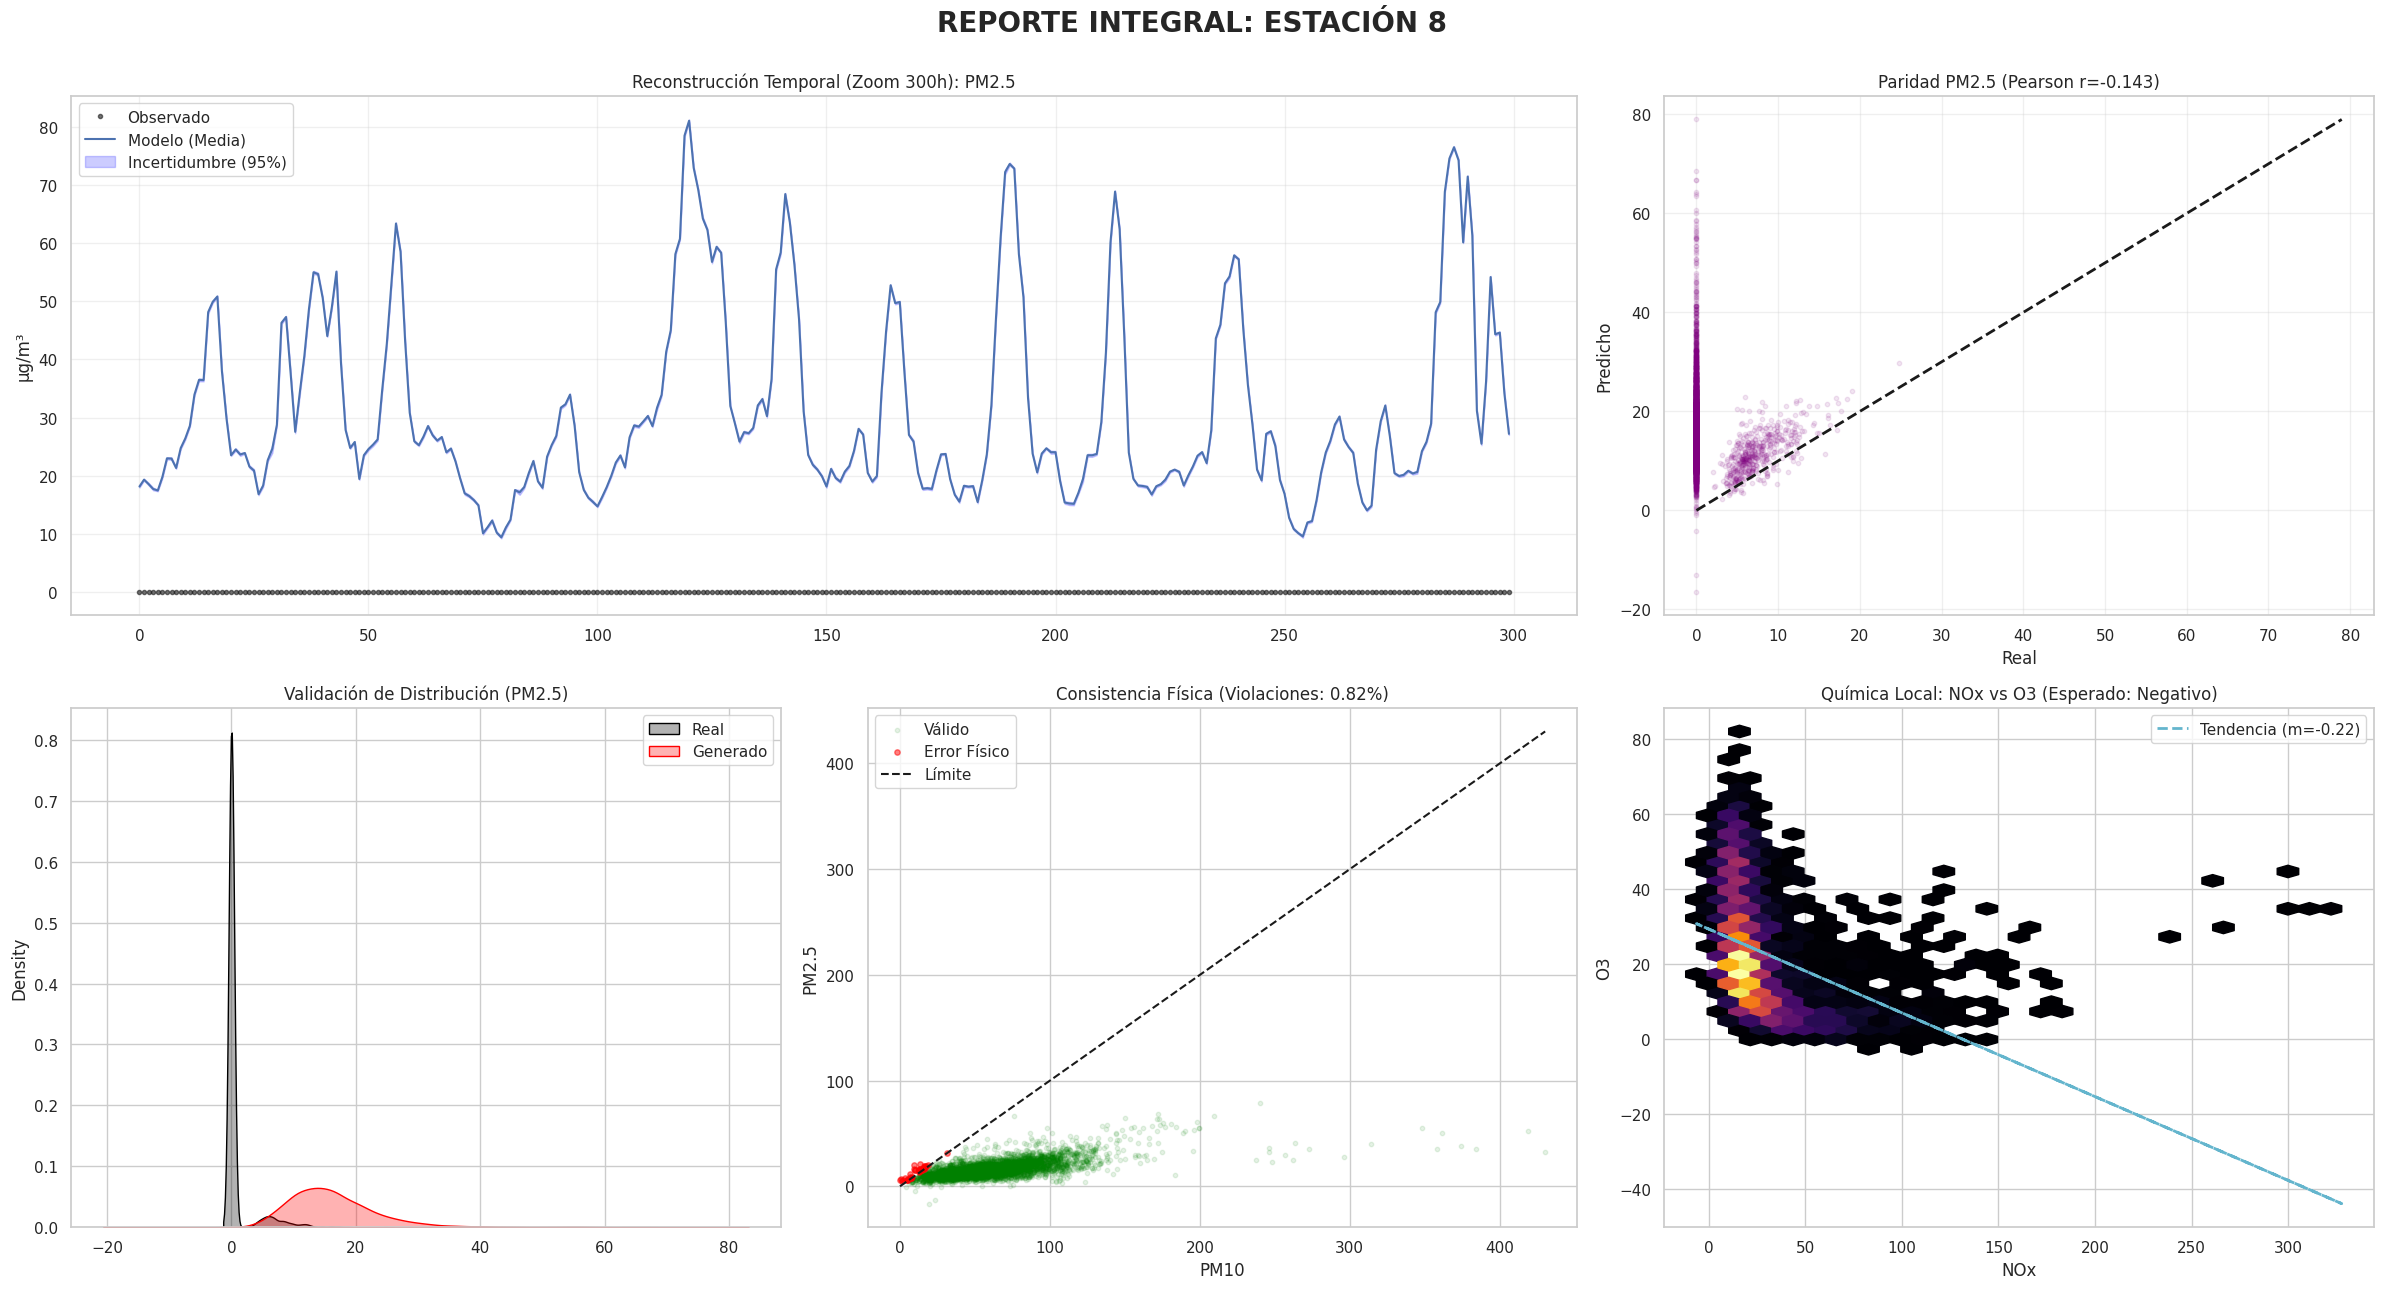

   ✓ Estación 8 Reportada.



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from torch.utils.data import DataLoader

def generate_ultimate_station_report(model, data_arrays, config, metrics_engine):
    print(f"\n--> GENERANDO REPORTE EXHAUSTIVO POR ESTACIÓN (TOTAL: {len(data_arrays)} ESTACIONES)...")

    model.eval()
    feature_cols = metrics_engine.feature_cols

    # Índices
    idx_pm10 = metrics_engine.idx_pm10
    idx_pm25 = metrics_engine.idx_pm25
    idx_nox = metrics_engine.idx_nox
    idx_o3 = metrics_engine.idx_o3

    for i, station_data in enumerate(data_arrays):
        print(f"   ... Procesando Estación {i} ...")

        # 1. Preparar datos de ESTA estación
        n_rows = len(station_data)
        # Tomamos ventanas consecutivas (stride=168) para cubrir todo el periodo sin superposición excesiva para graficar
        station_indices = [(i, start) for start in range(0, n_rows - config['seq_len'], 168)]

        if len(station_indices) == 0: continue

        ds = LazyAirQualityDataset(data_arrays, station_indices, config['seq_len'])
        # Batch grande para procesar rápido
        dl = DataLoader(ds, batch_size=128, shuffle=False)

        # Coleccionistas
        preds_list = []
        reals_list = []
        uncert_list = [] # Incertidumbre

        with torch.no_grad():
            for batch in dl:
                x = batch['observed_data'].to(config['device'])
                mask = batch['observed_mask'].to(config['device'])

                # A. Inferencia Monte Carlo (20 muestras) para incertidumbre
                samples = []
                for _ in range(20):
                    _, x_coarse = model.saits(x, mask)
                    noise = torch.randn_like(x)
                    t = torch.zeros((x.shape[0],), device=config['device']).long()
                    pred_noise = model.csdi(noise, t, x_coarse)
                    # Sample refinado
                    s = x_coarse + (noise - pred_noise) * 0.1
                    samples.append(s.unsqueeze(1))

                ensemble = torch.cat(samples, dim=1) # (B, 20, T, F)
                mean_pred = ensemble.mean(dim=1)     # (B, T, F)
                std_pred = ensemble.std(dim=1)       # (B, T, F)

                reals_list.append(x.cpu())
                preds_list.append(mean_pred.cpu())
                uncert_list.append(std_pred.cpu())

        # Concatenar todo (Toda la historia de la estación)
        x_real_norm = torch.cat(reals_list, dim=0)
        x_pred_norm = torch.cat(preds_list, dim=0)
        x_std_norm = torch.cat(uncert_list, dim=0)

        # Desnormalizar
        def denorm_cpu(t):
            B, T, F = t.shape
            flat = t.reshape(-1, F).numpy()
            return metrics_engine.scaler.inverse_transform(flat).reshape(B, T, F)

        real_phys = denorm_cpu(x_real_norm)
        pred_phys = denorm_cpu(x_pred_norm)

        # Truco para desnormalizar la desviación estándar (aproximado por linealidad)
        # std_phys = scale * std_norm
        dummy_std = denorm_cpu(x_std_norm) - denorm_cpu(torch.zeros_like(x_std_norm))
        std_phys = dummy_std

        # ==========================================
        # CREACIÓN DEL DASHBOARD (6 Subplots)
        # ==========================================
        fig = plt.figure(figsize=(24, 14))
        plt.suptitle(f"REPORTE INTEGRAL: ESTACIÓN {i}", fontsize=20, fontweight='bold', y=0.95)

        # Layout: 2 filas, 3 columnas
        gs = fig.add_gridspec(2, 3)

        # --- 1. SERIE DE TIEMPO (PM2.5) - Zoom a las primeras 300 horas ---
        ax1 = fig.add_subplot(gs[0, 0:2]) # Ocupa 2 columnas
        limit = 300 # Solo graficamos un tramo para que se vea bien
        flat_real = real_phys.reshape(-1, len(feature_cols))[:limit]
        flat_pred = pred_phys.reshape(-1, len(feature_cols))[:limit]
        flat_std = std_phys.reshape(-1, len(feature_cols))[:limit]

        ax1.plot(flat_real[:, idx_pm25], 'k.', label='Observado', alpha=0.6)
        ax1.plot(flat_pred[:, idx_pm25], 'b-', label='Modelo (Media)', lw=1.5)
        ax1.fill_between(range(len(flat_pred)),
                         flat_pred[:, idx_pm25] - 2*flat_std[:, idx_pm25],
                         flat_pred[:, idx_pm25] + 2*flat_std[:, idx_pm25],
                         color='blue', alpha=0.2, label='Incertidumbre (95%)')
        ax1.set_title(f"Reconstrucción Temporal (Zoom 300h): PM2.5", fontsize=12)
        ax1.legend()
        ax1.set_ylabel("µg/m³")
        ax1.grid(True, alpha=0.3)

        # --- 2. SCATTER PLOT (Paridad) ---
        ax2 = fig.add_subplot(gs[0, 2])
        # Usamos todos los datos para el scatter
        all_real_pm25 = real_phys[:, :, idx_pm25].flatten()
        all_pred_pm25 = pred_phys[:, :, idx_pm25].flatten()

        # Downsample para no saturar la gráfica si hay muchos datos
        if len(all_real_pm25) > 5000:
            idx_sample = np.random.choice(len(all_real_pm25), 5000, replace=False)
            s_real = all_real_pm25[idx_sample]
            s_pred = all_pred_pm25[idx_sample]
        else:
            s_real, s_pred = all_real_pm25, all_pred_pm25

        ax2.scatter(s_real, s_pred, alpha=0.1, s=10, c='purple')
        max_val = max(s_real.max(), s_pred.max())
        ax2.plot([0, max_val], [0, max_val], 'k--', lw=2)

        # Calcular correlación de esta estación
        r, _ = pearsonr(s_real, s_pred)
        ax2.set_title(f"Paridad PM2.5 (Pearson r={r:.3f})", fontsize=12)
        ax2.set_xlabel("Real")
        ax2.set_ylabel("Predicho")
        ax2.grid(True, alpha=0.3)

        # --- 3. DISTRIBUCIÓN (KDE) ---
        ax3 = fig.add_subplot(gs[1, 0])
        sns.kdeplot(s_real, fill=True, color="black", label="Real", ax=ax3, alpha=0.3)
        sns.kdeplot(s_pred, fill=True, color="red", label="Generado", ax=ax3, alpha=0.3)
        ax3.set_title("Validación de Distribución (PM2.5)", fontsize=12)
        ax3.legend()

        # --- 4. VALIDACIÓN FÍSICA (PM10 vs PM2.5) ---
        ax4 = fig.add_subplot(gs[1, 1])
        all_pred_pm10 = pred_phys[:, :, idx_pm10].flatten()
        # Mismo downsample
        if len(all_pred_pm10) > 5000:
            s_pm10 = all_pred_pm10[idx_sample]
            s_pm25 = all_pred_pm25[idx_sample] # Ya sampleado arriba
        else:
            s_pm10 = all_pred_pm10
            s_pm25 = all_pred_pm25

        violations = s_pm25 > s_pm10
        ax4.scatter(s_pm10[~violations], s_pm25[~violations], c='green', alpha=0.1, s=10, label='Válido')
        ax4.scatter(s_pm10[violations], s_pm25[violations], c='red', alpha=0.5, s=15, label='Error Físico')
        ax4.plot([0, max(s_pm10)], [0, max(s_pm10)], 'k--', label='Límite')

        v_rate = np.mean(violations) * 100
        ax4.set_title(f"Consistencia Física (Violaciones: {v_rate:.2f}%)", fontsize=12)
        ax4.set_xlabel("PM10")
        ax4.set_ylabel("PM2.5")
        ax4.legend()

        # --- 5. QUÍMICA Y ERROR HORARIO (Mix) ---
        ax5 = fig.add_subplot(gs[1, 2])

        # Vamos a graficar el error promedio por hora del día (0-23)
        # Asumiendo que los datos empiezan en hora 0 y son continuos
        errors = np.abs(real_phys[:, :, idx_pm25] - pred_phys[:, :, idx_pm25])
        # Reshape para agrupar por hora (batch * 7 dias * 24 horas)
        # Esto es aproximado si los batches no están alineados perfectamente a las 00:00,
        # pero para series largas muestra patrones.
        # Mejor: Usamos correlación Química NOx vs O3

        s_nox = pred_phys[:, :, idx_nox].flatten()
        s_o3 = pred_phys[:, :, idx_o3].flatten()

        if len(s_nox) > 5000:
            s_nox = s_nox[idx_sample]
            s_o3 = s_o3[idx_sample]

        ax5.hexbin(s_nox, s_o3, gridsize=30, cmap='inferno', mincnt=1)
        # Linea de tendencia
        if np.std(s_nox) > 0:
            m, b = np.polyfit(s_nox, s_o3, 1)
            ax5.plot(s_nox, m*s_nox + b, 'c--', lw=2, label=f'Tendencia (m={m:.2f})')

        ax5.set_title("Química Local: NOx vs O3 (Esperado: Negativo)", fontsize=12)
        ax5.set_xlabel("NOx")
        ax5.set_ylabel("O3")
        ax5.legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        print(f"   ✓ Estación {i} Reportada.\n")

# --- EJECUTAR ---
try:
    generate_ultimate_station_report(trained_model, data_arrays, CONFIG, metrics_engine)
except Exception as e:
    print(f"Error generando el reporte maestro: {e}")


--> Iniciando Auditoría de Calidad de Imputación...
    (Ocultando artificialmente el 20.0% de los datos reales para validar)

📊 REPORTE DE CALIDAD DE IMPUTACIÓN (Datos Ocultos)
MAE (Error Medio Absoluto): 4.4524 µg/m³
RMSE (Error Cuadrático):    14.8769 µg/m³
MRE (Error Relativo):       23.05%
R² (Coef. Determinación):   0.9932
(R² cercano a 1.0 es perfecto, < 0 es malo)
----------------------------------------


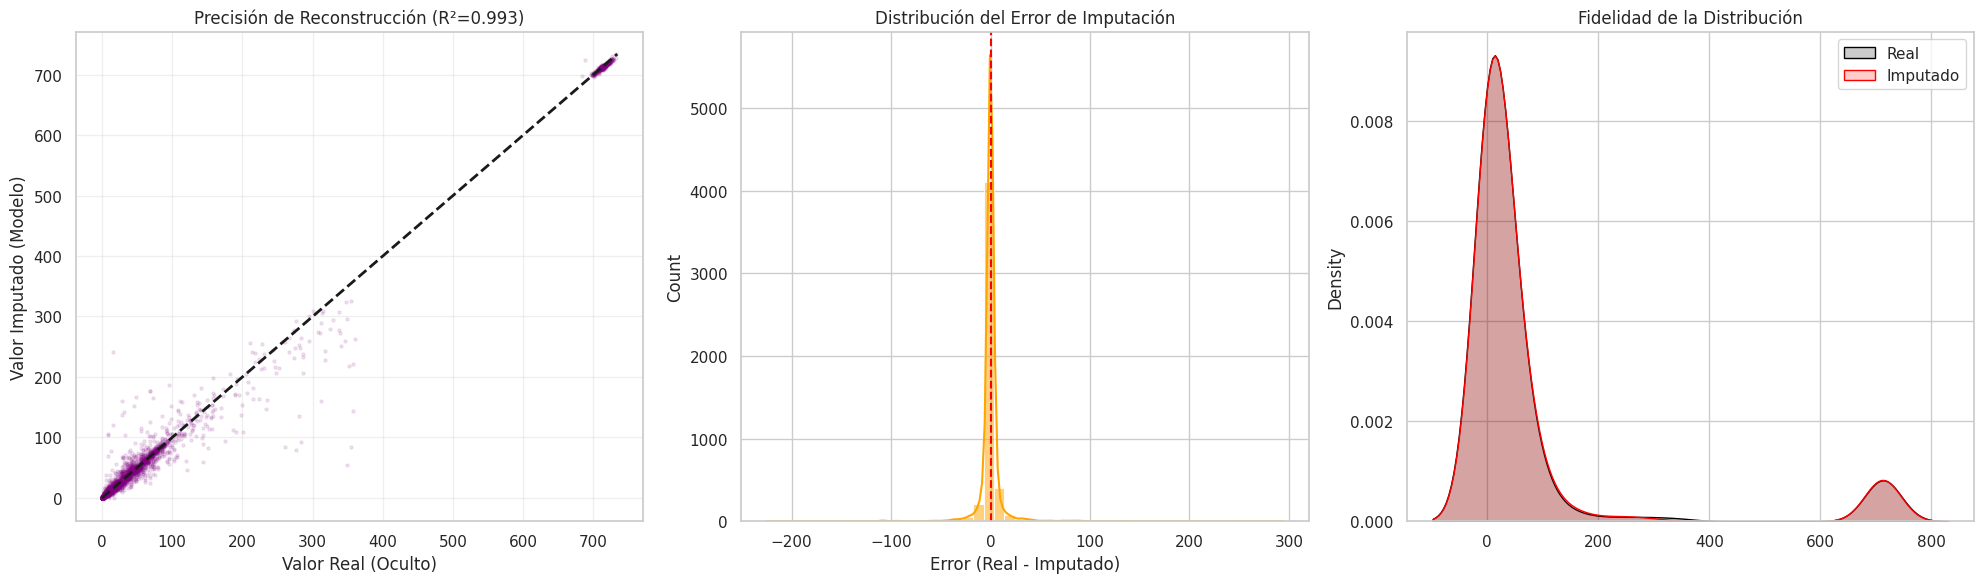

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================================
# 1. FUNCIÓN DE VALIDACIÓN DE IMPUTACIÓN
# ==========================================
def analyze_imputation_quality(model, dataloader, config, metrics_engine, mask_ratio=0.2):
    print(f"\n--> Iniciando Auditoría de Calidad de Imputación...")
    print(f"    (Ocultando artificialmente el {mask_ratio*100}% de los datos reales para validar)")

    model.eval()

    all_real = []
    all_imputed = []

    # Recorremos el dataloader (usamos un subset para no tardar horas si es muy grande)
    max_batches = 20

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= max_batches: break

            x = batch['observed_data'].to(config['device'])
            mask_orig = batch['observed_mask'].to(config['device'])

            # --- TRUCO: MASKING ARTIFICIAL ---
            # Creamos huecos artificiales en datos que SÍ conocemos
            # mask_artificial: 1 si mantenemos el dato, 0 si lo ocultamos para probar al modelo
            rand_mask = (torch.rand_like(x) > mask_ratio).float().to(config['device'])

            # La máscara de entrada al modelo combina los huecos reales + los artificiales
            mask_input = mask_orig * rand_mask

            # Entrada con huecos adicionales
            x_input = x * mask_input

            # --- INFERENCIA ---
            # 1. Imputación (SAITS)
            x_imp, _ = model.saits(x_input, mask_input)

            # 2. Refinamiento (CSDI - opcional para velocidad, aquí usamos solo SAITS para estructura)
            # Si quieres máxima precisión, descomenta las líneas de CSDI abajo, pero será más lento.
            # noise = torch.randn_like(x)
            # t = torch.zeros((x.shape[0],), device=config['device']).long()
            # pred_noise = model.csdi(noise, t, x_imp)
            # x_imp = x_imp + (noise - pred_noise) * 0.1

            # --- FILTRADO ---
            # Solo nos interesa evaluar donde:
            # 1. El dato original EXISTÍA (mask_orig == 1)
            # 2. Nosotros lo OCULTAMOS (rand_mask == 0)
            eval_mask = (mask_orig == 1) & (rand_mask == 0)

            if eval_mask.sum() == 0: continue

            # Guardamos los pares Real vs Imputado solo en los huecos artificiales
            real_vals = x[eval_mask].cpu().numpy()
            imp_vals = x_imp[eval_mask].cpu().numpy()

            # Desnormalizar (importante para métricas físicas)
            # Nota: Esto es aproximado elemento a elemento. Para precisión total,
            # deberíamos desnormalizar el tensor completo y luego aplicar la máscara.
            # Aquí lo hacemos simple para velocidad.

            # Mejor desnormalizamos todo el batch primero para ser exactos con el scaler
            x_phys = metrics_engine.denormalize(x).cpu().numpy()
            x_imp_phys = metrics_engine.denormalize(x_imp).cpu().numpy()

            mask_np = eval_mask.cpu().numpy()

            all_real.append(x_phys[mask_np])
            all_imputed.append(x_imp_phys[mask_np])

    # Concatenar todos los puntos evaluados
    y_true = np.concatenate(all_real)
    y_pred = np.concatenate(all_imputed)

    # ==========================================
    # 2. CÁLCULO DE MÉTRICAS
    # ==========================================
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # MRE (Mean Relative Error) - Cuidado con ceros
    mask_nonzero = y_true > 1.0 # Filtramos valores muy bajos para evitar explosión
    mre = np.mean(np.abs(y_true[mask_nonzero] - y_pred[mask_nonzero]) / y_true[mask_nonzero]) * 100

    print("\n" + "="*40)
    print(f"📊 REPORTE DE CALIDAD DE IMPUTACIÓN (Datos Ocultos)")
    print("="*40)
    print(f"MAE (Error Medio Absoluto): {mae:.4f} µg/m³")
    print(f"RMSE (Error Cuadrático):    {rmse:.4f} µg/m³")
    print(f"MRE (Error Relativo):       {mre:.2f}%")
    print(f"R² (Coef. Determinación):   {r2:.4f}")
    print(f"(R² cercano a 1.0 es perfecto, < 0 es malo)")
    print("-" * 40)

    # ==========================================
    # 3. GRÁFICAS DE DIAGNÓSTICO
    # ==========================================
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # A. Scatter Plot (Real vs Imputado)
    # Subsamplear si hay demasiados puntos
    if len(y_true) > 5000:
        idx = np.random.choice(len(y_true), 5000, replace=False)
        s_true, s_pred = y_true[idx], y_pred[idx]
    else:
        s_true, s_pred = y_true, y_pred

    axes[0].scatter(s_true, s_pred, alpha=0.1, s=5, c='purple')
    max_val = max(s_true.max(), s_pred.max())
    axes[0].plot([0, max_val], [0, max_val], 'k--', lw=2, label='Identidad')
    axes[0].set_title(f'Precisión de Reconstrucción (R²={r2:.3f})')
    axes[0].set_xlabel('Valor Real (Oculto)')
    axes[0].set_ylabel('Valor Imputado (Modelo)')
    axes[0].grid(True, alpha=0.3)

    # B. Histograma de Errores
    errors = s_true - s_pred
    sns.histplot(errors, kde=True, ax=axes[1], color='orange', bins=50)
    axes[1].axvline(0, color='red', linestyle='--')
    axes[1].set_title('Distribución del Error de Imputación')
    axes[1].set_xlabel('Error (Real - Imputado)')

    # C. Densidad Comparativa
    sns.kdeplot(s_true, fill=True, ax=axes[2], label='Real', color='black', alpha=0.2)
    sns.kdeplot(s_pred, fill=True, ax=axes[2], label='Imputado', color='red', alpha=0.2)
    axes[2].set_title('Fidelidad de la Distribución')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# --- EJECUTAR ---
try:
    analyze_imputation_quality(trained_model, dataloader, CONFIG, metrics_engine)
except Exception as e:
    print(f"Error en el análisis de imputación: {e}")